In [504]:
!pip install flaml

In [505]:
!pip install catboost

In [506]:
!pip install sktime

In [507]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder
from flaml import AutoML
import sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from lightgbm import early_stopping

In [508]:
def _smape(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    output = np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100
    return output
smape = make_scorer(_smape, greater_is_better=False)

In [509]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [510]:
import numpy as np
import pandas as pd
import random
import os

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
from scipy.stats import skew
from scipy.stats import spearmanr

# Learning algorithms
import sklearn
from sklearn.linear_model import *
from sklearn.svm import SVR
from sklearn.cluster import KMeans

# model validation
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

DATA_PATH = "/content/drive/MyDrive/project/data/"

In [511]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED) # Seed 고정

# 데이터 불러오기

In [512]:
train = pd.read_csv(f"{DATA_PATH}train.csv")
test = pd.read_csv(f"{DATA_PATH}test.csv")
building = pd.read_csv(f"{DATA_PATH}building_info.csv")
sub = pd.read_csv(f"{DATA_PATH}sample_submission.csv")

In [513]:
train.head()

num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
0  1_20220601 00     1  20220601 00   18.6      NaN      0.9   42.0     NaN   
1  1_20220601 01     1  20220601 01   18.0      NaN      1.1   45.0     NaN   
2  1_20220601 02     1  20220601 02   17.7      NaN      1.5   45.0     NaN   
3  1_20220601 03     1  20220601 03   16.7      NaN      1.4   48.0     NaN   
4  1_20220601 04     1  20220601 04   18.4      NaN      2.8   43.0     NaN   

   일사(MJ/m2)  전력소비량(kWh)  
0        NaN     1085.28  
1        NaN     1047.36  
2        NaN      974.88  
3        NaN      953.76  
4        NaN      986.40

In [514]:
test.head()

num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)
0  1_20220825 00     1  20220825 00   23.5      0.0      2.2     72
1  1_20220825 01     1  20220825 01   23.0      0.0      0.9     72
2  1_20220825 02     1  20220825 02   22.7      0.0      1.5     75
3  1_20220825 03     1  20220825 03   22.1      0.0      1.3     78
4  1_20220825 04     1  20220825 04   21.8      0.0      1.0     77

In [515]:
building.head()

건물번호  건물유형    연면적(m2)   냉방면적(m2) 태양광용량(kW) ESS저장용량(kWh) PCS용량(kW)
0     1  건물기타  110634.00   39570.00         -            -         -
1     2  건물기타  122233.47   99000.00         -            -         -
2     3  건물기타  171243.00  113950.00        40            -         -
3     4  건물기타   74312.98   34419.62        60            -         -
4     5  건물기타  205884.00  150000.00         -         2557      1000

In [516]:
train.shape , test.shape , sub.shape

((204000, 10), (16800, 7), (16800, 2))

In [517]:
train.columns = ['num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도', '일조', '일사', 'target']
test.columns = ['num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도']
building.columns = ['num', '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량']

In [518]:
train = train[['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도', '일조', '일사']]

In [519]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   target         204000 non-null  float64
 1   num_date_time  204000 non-null  object 
 2   num            204000 non-null  int64  
 3   date_time      204000 non-null  object 
 4   기온             204000 non-null  float64
 5   강수량            43931 non-null   float64
 6   풍속             203981 non-null  float64
 7   습도             203991 non-null  float64
 8   일조             128818 non-null  float64
 9   일사             116087 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


In [520]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   num            16800 non-null  int64  
 2   date_time      16800 non-null  object 
 3   기온             16800 non-null  float64
 4   강수량            16800 non-null  float64
 5   풍속             16800 non-null  float64
 6   습도             16800 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 918.9+ KB


In [521]:
mask = train['num'] >= 69
train = train[mask].reset_index(drop=True)
train

target    num_date_time  num    date_time    기온  강수량   풍속    습도   일조  \
0      3269.10   69_20220601 00   69  20220601 00  18.6  NaN  0.9  42.0  NaN   
1      3201.00   69_20220601 01   69  20220601 01  18.0  NaN  1.1  45.0  NaN   
2      3191.10   69_20220601 02   69  20220601 02  17.7  NaN  1.5  45.0  NaN   
3      3191.70   69_20220601 03   69  20220601 03  16.7  NaN  1.4  48.0  NaN   
4      3184.80   69_20220601 04   69  20220601 04  18.4  NaN  2.8  43.0  NaN   
...        ...              ...  ...          ...   ...  ...  ...   ...  ...   
65275   881.04  100_20220824 19  100  20220824 19  23.1  NaN  0.9  86.0  0.5   
65276   798.96  100_20220824 20  100  20220824 20  22.4  NaN  1.3  86.0  0.0   
65277   825.12  100_20220824 21  100  20220824 21  21.3  NaN  1.0  92.0  NaN   
65278   640.08  100_20220824 22  100  20220824 22  21.0  NaN  0.3  94.0  NaN   
65279   540.24  100_20220824 23  100  20220824 23  20.7  NaN  0.1  95.0  NaN   

       일사  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
...    ..  
65275 NaN  
65276 NaN  
65277 NaN  
65278 NaN  
65279 NaN  

[65280 rows x 10 columns]

In [522]:
mask = test['num'] >= 69
test = test[mask].reset_index(drop=True)
test

num_date_time  num    date_time    기온  강수량   풍속  습도
0      69_20220825 00   69  20220825 00  23.5  0.0  2.2  72
1      69_20220825 01   69  20220825 01  23.0  0.0  0.9  72
2      69_20220825 02   69  20220825 02  22.7  0.0  1.5  75
3      69_20220825 03   69  20220825 03  22.1  0.0  1.3  78
4      69_20220825 04   69  20220825 04  21.8  0.0  1.0  77
...               ...  ...          ...   ...  ...  ...  ..
5371  100_20220831 19  100  20220831 19  22.5  0.0  0.9  84
5372  100_20220831 20  100  20220831 20  20.7  0.0  0.4  95
5373  100_20220831 21  100  20220831 21  20.2  0.0  0.4  98
5374  100_20220831 22  100  20220831 22  20.1  0.0  1.1  97
5375  100_20220831 23  100  20220831 23  19.1  0.0  0.1  99

[5376 rows x 7 columns]

In [523]:
mask = building['num'] >= 69
building = building[mask].reset_index(drop=True)
building

num    건물유형        연면적       냉방면적  태양광용량 ESS저장용량 PCS용량
0    69     연구소  139928.73  111183.19   14.4       -     -
1    70     연구소  141014.00  120000.00  28.44       -     -
2    71     연구소   90896.00   44536.00     65    3100   800
3    72     연구소   31503.00   12667.00     95       -     -
4    73     연구소  109894.22   87915.20  60.45       -     -
5    74     연구소  253743.00  142705.00    621       -     -
6    75     연구소   88898.41   51561.08      -       -     -
7    76     연구소   38668.17   38452.11    100       -     -
8    77  지식산업센터   67377.14       1.00      -       -     -
9    78  지식산업센터  136921.00   71771.00      -       -     -
10   79  지식산업센터  212995.84  103115.37      -       -     -
11   80  지식산업센터  256370.24     239.00      -       -     -
12   81  지식산업센터  115358.28   65020.94      -       -     -
13   82  지식산업센터  225651.00  114772.00      -       -     -
14   83  지식산업센터  199116.93   99603.87      -       -     -
15   84  지식산업센터  174408.20  109973.10      -       -     -
16   85    할인마트   71591.00   35000.00      -       -     -
17   86    할인마트   54866.51   30953.00  97.85       -     -
18   87    할인마트   65118.00   34007.00      -       -     -
19   88    할인마트   48452.52   30309.69      -       -     -
20   89    할인마트   78454.00   13362.00      -       -     -
21   90    할인마트   77917.00   35676.00      -       -     -
22   91    할인마트   63865.00   49258.00      -       -     -
23   92    할인마트   80491.00   18549.50  98.28       -     -
24   93  호텔및리조트   34845.18   31124.00   21.6       -     -
25   94  호텔및리조트   62156.00   56060.00      -       -     -
26   95  호텔및리조트  196992.54   57022.55      -       -     -
27   96  호텔및리조트   93314.00   60500.00      -       -     -
28   97  호텔및리조트   55144.67   25880.00      -       -     -
29   98  호텔및리조트   53578.62   17373.75      -       -     -
30   99  호텔및리조트   53499.00   40636.00      -       -     -
31  100  호텔및리조트   57497.84   40035.23      -       -     -

In [524]:
train.isnull().sum() , test.isnull().sum()

(target               0
 num_date_time        0
 num                  0
 date_time            0
 기온                   0
 강수량              52636
 풍속                  10
 습도                   7
 일조               24577
 일사               30939
 dtype: int64,
 num_date_time    0
 num              0
 date_time        0
 기온               0
 강수량              0
 풍속               0
 습도               0
 dtype: int64)

In [525]:
train['강수량'] = train['강수량'].fillna(0.0)
train['풍속'] = train['풍속'].fillna(0.0)
train['습도'] = train['습도'].fillna(0.0)
train['일조'] = train['일조'].fillna(0.0)
train['일사'] = train['일사'].fillna(0.0)

In [526]:
train.isnull().sum().sum() , test.isnull().sum().sum() , building.isnull().sum().sum()

(0, 0, 0)

In [527]:
train['date_time'] = pd.to_datetime(train['date_time'])
train['hour'] = train['date_time'].dt.hour
train['weekday'] = train['date_time'].dt.weekday
train['date'] = train['date_time'].dt.date
train['day'] = train['date_time'].dt.day
train['month'] = train['date_time'].dt.month
train['weekend'] = train['weekday'].isin([5,6]).astype(int)
train.head()

target   num_date_time  num           date_time    기온  강수량   풍속    습도   일조  \
0  3269.1  69_20220601 00   69 2022-06-01 00:00:00  18.6  0.0  0.9  42.0  0.0   
1  3201.0  69_20220601 01   69 2022-06-01 01:00:00  18.0  0.0  1.1  45.0  0.0   
2  3191.1  69_20220601 02   69 2022-06-01 02:00:00  17.7  0.0  1.5  45.0  0.0   
3  3191.7  69_20220601 03   69 2022-06-01 03:00:00  16.7  0.0  1.4  48.0  0.0   
4  3184.8  69_20220601 04   69 2022-06-01 04:00:00  18.4  0.0  2.8  43.0  0.0   

    일사  hour  weekday        date  day  month  weekend  
0  0.0     0        2  2022-06-01    1      6        0  
1  0.0     1        2  2022-06-01    1      6        0  
2  0.0     2        2  2022-06-01    1      6        0  
3  0.0     3        2  2022-06-01    1      6        0  
4  0.0     4        2  2022-06-01    1      6        0

In [528]:
test['date_time'] = pd.to_datetime(test['date_time'])
test['hour'] = test['date_time'].dt.hour
test['weekday'] = test['date_time'].dt.weekday
test['date'] = test['date_time'].dt.date
test['day'] = test['date_time'].dt.day
test['month'] = test['date_time'].dt.month
test['weekend'] = test['weekday'].isin([5,6]).astype(int)
test.head()

num_date_time  num           date_time    기온  강수량   풍속  습도  hour  weekday  \
0  69_20220825 00   69 2022-08-25 00:00:00  23.5  0.0  2.2  72     0        3   
1  69_20220825 01   69 2022-08-25 01:00:00  23.0  0.0  0.9  72     1        3   
2  69_20220825 02   69 2022-08-25 02:00:00  22.7  0.0  1.5  75     2        3   
3  69_20220825 03   69 2022-08-25 03:00:00  22.1  0.0  1.3  78     3        3   
4  69_20220825 04   69 2022-08-25 04:00:00  21.8  0.0  1.0  77     4        3   

         date  day  month  weekend  
0  2022-08-25   25      8        0  
1  2022-08-25   25      8        0  
2  2022-08-25   25      8        0  
3  2022-08-25   25      8        0  
4  2022-08-25   25      8        0

In [529]:
building['태양광용량'] = building['태양광용량'].replace('-', 0).astype(float)
building['ESS저장용량'] = building['ESS저장용량'].replace('-', 0).astype(float)
building['PCS용량'] = building['PCS용량'].replace('-', 0).astype(float)
building

num    건물유형        연면적       냉방면적   태양광용량  ESS저장용량  PCS용량
0    69     연구소  139928.73  111183.19   14.40      0.0    0.0
1    70     연구소  141014.00  120000.00   28.44      0.0    0.0
2    71     연구소   90896.00   44536.00   65.00   3100.0  800.0
3    72     연구소   31503.00   12667.00   95.00      0.0    0.0
4    73     연구소  109894.22   87915.20   60.45      0.0    0.0
5    74     연구소  253743.00  142705.00  621.00      0.0    0.0
6    75     연구소   88898.41   51561.08    0.00      0.0    0.0
7    76     연구소   38668.17   38452.11  100.00      0.0    0.0
8    77  지식산업센터   67377.14       1.00    0.00      0.0    0.0
9    78  지식산업센터  136921.00   71771.00    0.00      0.0    0.0
10   79  지식산업센터  212995.84  103115.37    0.00      0.0    0.0
11   80  지식산업센터  256370.24     239.00    0.00      0.0    0.0
12   81  지식산업센터  115358.28   65020.94    0.00      0.0    0.0
13   82  지식산업센터  225651.00  114772.00    0.00      0.0    0.0
14   83  지식산업센터  199116.93   99603.87    0.00      0.0    0.0
15   84  지식산업센터  174408.20  109973.10    0.00      0.0    0.0
16   85    할인마트   71591.00   35000.00    0.00      0.0    0.0
17   86    할인마트   54866.51   30953.00   97.85      0.0    0.0
18   87    할인마트   65118.00   34007.00    0.00      0.0    0.0
19   88    할인마트   48452.52   30309.69    0.00      0.0    0.0
20   89    할인마트   78454.00   13362.00    0.00      0.0    0.0
21   90    할인마트   77917.00   35676.00    0.00      0.0    0.0
22   91    할인마트   63865.00   49258.00    0.00      0.0    0.0
23   92    할인마트   80491.00   18549.50   98.28      0.0    0.0
24   93  호텔및리조트   34845.18   31124.00   21.60      0.0    0.0
25   94  호텔및리조트   62156.00   56060.00    0.00      0.0    0.0
26   95  호텔및리조트  196992.54   57022.55    0.00      0.0    0.0
27   96  호텔및리조트   93314.00   60500.00    0.00      0.0    0.0
28   97  호텔및리조트   55144.67   25880.00    0.00      0.0    0.0
29   98  호텔및리조트   53578.62   17373.75    0.00      0.0    0.0
30   99  호텔및리조트   53499.00   40636.00    0.00      0.0    0.0
31  100  호텔및리조트   57497.84   40035.23    0.00      0.0    0.0

In [530]:
mapping = {'연구소': 0, '지식산업센터': 1, '할인마트': 2, '호텔및리조트': 3}
building['건물유형'] = building['건물유형'].replace(mapping)

In [531]:
building['태양광보유'] = building['태양광용량'].apply(lambda x: 1 if x != 0 else 0)

In [532]:
train_ft = train.merge(building, on = 'num', how = 'left')
train_ft

target    num_date_time  num           date_time    기온  강수량   풍속  \
0      3269.10   69_20220601 00   69 2022-06-01 00:00:00  18.6  0.0  0.9   
1      3201.00   69_20220601 01   69 2022-06-01 01:00:00  18.0  0.0  1.1   
2      3191.10   69_20220601 02   69 2022-06-01 02:00:00  17.7  0.0  1.5   
3      3191.70   69_20220601 03   69 2022-06-01 03:00:00  16.7  0.0  1.4   
4      3184.80   69_20220601 04   69 2022-06-01 04:00:00  18.4  0.0  2.8   
...        ...              ...  ...                 ...   ...  ...  ...   
65275   881.04  100_20220824 19  100 2022-08-24 19:00:00  23.1  0.0  0.9   
65276   798.96  100_20220824 20  100 2022-08-24 20:00:00  22.4  0.0  1.3   
65277   825.12  100_20220824 21  100 2022-08-24 21:00:00  21.3  0.0  1.0   
65278   640.08  100_20220824 22  100 2022-08-24 22:00:00  21.0  0.0  0.3   
65279   540.24  100_20220824 23  100 2022-08-24 23:00:00  20.7  0.0  0.1   

         습도   일조   일사  ...  day  month weekend  건물유형        연면적       냉방면적  \
0      42.0  0.0  0.0  ...    1      6       0     0  139928.73  111183.19   
1      45.0  0.0  0.0  ...    1      6       0     0  139928.73  111183.19   
2      45.0  0.0  0.0  ...    1      6       0     0  139928.73  111183.19   
3      48.0  0.0  0.0  ...    1      6       0     0  139928.73  111183.19   
4      43.0  0.0  0.0  ...    1      6       0     0  139928.73  111183.19   
...     ...  ...  ...  ...  ...    ...     ...   ...        ...        ...   
65275  86.0  0.5  0.0  ...   24      8       0     3   57497.84   40035.23   
65276  86.0  0.0  0.0  ...   24      8       0     3   57497.84   40035.23   
65277  92.0  0.0  0.0  ...   24      8       0     3   57497.84   40035.23   
65278  94.0  0.0  0.0  ...   24      8       0     3   57497.84   40035.23   
65279  95.0  0.0  0.0  ...   24      8       0     3   57497.84   40035.23   

       태양광용량  ESS저장용량  PCS용량  태양광보유  
0       14.4      0.0    0.0      1  
1       14.4      0.0    0.0      1  
2       14.4      0.0    0.0      1  
3       14.4      0.0    0.0      1  
4       14.4      0.0    0.0      1  
...      ...      ...    ...    ...  
65275    0.0      0.0    0.0      0  
65276    0.0      0.0    0.0      0  
65277    0.0      0.0    0.0      0  
65278    0.0      0.0    0.0      0  
65279    0.0      0.0    0.0      0  

[65280 rows x 23 columns]

In [533]:
test_ft = test.merge(building, on = 'num', how = 'left')
test_ft

num_date_time  num           date_time    기온  강수량   풍속  습도  hour  \
0      69_20220825 00   69 2022-08-25 00:00:00  23.5  0.0  2.2  72     0   
1      69_20220825 01   69 2022-08-25 01:00:00  23.0  0.0  0.9  72     1   
2      69_20220825 02   69 2022-08-25 02:00:00  22.7  0.0  1.5  75     2   
3      69_20220825 03   69 2022-08-25 03:00:00  22.1  0.0  1.3  78     3   
4      69_20220825 04   69 2022-08-25 04:00:00  21.8  0.0  1.0  77     4   
...               ...  ...                 ...   ...  ...  ...  ..   ...   
5371  100_20220831 19  100 2022-08-31 19:00:00  22.5  0.0  0.9  84    19   
5372  100_20220831 20  100 2022-08-31 20:00:00  20.7  0.0  0.4  95    20   
5373  100_20220831 21  100 2022-08-31 21:00:00  20.2  0.0  0.4  98    21   
5374  100_20220831 22  100 2022-08-31 22:00:00  20.1  0.0  1.1  97    22   
5375  100_20220831 23  100 2022-08-31 23:00:00  19.1  0.0  0.1  99    23   

      weekday        date  day  month  weekend  건물유형        연면적       냉방면적  \
0           3  2022-08-25   25      8        0     0  139928.73  111183.19   
1           3  2022-08-25   25      8        0     0  139928.73  111183.19   
2           3  2022-08-25   25      8        0     0  139928.73  111183.19   
3           3  2022-08-25   25      8        0     0  139928.73  111183.19   
4           3  2022-08-25   25      8        0     0  139928.73  111183.19   
...       ...         ...  ...    ...      ...   ...        ...        ...   
5371        2  2022-08-31   31      8        0     3   57497.84   40035.23   
5372        2  2022-08-31   31      8        0     3   57497.84   40035.23   
5373        2  2022-08-31   31      8        0     3   57497.84   40035.23   
5374        2  2022-08-31   31      8        0     3   57497.84   40035.23   
5375        2  2022-08-31   31      8        0     3   57497.84   40035.23   

      태양광용량  ESS저장용량  PCS용량  태양광보유  
0      14.4      0.0    0.0      1  
1      14.4      0.0    0.0      1  
2      14.4      0.0    0.0      1  
3      14.4      0.0    0.0      1  
4      14.4      0.0    0.0      1  
...     ...      ...    ...    ...  
5371    0.0      0.0    0.0      0  
5372    0.0      0.0    0.0      0  
5373    0.0      0.0    0.0      0  
5374    0.0      0.0    0.0      0  
5375    0.0      0.0    0.0      0  

[5376 rows x 20 columns]

In [534]:
# 공휴일 여부 추가
!pip install holidays

In [535]:
import holidays

# 한국의 공휴일 목록 불러오기
kr_holidays = holidays.Korea()

# '공휴일' 칼럼 추가
train_ft['공휴일'] = train_ft['date_time'].apply(lambda x: 1 if x not in kr_holidays else 0)
train_ft

target    num_date_time  num           date_time    기온  강수량   풍속  \
0      3269.10   69_20220601 00   69 2022-06-01 00:00:00  18.6  0.0  0.9   
1      3201.00   69_20220601 01   69 2022-06-01 01:00:00  18.0  0.0  1.1   
2      3191.10   69_20220601 02   69 2022-06-01 02:00:00  17.7  0.0  1.5   
3      3191.70   69_20220601 03   69 2022-06-01 03:00:00  16.7  0.0  1.4   
4      3184.80   69_20220601 04   69 2022-06-01 04:00:00  18.4  0.0  2.8   
...        ...              ...  ...                 ...   ...  ...  ...   
65275   881.04  100_20220824 19  100 2022-08-24 19:00:00  23.1  0.0  0.9   
65276   798.96  100_20220824 20  100 2022-08-24 20:00:00  22.4  0.0  1.3   
65277   825.12  100_20220824 21  100 2022-08-24 21:00:00  21.3  0.0  1.0   
65278   640.08  100_20220824 22  100 2022-08-24 22:00:00  21.0  0.0  0.3   
65279   540.24  100_20220824 23  100 2022-08-24 23:00:00  20.7  0.0  0.1   

         습도   일조   일사  ...  month  weekend 건물유형        연면적       냉방면적  태양광용량  \
0      42.0  0.0  0.0  ...      6        0    0  139928.73  111183.19   14.4   
1      45.0  0.0  0.0  ...      6        0    0  139928.73  111183.19   14.4   
2      45.0  0.0  0.0  ...      6        0    0  139928.73  111183.19   14.4   
3      48.0  0.0  0.0  ...      6        0    0  139928.73  111183.19   14.4   
4      43.0  0.0  0.0  ...      6        0    0  139928.73  111183.19   14.4   
...     ...  ...  ...  ...    ...      ...  ...        ...        ...    ...   
65275  86.0  0.5  0.0  ...      8        0    3   57497.84   40035.23    0.0   
65276  86.0  0.0  0.0  ...      8        0    3   57497.84   40035.23    0.0   
65277  92.0  0.0  0.0  ...      8        0    3   57497.84   40035.23    0.0   
65278  94.0  0.0  0.0  ...      8        0    3   57497.84   40035.23    0.0   
65279  95.0  0.0  0.0  ...      8        0    3   57497.84   40035.23    0.0   

       ESS저장용량  PCS용량  태양광보유  공휴일  
0          0.0    0.0      1    0  
1          0.0    0.0      1    0  
2          0.0    0.0      1    0  
3          0.0    0.0      1    0  
4          0.0    0.0      1    0  
...        ...    ...    ...  ...  
65275      0.0    0.0      0    1  
65276      0.0    0.0      0    1  
65277      0.0    0.0      0    1  
65278      0.0    0.0      0    1  
65279      0.0    0.0      0    1  

[65280 rows x 24 columns]

In [536]:
test_ft['공휴일'] = test_ft['date_time'].apply(lambda x: 1 if x not in kr_holidays else 0)
test_ft

num_date_time  num           date_time    기온  강수량   풍속  습도  hour  \
0      69_20220825 00   69 2022-08-25 00:00:00  23.5  0.0  2.2  72     0   
1      69_20220825 01   69 2022-08-25 01:00:00  23.0  0.0  0.9  72     1   
2      69_20220825 02   69 2022-08-25 02:00:00  22.7  0.0  1.5  75     2   
3      69_20220825 03   69 2022-08-25 03:00:00  22.1  0.0  1.3  78     3   
4      69_20220825 04   69 2022-08-25 04:00:00  21.8  0.0  1.0  77     4   
...               ...  ...                 ...   ...  ...  ...  ..   ...   
5371  100_20220831 19  100 2022-08-31 19:00:00  22.5  0.0  0.9  84    19   
5372  100_20220831 20  100 2022-08-31 20:00:00  20.7  0.0  0.4  95    20   
5373  100_20220831 21  100 2022-08-31 21:00:00  20.2  0.0  0.4  98    21   
5374  100_20220831 22  100 2022-08-31 22:00:00  20.1  0.0  1.1  97    22   
5375  100_20220831 23  100 2022-08-31 23:00:00  19.1  0.0  0.1  99    23   

      weekday        date  ...  month  weekend  건물유형        연면적       냉방면적  \
0           3  2022-08-25  ...      8        0     0  139928.73  111183.19   
1           3  2022-08-25  ...      8        0     0  139928.73  111183.19   
2           3  2022-08-25  ...      8        0     0  139928.73  111183.19   
3           3  2022-08-25  ...      8        0     0  139928.73  111183.19   
4           3  2022-08-25  ...      8        0     0  139928.73  111183.19   
...       ...         ...  ...    ...      ...   ...        ...        ...   
5371        2  2022-08-31  ...      8        0     3   57497.84   40035.23   
5372        2  2022-08-31  ...      8        0     3   57497.84   40035.23   
5373        2  2022-08-31  ...      8        0     3   57497.84   40035.23   
5374        2  2022-08-31  ...      8        0     3   57497.84   40035.23   
5375        2  2022-08-31  ...      8        0     3   57497.84   40035.23   

      태양광용량  ESS저장용량  PCS용량  태양광보유  공휴일  
0      14.4      0.0    0.0      1    1  
1      14.4      0.0    0.0      1    1  
2      14.4      0.0    0.0      1    1  
3      14.4      0.0    0.0      1    1  
4      14.4      0.0    0.0      1    1  
...     ...      ...    ...    ...  ...  
5371    0.0      0.0    0.0      0    1  
5372    0.0      0.0    0.0      0    1  
5373    0.0      0.0    0.0      0    1  
5374    0.0      0.0    0.0      0    1  
5375    0.0      0.0    0.0      0    1  

[5376 rows x 21 columns]

# EDA

In [537]:
sns.set_style('whitegrid')

In [538]:
eda_df = train.copy()

In [539]:
# adding features related to datetime
eda_df['date_time'] = pd.to_datetime(eda_df['date_time'])
eda_df['hour'] = eda_df['date_time'].dt.hour
eda_df['weekday'] = eda_df['date_time'].dt.weekday
eda_df['date'] = eda_df['date_time'].dt.date
eda_df['day'] = eda_df['date_time'].dt.day
eda_df['month'] = eda_df['date_time'].dt.month
eda_df['weekend'] = eda_df['weekday'].isin([5,6]).astype(int)

In [540]:
eda_df.head()

target   num_date_time  num           date_time    기온  강수량   풍속    습도   일조  \
0  3269.1  69_20220601 00   69 2022-06-01 00:00:00  18.6  0.0  0.9  42.0  0.0   
1  3201.0  69_20220601 01   69 2022-06-01 01:00:00  18.0  0.0  1.1  45.0  0.0   
2  3191.1  69_20220601 02   69 2022-06-01 02:00:00  17.7  0.0  1.5  45.0  0.0   
3  3191.7  69_20220601 03   69 2022-06-01 03:00:00  16.7  0.0  1.4  48.0  0.0   
4  3184.8  69_20220601 04   69 2022-06-01 04:00:00  18.4  0.0  2.8  43.0  0.0   

    일사  hour  weekday        date  day  month  weekend  
0  0.0     0        2  2022-06-01    1      6        0  
1  0.0     1        2  2022-06-01    1      6        0  
2  0.0     2        2  2022-06-01    1      6        0  
3  0.0     3        2  2022-06-01    1      6        0  
4  0.0     4        2  2022-06-01    1      6        0

In [541]:
eda_df['num'].unique()

array([ 69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100])

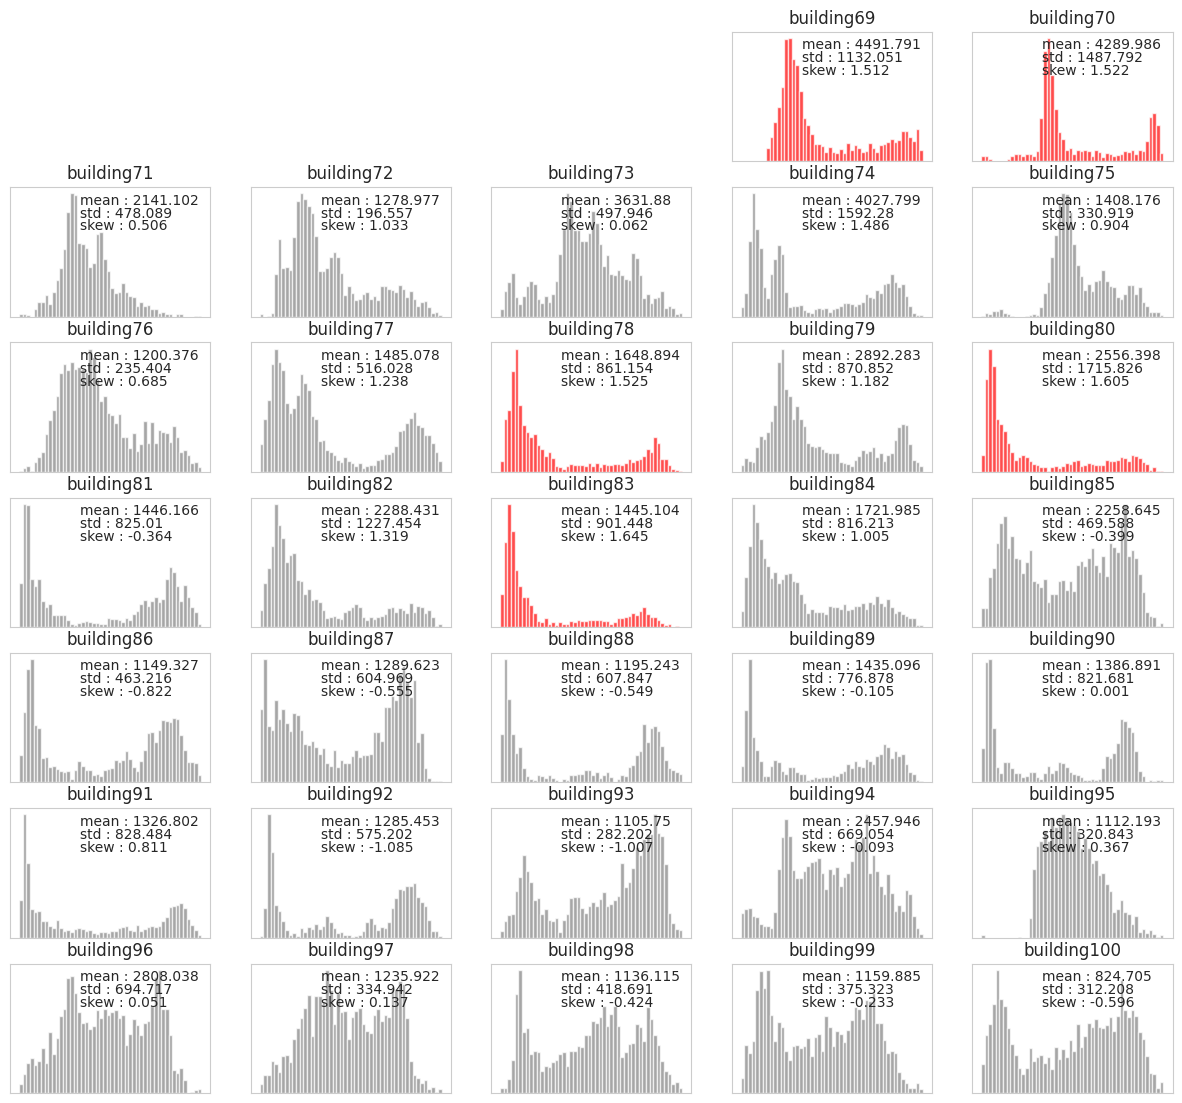

In [542]:
fig = plt.figure(figsize = (15, 40))
for num in eda_df['num'].unique():
    ax = plt.subplot(20, 5, num)
    energy = eda_df.loc[eda_df.num == num, 'target'].values
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

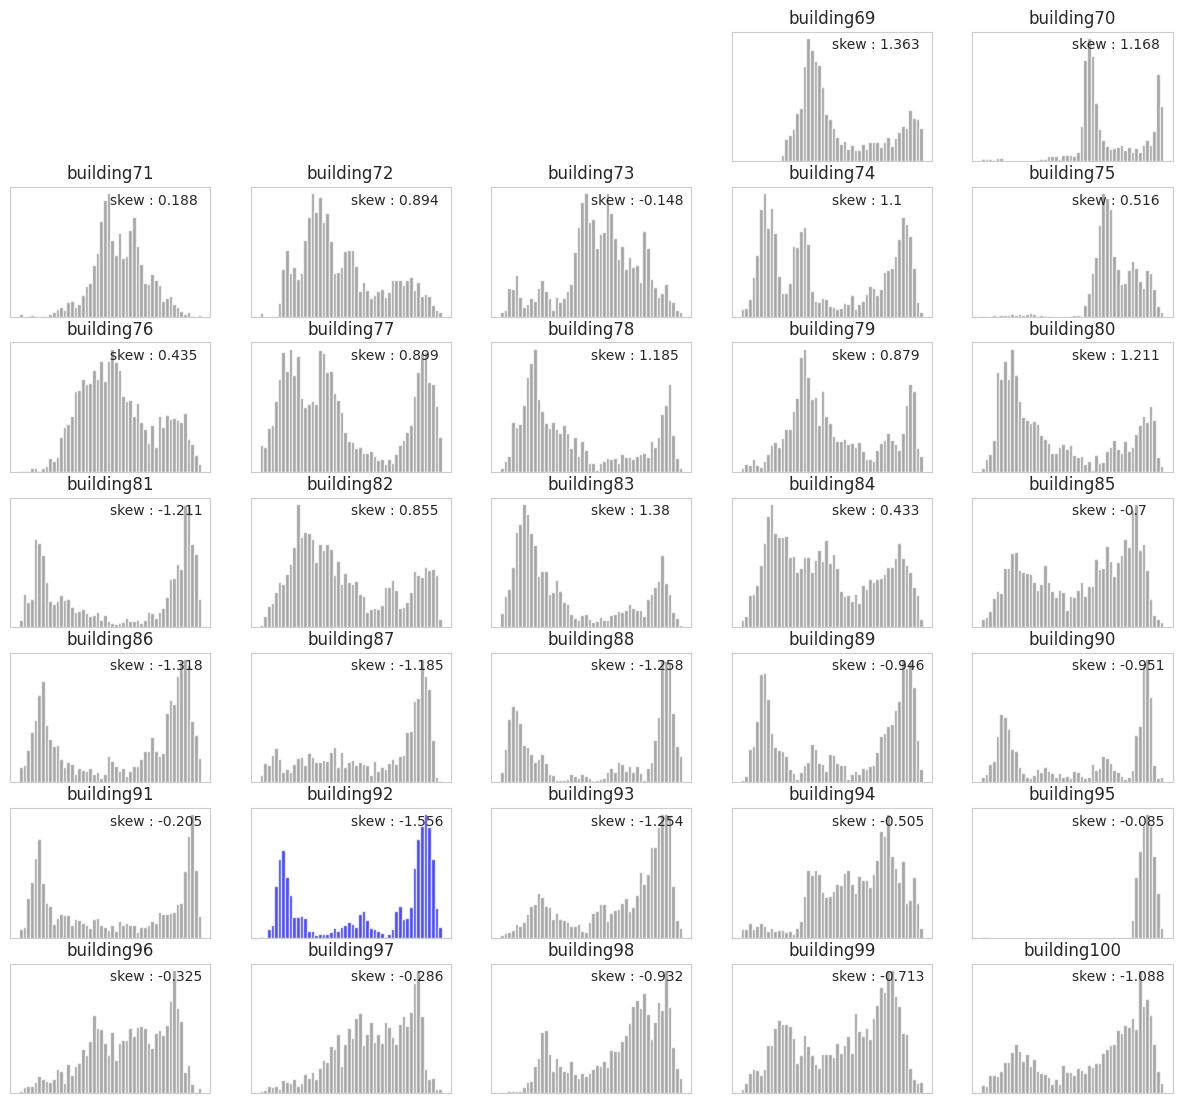

In [543]:
fig = plt.figure(figsize = (15, 40))
for num in eda_df['num'].unique():
    ax = plt.subplot(20, 5, num)
    energy = np.log(1 + eda_df.loc[eda_df.num == num, 'target'].values)
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.5, 0.9, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

In [544]:
# 로그 변환을 통해 왜도값이 줄어듦을 확인했으니, target을 로그변환한 값으로 학습해야 함
# 추론 시에는 모델 예측값에 역로그 변환(exponential)을 적용해야 함

# 모델의 로그 변환된 예측값
# log_pred = 2.0

# 역 로그 변환 (exponential)
# original_pred = np.exp(log_pred)

In [545]:
eda_df.head()

target   num_date_time  num           date_time    기온  강수량   풍속    습도   일조  \
0  3269.1  69_20220601 00   69 2022-06-01 00:00:00  18.6  0.0  0.9  42.0  0.0   
1  3201.0  69_20220601 01   69 2022-06-01 01:00:00  18.0  0.0  1.1  45.0  0.0   
2  3191.1  69_20220601 02   69 2022-06-01 02:00:00  17.7  0.0  1.5  45.0  0.0   
3  3191.7  69_20220601 03   69 2022-06-01 03:00:00  16.7  0.0  1.4  48.0  0.0   
4  3184.8  69_20220601 04   69 2022-06-01 04:00:00  18.4  0.0  2.8  43.0  0.0   

    일사  hour  weekday        date  day  month  weekend  
0  0.0     0        2  2022-06-01    1      6        0  
1  0.0     1        2  2022-06-01    1      6        0  
2  0.0     2        2  2022-06-01    1      6        0  
3  0.0     3        2  2022-06-01    1      6        0  
4  0.0     4        2  2022-06-01    1      6        0

In [546]:
eda_df.describe()

target           num            기온           강수량            풍속  \
count  65280.000000  65280.000000  65280.000000  65280.000000  65280.000000   
mean    1910.064386     84.500000     25.473186      0.449645      2.141192   
std     1267.751181      9.233163      3.795248      2.685400      1.366415   
min        0.000000     69.000000     10.300000      0.000000      0.000000   
25%     1043.100000     76.750000     23.300000      0.000000      1.200000   
50%     1570.140000     84.500000     25.600000      0.000000      2.000000   
75%     2430.480000     92.250000     28.000000      0.000000      2.900000   
max     7193.520000    100.000000     37.100000     92.200000     13.300000   

                 습도            일조            일사         hour       weekday  \
count  65280.000000  65280.000000  65280.000000  65280.00000  65280.000000   
mean      78.878329      0.217431      0.568449     11.50000      2.988235   
std       15.288178      0.362607      0.900639      6.92224      1.991137   
min        0.000000      0.000000      0.000000      0.00000      0.000000   
25%       69.000000      0.000000      0.000000      5.75000      1.000000   
50%       81.000000      0.000000      0.000000     11.50000      3.000000   
75%       91.000000      0.300000      0.840000     17.25000      5.000000   
max      100.000000      1.000000      3.850000     23.00000      6.000000   

                day         month       weekend  
count  65280.000000  65280.000000  65280.000000  
mean      14.835294      6.929412      0.282353  
std        8.446222      0.793928      0.450148  
min        1.000000      6.000000      0.000000  
25%        8.000000      6.000000      0.000000  
50%       15.000000      7.000000      0.000000  
75%       22.000000      8.000000      1.000000  
max       31.000000      8.000000      1.000000

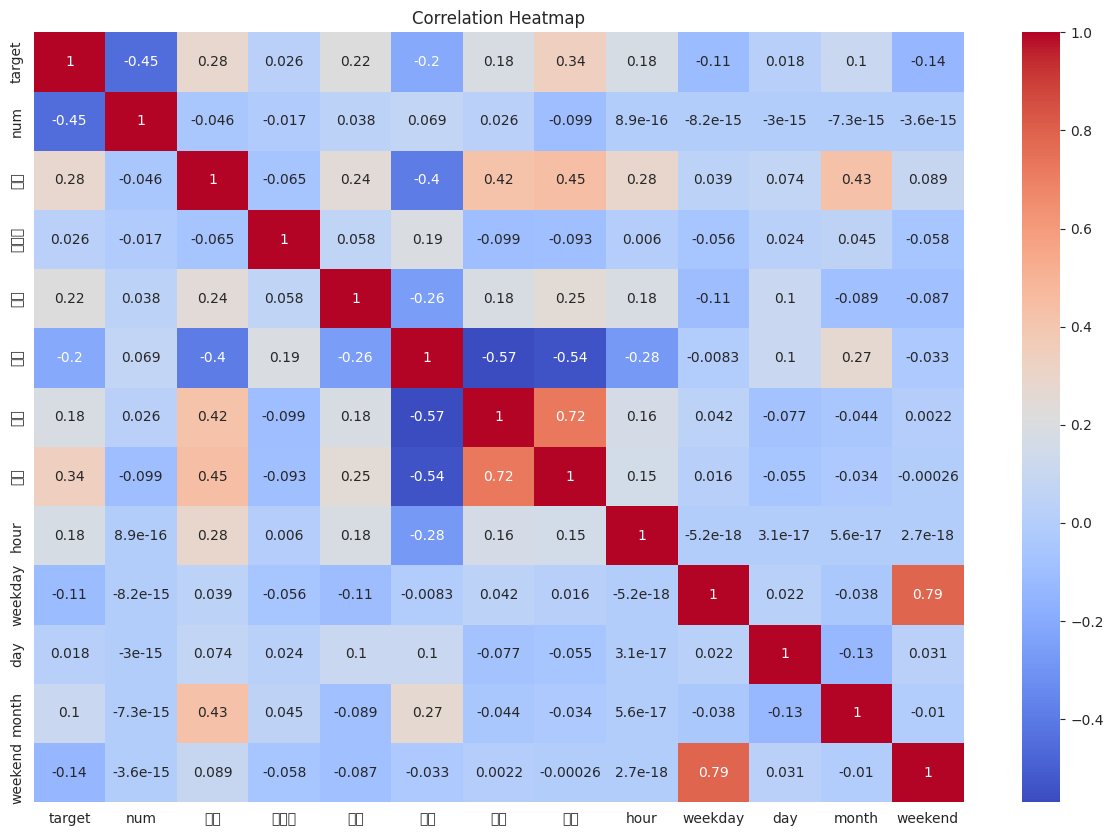

In [547]:
# 상관 관계 행렬
correlation_matrix = eda_df.corr()

# 히트맵을 사용한 상관 관계 시각화
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


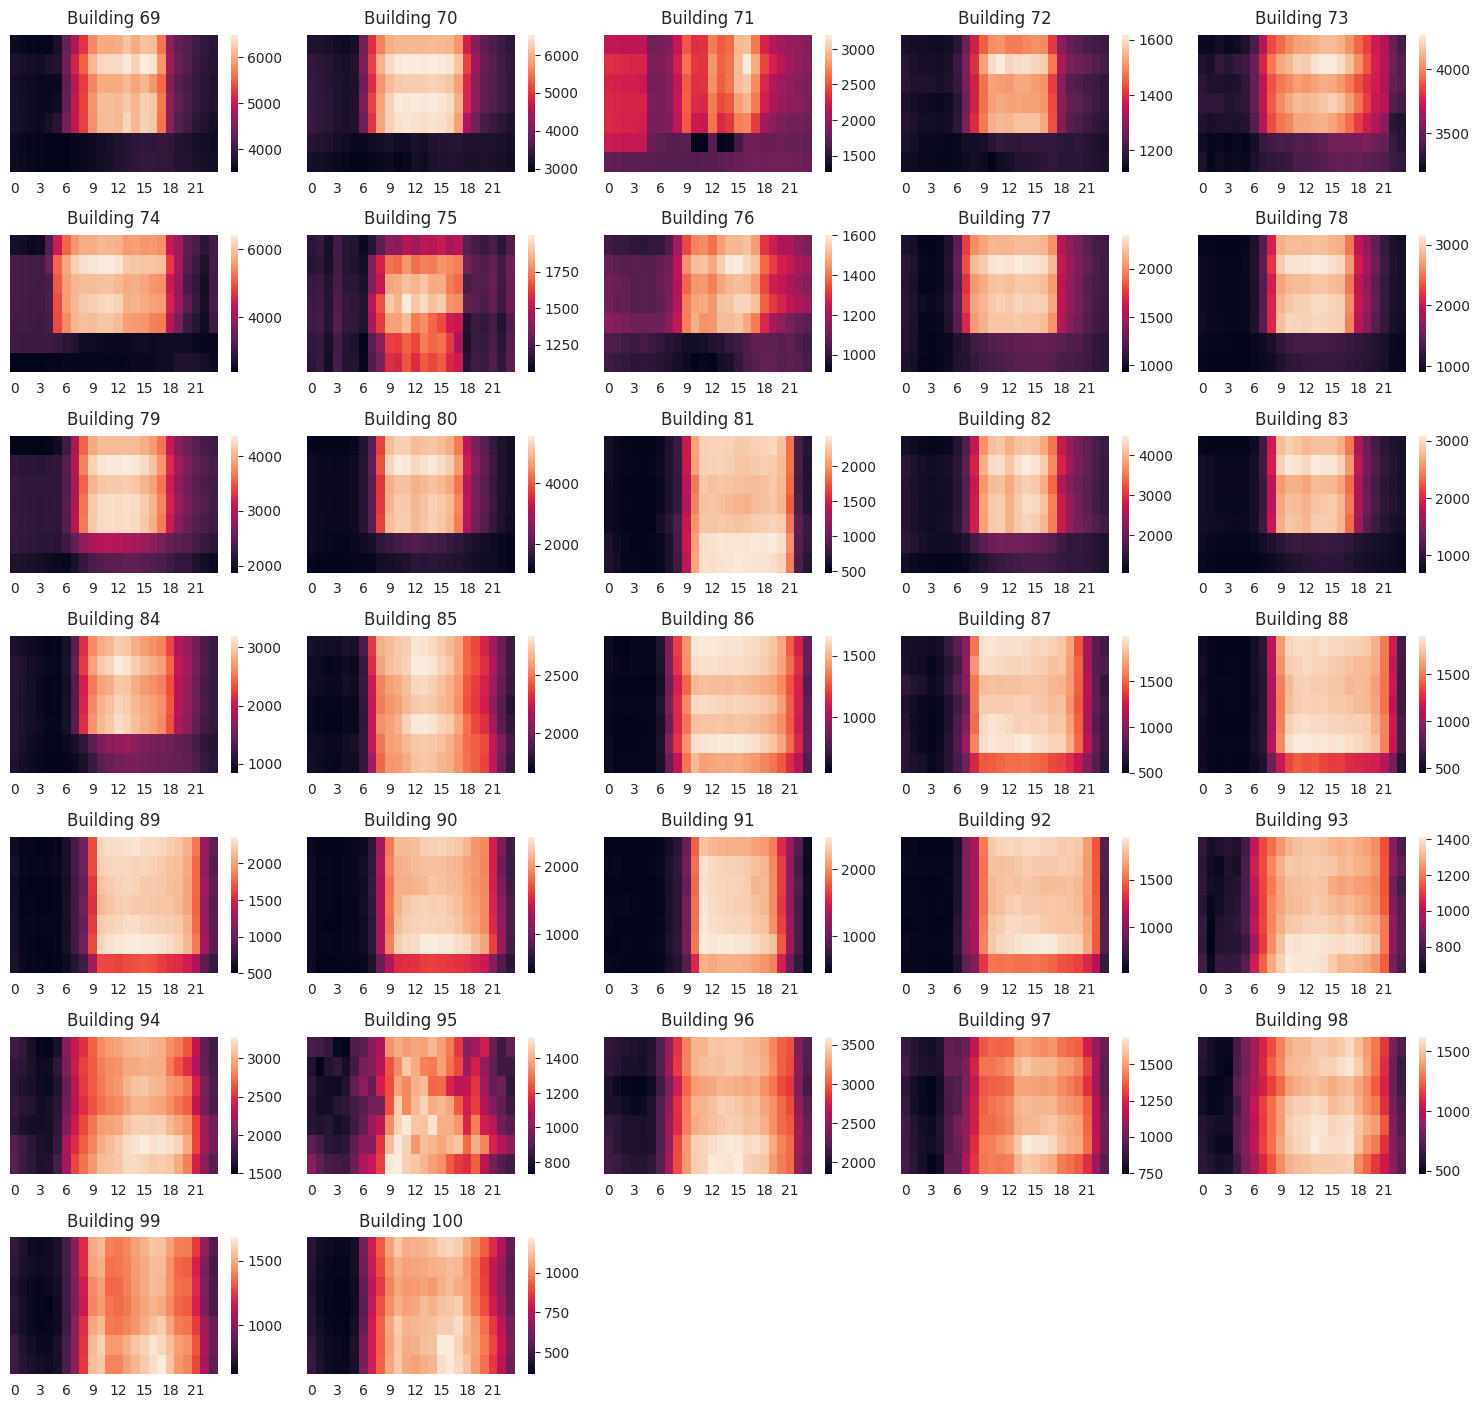

In [548]:
# energy usage of each building ~ weekday, hour
fig = plt.figure(figsize=(15, 40))
for i, num in enumerate(eda_df['num'].unique()):
    df = eda_df[eda_df.num == num]
    df = df.groupby(['weekday', 'hour'])['target'].mean().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(20, 5, i+1)
    sns.heatmap(df)
    plt.title(f'Building {num}', y=1.02)  # 조정된 타이틀 위치
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

plt.tight_layout()  # 서브플롯 간격 조절
plt.show()

In [549]:
# for i, num in enumerate(eda_df['num'].unique()):
#     df = eda_df[eda_df.num == num]
#     df = df.groupby(['weekday', 'hour'])['target'].mean().reset_index().pivot('weekday', 'hour', 'target')

<Axes: xlabel='date_time', ylabel='target'>

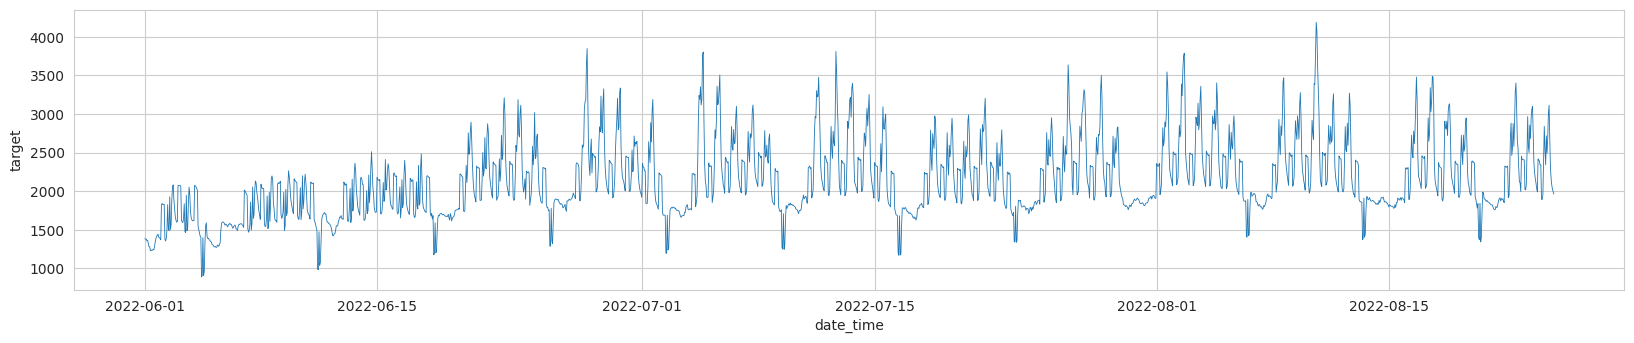

In [550]:
num_71 = eda_df[eda_df.num == 71]

fig = plt.figure(figsize = (20, 8))
plt.subplot(212)
sns.lineplot(data = num_71, x = 'date_time', y = 'target', linewidth = 0.6)

In [551]:
print(num_71['date'].loc[num_71.weekday == 5].unique())

[datetime.date(2022, 6, 4) datetime.date(2022, 6, 11)
 datetime.date(2022, 6, 18) datetime.date(2022, 6, 25)
 datetime.date(2022, 7, 2) datetime.date(2022, 7, 9)
 datetime.date(2022, 7, 16) datetime.date(2022, 7, 23)
 datetime.date(2022, 7, 30) datetime.date(2022, 8, 6)
 datetime.date(2022, 8, 13) datetime.date(2022, 8, 20)]


In [552]:
print(num_71.loc[num_71.target < 1500, 'date'].unique())

[datetime.date(2022, 6, 1) datetime.date(2022, 6, 2)
 datetime.date(2022, 6, 3) datetime.date(2022, 6, 4)
 datetime.date(2022, 6, 5) datetime.date(2022, 6, 6)
 datetime.date(2022, 6, 7) datetime.date(2022, 6, 9)
 datetime.date(2022, 6, 11) datetime.date(2022, 6, 12)
 datetime.date(2022, 6, 18) datetime.date(2022, 6, 25)
 datetime.date(2022, 7, 2) datetime.date(2022, 7, 9)
 datetime.date(2022, 7, 16) datetime.date(2022, 7, 23)
 datetime.date(2022, 8, 6) datetime.date(2022, 8, 13)
 datetime.date(2022, 8, 20)]


In [553]:
# 71번 건물 매주 토요일 10~11시, 13~14시 전력 소모 적음
# 7월 30일 토요일만 전력 소모가 많았음
# 매주 토요일 10~11시, 13~14시의 평균 전력으로 이상치 처리

idx = eda_df[(eda_df.num == 71)&(eda_df.weekday == 5)&(eda_df.target < 1500)].index
idxs = [i for i in idx]

In [554]:
num_71_outlier = np.mean([eda_df.loc[i, 'target'] for i in idxs])
num_71_outlier

1286.1966101694916

In [555]:
fill_date = ['2022-07-30 10:00:00','2022-07-30 11:00:00','2022-07-30 13:00:00','2022-07-30 14:00:00']
[eda_df[(eda_df.num == 71)&(eda_df.date_time == date)].index for date in fill_date]

[Int64Index([5506], dtype='int64'),
 Int64Index([5507], dtype='int64'),
 Int64Index([5509], dtype='int64'),
 Int64Index([5510], dtype='int64')]

In [556]:
eda_df.loc[5506, 'target'], eda_df.loc[5507, 'target'], eda_df.loc[5509, 'target'], eda_df.loc[5510, 'target']

(1814.88, 1799.04, 1838.28, 1850.64)

- 71번 건물 이상치를 평균으로 치환

In [557]:
train_ft.loc[5506:5510,'target']

5506    1814.88
5507    1799.04
5508    1837.68
5509    1838.28
5510    1850.64
Name: target, dtype: float64

In [558]:
train_ft.loc[5506, 'target'] = num_71_outlier
train_ft.loc[5507, 'target'] = num_71_outlier
train_ft.loc[5509, 'target'] = num_71_outlier
train_ft.loc[5510, 'target'] = num_71_outlier
train_ft.loc[5506:5510,'target']

5506    1286.19661
5507    1286.19661
5508    1837.68000
5509    1286.19661
5510    1286.19661
Name: target, dtype: float64

In [559]:
# num을 기준으로 하는 data frame 생성
by_weekday = eda_df.groupby(['num','weekday'])['target'].median().reset_index().pivot('num','weekday','target').reset_index()
by_hour = eda_df.groupby(['num','hour'])['target'].median().reset_index().pivot('num','hour','target').reset_index().drop('num', axis = 1)
df = pd.concat([by_weekday, by_hour], axis= 1)
df

num        0         1         2         3         4         5        6  \
0    69  4204.35  4643.550  4284.900  4435.350  4497.450  3655.050  3675.90   
1    70  3873.31  4512.465  4185.195  4417.870  4297.475  3273.390  3255.22   
2    71  2227.68  2309.520  2282.760  2248.080  2149.680  1794.000  1793.64   
3    72  1250.82  1306.440  1287.090  1263.870  1277.550  1151.370  1148.85   
4    73  3772.56  3826.320  3747.840  3746.880  3699.600  3426.240  3393.36   
5    74  4340.16  5208.840  4547.880  4913.280  4427.280  2585.340  2450.16   
6    75  1294.50  1336.980  1327.920  1349.280  1294.200  1277.160  1272.18   
7    76  1168.11  1273.770  1230.660  1246.680  1223.280  1013.760   998.37   
8    77  1360.62  1521.000  1427.220  1495.080  1458.000  1176.300  1143.72   
9    78  1422.96  1587.360  1477.440  1573.680  1525.440  1054.320  1009.20   
10   79  2619.12  2951.520  2716.560  2903.280  2816.880  2476.320  2200.80   
11   80  2048.40  2466.720  2196.000  2443.680  2296.080  1386.360  1253.52   
12   81  1544.94  1495.080  1406.160  1454.400  1562.220  1642.320  1606.32   
13   82  2047.68  2241.360  2044.800  2225.520  2198.160  1576.440  1351.44   
14   83  1089.30  1250.400  1132.200  1236.000  1142.700   851.400   792.00   
15   84  1574.40  1904.400  1623.600  1771.200  1738.080  1278.240  1203.84   
16   85  2303.76  2371.800  2265.960  2261.520  2322.120  2360.280  2328.12   
17   86  1320.84  1347.570  1246.590  1300.770  1269.810  1304.775   957.69   
18   87  1487.52  1533.150  1426.320  1457.820  1498.050  1601.280   946.62   
19   88  1530.00  1525.950  1357.200  1405.260  1588.500  1608.660   574.02   
20   89  1702.20  1711.920  1660.440  1680.480  1692.000  1622.580   652.56   
21   90  1454.40  1421.400  1428.840  1503.960  1536.240  1620.000   507.96   
22   91  1124.64  1127.280  1093.920  1102.920  1111.680  1156.920   913.44   
23   92  1618.29  1574.550  1587.780  1605.870  1629.810  1509.210   898.38   
24   93  1185.21  1188.990  1166.220  1187.190  1210.185  1262.520  1228.05   
25   94  2505.84  2412.360  2383.320  2305.320  2541.540  2658.600  2532.48   
26   95  1020.96  1027.080  1038.420  1058.220  1094.760  1174.320  1108.98   
27   96  2761.92  2707.740  2728.680  2775.000  2797.680  2928.720  2868.66   
28   97  1160.19  1193.490  1160.460  1221.660  1244.070  1312.560  1268.55   
29   98  1170.99  1179.720  1173.150  1213.965  1249.020  1238.670  1153.62   
30   99  1189.62  1144.170  1143.090  1118.970  1196.820  1222.740  1234.53   
31  100   891.24   843.120   834.480   893.760   921.480   949.920   917.76   

          0        1  ...       14       15       16       17       18  \
0   3702.00  3665.10  ...  6032.40  6142.50  6056.40  5591.70  4492.20   
1   3441.70  3384.17  ...  6225.96  6212.21  6176.55  5770.10  4438.84   
2   2305.92  2303.28  ...  2451.60  2705.04  2792.40  2477.28  2104.56   
3   1153.44  1141.92  ...  1505.16  1501.56  1496.88  1401.30  1275.84   
4   3378.24  3357.12  ...  4008.96  3990.24  3970.08  3871.68  3798.72   
5   3074.40  3088.80  ...  5545.44  5547.60  5551.20  5549.04  4328.64   
6   1193.88  1218.24  ...  1733.40  1744.86  1652.76  1633.20  1230.84   
7   1078.92  1070.82  ...  1483.92  1537.74  1478.88  1441.26  1294.56   
8   1067.40  1031.40  ...  2190.60  2179.08  2165.40  2044.80  1550.16   
9    969.12   959.04  ...  2988.48  2900.64  2861.28  2599.68  1971.84   
10  2234.88  2211.84  ...  4255.20  4148.16  3978.24  3651.84  3132.00   
11  1193.76  1167.84  ...  5131.44  4956.48  4831.20  4226.40  3011.76   
12   577.80   531.72  ...  2313.00  2286.72  2294.28  2307.96  2361.96   
13  1373.04  1285.20  ...  4047.12  4005.36  3795.84  3299.04  2560.32   
14   792.00   770.40  ...  2848.20  2824.20  2678.40  2359.80  1652.40   
15  1080.00  1008.00  ...  2798.40  2672.40  2632.80  2553.12  2277.60   
16  1671.84  1668.24  ...  2799.36  2762.88  2721.84  2636.64  2487.60   
17   580.68   543.78  ...  1619.46  1635.48  1617.84  1604.34  1

In [560]:
columns = ['num'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
df.columns = columns
df

num     day0      day1      day2      day3      day4      day5     day6  \
0    69  4204.35  4643.550  4284.900  4435.350  4497.450  3655.050  3675.90   
1    70  3873.31  4512.465  4185.195  4417.870  4297.475  3273.390  3255.22   
2    71  2227.68  2309.520  2282.760  2248.080  2149.680  1794.000  1793.64   
3    72  1250.82  1306.440  1287.090  1263.870  1277.550  1151.370  1148.85   
4    73  3772.56  3826.320  3747.840  3746.880  3699.600  3426.240  3393.36   
5    74  4340.16  5208.840  4547.880  4913.280  4427.280  2585.340  2450.16   
6    75  1294.50  1336.980  1327.920  1349.280  1294.200  1277.160  1272.18   
7    76  1168.11  1273.770  1230.660  1246.680  1223.280  1013.760   998.37   
8    77  1360.62  1521.000  1427.220  1495.080  1458.000  1176.300  1143.72   
9    78  1422.96  1587.360  1477.440  1573.680  1525.440  1054.320  1009.20   
10   79  2619.12  2951.520  2716.560  2903.280  2816.880  2476.320  2200.80   
11   80  2048.40  2466.720  2196.000  2443.680  2296.080  1386.360  1253.52   
12   81  1544.94  1495.080  1406.160  1454.400  1562.220  1642.320  1606.32   
13   82  2047.68  2241.360  2044.800  2225.520  2198.160  1576.440  1351.44   
14   83  1089.30  1250.400  1132.200  1236.000  1142.700   851.400   792.00   
15   84  1574.40  1904.400  1623.600  1771.200  1738.080  1278.240  1203.84   
16   85  2303.76  2371.800  2265.960  2261.520  2322.120  2360.280  2328.12   
17   86  1320.84  1347.570  1246.590  1300.770  1269.810  1304.775   957.69   
18   87  1487.52  1533.150  1426.320  1457.820  1498.050  1601.280   946.62   
19   88  1530.00  1525.950  1357.200  1405.260  1588.500  1608.660   574.02   
20   89  1702.20  1711.920  1660.440  1680.480  1692.000  1622.580   652.56   
21   90  1454.40  1421.400  1428.840  1503.960  1536.240  1620.000   507.96   
22   91  1124.64  1127.280  1093.920  1102.920  1111.680  1156.920   913.44   
23   92  1618.29  1574.550  1587.780  1605.870  1629.810  1509.210   898.38   
24   93  1185.21  1188.990  1166.220  1187.190  1210.185  1262.520  1228.05   
25   94  2505.84  2412.360  2383.320  2305.320  2541.540  2658.600  2532.48   
26   95  1020.96  1027.080  1038.420  1058.220  1094.760  1174.320  1108.98   
27   96  2761.92  2707.740  2728.680  2775.000  2797.680  2928.720  2868.66   
28   97  1160.19  1193.490  1160.460  1221.660  1244.070  1312.560  1268.55   
29   98  1170.99  1179.720  1173.150  1213.965  1249.020  1238.670  1153.62   
30   99  1189.62  1144.170  1143.090  1118.970  1196.820  1222.740  1234.53   
31  100   891.24   843.120   834.480   893.760   921.480   949.920   917.76   

      hour0    hour1  ...   hour14   hour15   hour16   hour17   hour18  \
0   3702.00  3665.10  ...  6032.40  6142.50  6056.40  5591.70  4492.20   
1   3441.70  3384.17  ...  6225.96  6212.21  6176.55  5770.10  4438.84   
2   2305.92  2303.28  ...  2451.60  2705.04  2792.40  2477.28  2104.56   
3   1153.44  1141.92  ...  1505.16  1501.56  1496.88  1401.30  1275.84   
4   3378.24  3357.12  ...  4008.96  3990.24  3970.08  3871.68  3798.72   
5   3074.40  3088.80  ...  5545.44  5547.60  5551.20  5549.04  4328.64   
6   1193.88  1218.24  ...  1733.40  1744.86  1652.76  1633.20  1230.84   
7   1078.92  1070.82  ...  1483.92  1537.74  1478.88  1441.26  1294.56   
8   1067.40  1031.40  ...  2190.60  2179.08  2165.40  2044.80  1550.16   
9    969.12   959.04  ...  2988.48  2900.64  2861.28  2599.68  1971.84   
10  2234.88  2211.84  ...  4255.20  4148.16  3978.24  3651.84  3132.00   
11  1193.76  1167.84  ...  5131.44  4956.48  4831.20  4226.40  3011.76   
12   577.80   531.72  ...  2313.00  2286.72  2294.28  2307.96  2361.96   
13  1373.04  1285.20  ...  4047.12  4005.36  3795.84  3299.04  2560.32   
14   792.00   770.40  ...  2848.20  2824.20  2678.40  2359.80  1652.40   
15  1080.00  1008.00  ...  2798.40  2672.40  2632.80  2553.12  2277.60   
16  1671.84  1668.24  ...  2799.36  2762.88  2721.84  2636.64  2487.60   
17   580.68   543.78  ...  1619.46  1635.48  1617.84  1604.34  1

In [561]:
len(df)

32

In [562]:
# '전력사용량'이 아닌 '요일과 시간대에 따른 전력 사용량의 경향성'에 따라서만 군집화 할 것이므로, 특수한 scaling이 필요함
# standard scaling
for i in range(len(df)):
    # 요일 별 전력 중앙값에 대해 scaling
    df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()

In [563]:
df

num      day0      day1      day2      day3      day4      day5      day6  \
0    69  0.012371  1.134304  0.218135  0.602459  0.761093 -1.390812 -1.337551   
1    70 -0.190949  1.026456  0.403102  0.846280  0.616963 -1.333622 -1.368230   
2    71  0.500444  0.864085  0.745182  0.591088  0.153866 -1.426533 -1.428132   
3    72  0.154716  1.018330  0.717882  0.357344  0.569754 -1.389449 -1.428577   
4    73  0.650589  0.958504  0.509003  0.503504  0.232704 -1.332990 -1.521313   
5    74  0.247728  1.037158  0.436498  0.768562  0.326900 -1.346999 -1.469846   
6    75 -0.426295  0.971004  0.672993  1.375589 -0.436163 -0.996661 -1.160469   
7    76  0.027945  0.961498  0.580602  0.722146  0.515396 -1.335805 -1.471782   
8    77 -0.054206  1.002294  0.384521  0.831547  0.587283 -1.268410 -1.483030   
9    78  0.181856  0.856255  0.405343  0.800137  0.602248 -1.330374 -1.515465   
10   79 -0.189858  1.070011  0.179461  0.887171  0.559696 -0.731101 -1.775382   
11   80  0.071449  0.914946  0.369069  0.868489  0.570869 -1.263483 -1.531340   
12   81  0.176166 -0.419969 -1.483112 -0.906346  0.382768  1.340458  0.910036   
13   82  0.263999  0.816037  0.255790  0.770889  0.692906 -1.079156 -1.720464   
14   83  0.103969  0.998292  0.342122  0.918352  0.400411 -1.216698 -1.546448   
15   84 -0.040312  1.236008  0.149976  0.720839  0.592743 -1.185751 -1.473503   
16   85 -0.292667  1.305126 -1.180330 -1.284595  0.138483  1.034600  0.279382   
17   86  0.535158  0.736296 -0.023558  0.384136  0.151168  0.414272 -2.197472   
18   87  0.304433  0.514961  0.022067  0.167402  0.353016  0.829300 -2.191179   
19   88  0.441212  0.430048 -0.035123  0.097358  0.602471  0.658044 -2.194011   
20   89  0.438400  0.463398  0.330999  0.382539  0.412167  0.233628 -2.261130   
21   90  0.266773  0.179733  0.199356  0.397491  0.482633  0.703557 -2.229542   
22   91  0.428824  0.461614  0.047269  0.159052  0.267855  0.829755 -2.194368   
23   92  0.490226  0.324215  0.374428  0.443087  0.533949  0.076223 -2.242126   
24   93 -0.580125 -0.463743 -1.164802 -0.519163  0.188823  1.800148  0.738862   
25   94  0.243940 -0.548557 -0.794750 -1.456012  0.546595  1.538997  0.469787   
26   95 -0.974125 -0.863143 -0.657500 -0.298440  0.364190  1.806958  0.622060   
27   96 -0.428483 -1.120118 -0.852808 -0.261510  0.028011  1.700802  0.934106   
28   97 -1.108302 -0.520686 -1.103538 -0.023595  0.371854  1.580437  0.803831   
29   98 -0.705989 -0.469207 -0.647404  0.459617  1.410409  1.129687 -1.177114   
30   99  0.252212 -0.784497 -0.809131 -1.359305  0.416443  1.007675  1.276603   
31  100 -0.044498 -1.190415 -1.396166  0.015513  0.675630  1.352893  0.587043   

       hour0     hour1  ...    hour14    hour15    hour16    hour17    hour18  \
0  -0.955538 -0.990059  ...  1.224620  1.327621  1.247072  0.812332 -0.216283   
1  -0.914358 -0.958728  ...  1.233017  1.222412  1.194909  0.881433 -0.145308   
2   0.275707  0.266261  ...  0.796923  1.703686  2.016244  0.888802 -0.444723   
3  -0.947832 -1.020206  ...  1.261828  1.239212  1.209810  0.609334 -0.178861   
4  -1.268989 -1.355427  ...  1.312371  1.235756  1.153246  0.750523  0.451918   
5  -1.084259 -1.073583  ...  0.747818  0.749419  0.752089  0.750487 -0.154341   
6  -0.923075 -0.824333  ...  1.263850  1.310302  0.936978  0.857693 -0.773259   
7  -0.944878 -0.990829  ...  1.352646  1.657962  1.324055  1.110640  0.278426   
8  -1.037093 -1.106741  ...  1.135935  1.113648  1.087181  0.853859 -0.103109   
9  -1.013791 -1.025187  ...  1.269257  1.169947  1.125447  0.829687  0.119864   
10 -1.016531 -1.042879  ...  1.293924  1.171513  0.977191  0.603917  0.009423   
11 -1.013888 -1.029482  ...  1.355076  1.249817  1.174447  0.810591  0.079846   
12 -1.058093 -1.112614  ...  0.994947  0.963854  0.972798  0.988984  1.052875   
13 -0.965340 -1.042776  ...  1.392034  1.355220  1.170515  0.732554  0.081324   
14 -0.943389 -0.967706  ...  1.371404  1.344386  1.180249  0.821582  0.025217   
15 -0.975322 -1.067041  ...  1.213

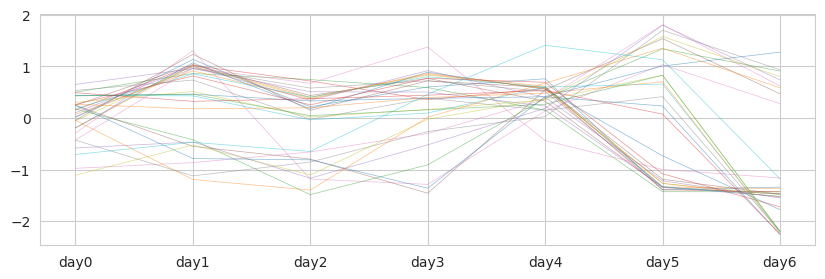

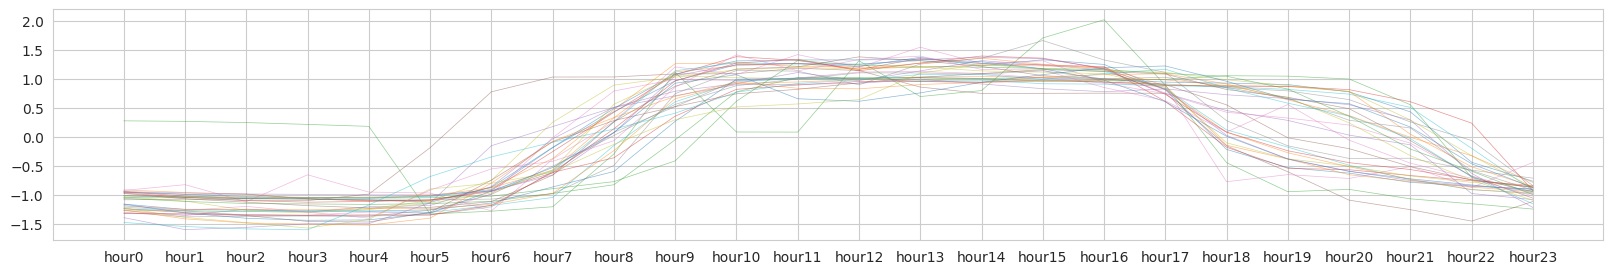

In [564]:
# visualization
fig = plt.figure(figsize = (10,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
fig = plt.figure(figsize = (20,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 8:], alpha = 0.5, linewidth = 0.5)

## 군집별

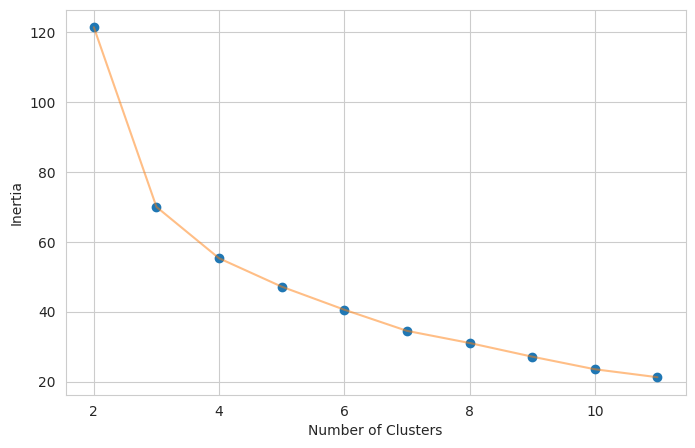

In [565]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)

    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])

In [566]:
# 최적의 군집개수는 3개지만, 71번이 특이한 건물이므로 4개로 나눔
kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(df.iloc[:,1:])
km_cluster

array([0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 2, 1, 1], dtype=int32)

In [567]:
df_clust = df.copy()
df_clust['km_cluster'] = km_cluster
df_clust['km_cluster'] = df_clust['km_cluster'].map({0:1, 1:3, 2:2, 3:0})
df_clust

num      day0      day1      day2      day3      day4      day5      day6  \
0    69  0.012371  1.134304  0.218135  0.602459  0.761093 -1.390812 -1.337551   
1    70 -0.190949  1.026456  0.403102  0.846280  0.616963 -1.333622 -1.368230   
2    71  0.500444  0.864085  0.745182  0.591088  0.153866 -1.426533 -1.428132   
3    72  0.154716  1.018330  0.717882  0.357344  0.569754 -1.389449 -1.428577   
4    73  0.650589  0.958504  0.509003  0.503504  0.232704 -1.332990 -1.521313   
5    74  0.247728  1.037158  0.436498  0.768562  0.326900 -1.346999 -1.469846   
6    75 -0.426295  0.971004  0.672993  1.375589 -0.436163 -0.996661 -1.160469   
7    76  0.027945  0.961498  0.580602  0.722146  0.515396 -1.335805 -1.471782   
8    77 -0.054206  1.002294  0.384521  0.831547  0.587283 -1.268410 -1.483030   
9    78  0.181856  0.856255  0.405343  0.800137  0.602248 -1.330374 -1.515465   
10   79 -0.189858  1.070011  0.179461  0.887171  0.559696 -0.731101 -1.775382   
11   80  0.071449  0.914946  0.369069  0.868489  0.570869 -1.263483 -1.531340   
12   81  0.176166 -0.419969 -1.483112 -0.906346  0.382768  1.340458  0.910036   
13   82  0.263999  0.816037  0.255790  0.770889  0.692906 -1.079156 -1.720464   
14   83  0.103969  0.998292  0.342122  0.918352  0.400411 -1.216698 -1.546448   
15   84 -0.040312  1.236008  0.149976  0.720839  0.592743 -1.185751 -1.473503   
16   85 -0.292667  1.305126 -1.180330 -1.284595  0.138483  1.034600  0.279382   
17   86  0.535158  0.736296 -0.023558  0.384136  0.151168  0.414272 -2.197472   
18   87  0.304433  0.514961  0.022067  0.167402  0.353016  0.829300 -2.191179   
19   88  0.441212  0.430048 -0.035123  0.097358  0.602471  0.658044 -2.194011   
20   89  0.438400  0.463398  0.330999  0.382539  0.412167  0.233628 -2.261130   
21   90  0.266773  0.179733  0.199356  0.397491  0.482633  0.703557 -2.229542   
22   91  0.428824  0.461614  0.047269  0.159052  0.267855  0.829755 -2.194368   
23   92  0.490226  0.324215  0.374428  0.443087  0.533949  0.076223 -2.242126   
24   93 -0.580125 -0.463743 -1.164802 -0.519163  0.188823  1.800148  0.738862   
25   94  0.243940 -0.548557 -0.794750 -1.456012  0.546595  1.538997  0.469787   
26   95 -0.974125 -0.863143 -0.657500 -0.298440  0.364190  1.806958  0.622060   
27   96 -0.428483 -1.120118 -0.852808 -0.261510  0.028011  1.700802  0.934106   
28   97 -1.108302 -0.520686 -1.103538 -0.023595  0.371854  1.580437  0.803831   
29   98 -0.705989 -0.469207 -0.647404  0.459617  1.410409  1.129687 -1.177114   
30   99  0.252212 -0.784497 -0.809131 -1.359305  0.416443  1.007675  1.276603   
31  100 -0.044498 -1.190415 -1.396166  0.015513  0.675630  1.352893  0.587043   

       hour0     hour1  ...    hour15    hour16    hour17    hour18    hour19  \
0  -0.955538 -0.990059  ...  1.327621  1.247072  0.812332 -0.216283 -0.530621   
1  -0.914358 -0.958728  ...  1.222412  1.194909  0.881433 -0.145308 -0.383048   
2   0.275707  0.266261  ...  1.703686  2.016244  0.888802 -0.444723 -0.945331   
3  -0.947832 -1.020206  ...  1.239212  1.209810  0.609334 -0.178861 -0.541861   
4  -1.268989 -1.355427  ...  1.235756  1.153246  0.750523  0.451918  0.282971   
5  -1.084259 -1.073583  ...  0.749419  0.752089  0.750487 -0.154341 -0.601684   
6  -0.923075 -0.824333  ...  1.310302  0.936978  0.857693 -0.773259 -0.650682   
7  -0.944878 -0.990829  ...  1.657962  1.324055  1.110640  0.278426 -0.154530   
8  -1.037093 -1.106741  ...  1.113648  1.087181  0.853859 -0.103109 -0.378219   
9  -1.013791 -1.025187  ...  1.169947  1.125447  0.829687  0.119864 -0.177524   
10 -1.016531 -1.042879  ...  1.171513  0.977191  0.603917  0.009423 -0.381965   
11 -1.013888 -1.029482  ...  1.249817  1.174447  0.810591  0.079846 -0.274480   
12 -1.058093 -1.112614  ...  0.963854  0.972798  0.988984  1.052875  1.045208   
13 -0.965340 -1.042776  ...  1.355220  1.170515  0.732554  0.081324 -0.239847   
14 -0.943389 -0.967706  ...  1.344386  1.180249  0.821582  0.025217 -0.380733   
15 -0.975322 -1.067041  ...  1.053

In [568]:
np.unique(df_clust.km_cluster)

array([0, 1, 2, 3])

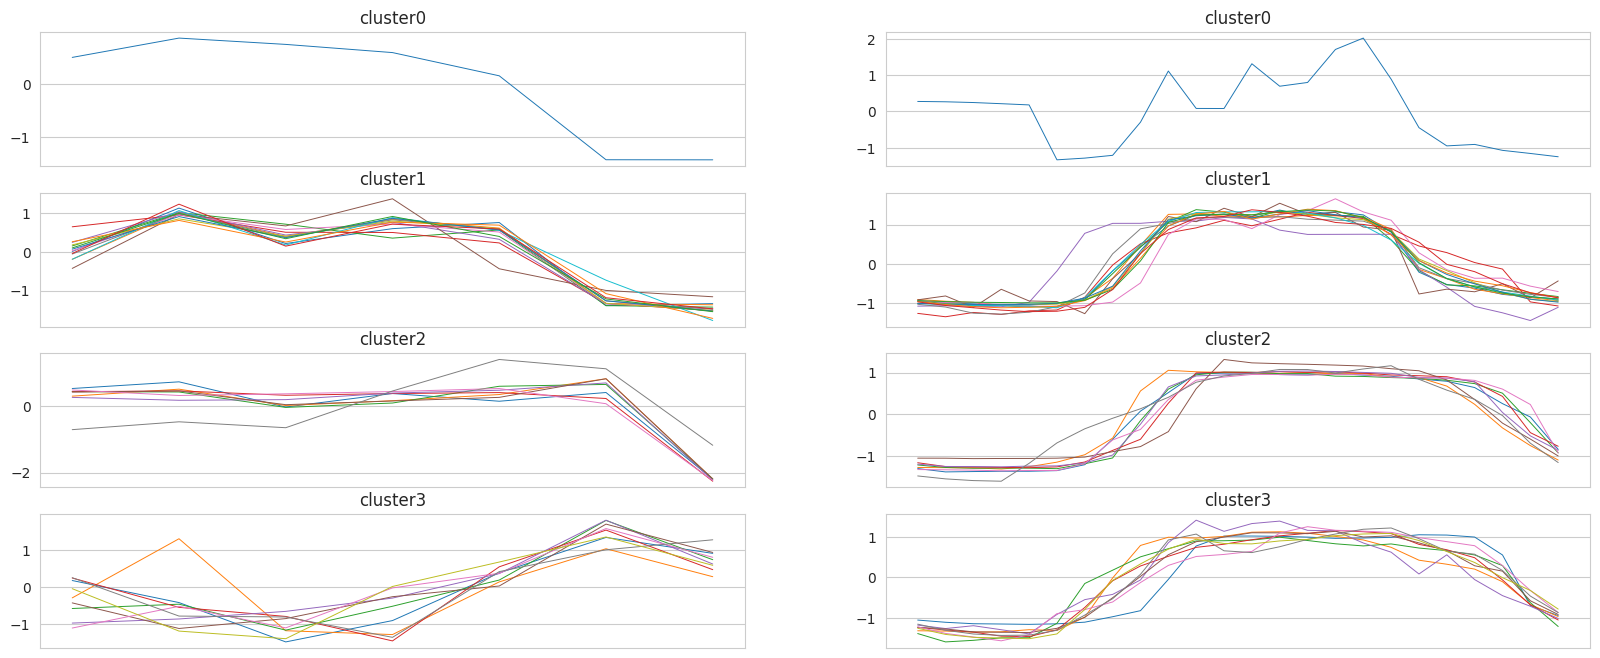

In [569]:
# visualizing result of kmeans clustering
num_cluster = len(np.unique(df_clust.km_cluster))

fig = plt.figure(figsize = (20,8))
for c in range(num_cluster):
    temp = df_clust[df_clust.km_cluster == c]
    plt.subplot(num_cluster,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, ) # 요일별
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(num_cluster,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-1], linewidth=0.7) # 시간대별
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [570]:
# drop_columns = ['km_cluster_x', 'km_cluster_y', 'km_cluster_x', 'km_cluster_y', 'km_cluster_x', 'km_cluster_y']
# eda_df = eda_df.drop(columns=drop_columns)

In [571]:
eda_df = eda_df.merge(df_clust[['num','km_cluster']], on = 'num', how = 'left')
eda_df

target    num_date_time  num           date_time    기온  강수량   풍속  \
0      3269.10   69_20220601 00   69 2022-06-01 00:00:00  18.6  0.0  0.9   
1      3201.00   69_20220601 01   69 2022-06-01 01:00:00  18.0  0.0  1.1   
2      3191.10   69_20220601 02   69 2022-06-01 02:00:00  17.7  0.0  1.5   
3      3191.70   69_20220601 03   69 2022-06-01 03:00:00  16.7  0.0  1.4   
4      3184.80   69_20220601 04   69 2022-06-01 04:00:00  18.4  0.0  2.8   
...        ...              ...  ...                 ...   ...  ...  ...   
65275   881.04  100_20220824 19  100 2022-08-24 19:00:00  23.1  0.0  0.9   
65276   798.96  100_20220824 20  100 2022-08-24 20:00:00  22.4  0.0  1.3   
65277   825.12  100_20220824 21  100 2022-08-24 21:00:00  21.3  0.0  1.0   
65278   640.08  100_20220824 22  100 2022-08-24 22:00:00  21.0  0.0  0.3   
65279   540.24  100_20220824 23  100 2022-08-24 23:00:00  20.7  0.0  0.1   

         습도   일조   일사  hour  weekday        date  day  month  weekend  \
0      42.0  0.0  0.0     0        2  2022-06-01    1      6        0   
1      45.0  0.0  0.0     1        2  2022-06-01    1      6        0   
2      45.0  0.0  0.0     2        2  2022-06-01    1      6        0   
3      48.0  0.0  0.0     3        2  2022-06-01    1      6        0   
4      43.0  0.0  0.0     4        2  2022-06-01    1      6        0   
...     ...  ...  ...   ...      ...         ...  ...    ...      ...   
65275  86.0  0.5  0.0    19        2  2022-08-24   24      8        0   
65276  86.0  0.0  0.0    20        2  2022-08-24   24      8        0   
65277  92.0  0.0  0.0    21        2  2022-08-24   24      8        0   
65278  94.0  0.0  0.0    22        2  2022-08-24   24      8        0   
65279  95.0  0.0  0.0    23        2  2022-08-24   24      8        0   

       km_cluster  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
65275           3  
65276           3  
65277           3  
65278           3  
65279           3  

[65280 rows x 17 columns]

In [572]:
train_ft = train_ft.merge(df_clust[['num','km_cluster']], on = 'num', how = 'left')
test_ft = test_ft.merge(df_clust[['num','km_cluster']], on = 'num', how = 'left')

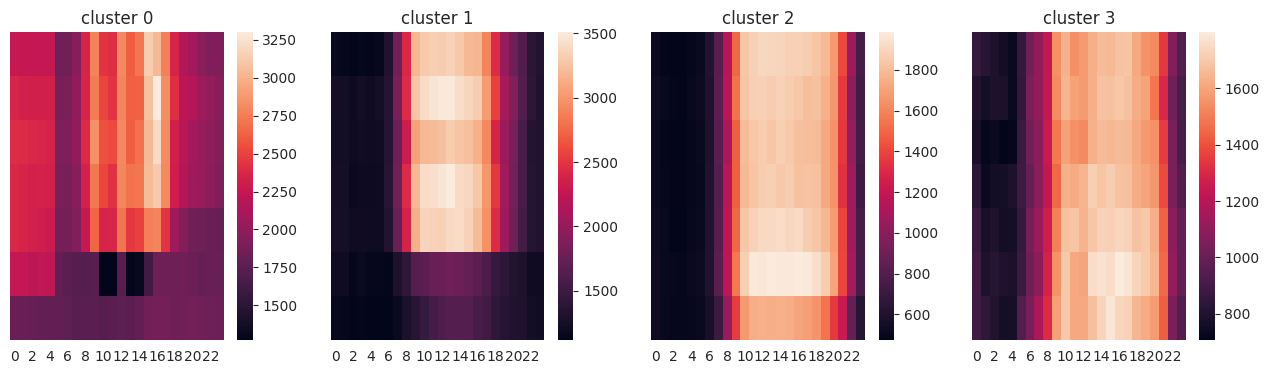

In [573]:
fig = plt.figure(figsize = (20, 4))
for c in np.unique(df_clust.km_cluster):
    temp = eda_df[eda_df.km_cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['target'].median().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(1, 5, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

```
cluster 0 : 야간과 주간 전력소모 차이가 뚜렷하지 않고, 항시 전력을 소모하는 건물(데이터센터같은?)
    - 71번 건물 : 토요일 낮시간대에 정기점검같은? 개념으로 전력을 off
cluster 1 : 평일 주간에 전력소모가 크고, 평일야간이나 주말에는 전력소모가 작은 건물(연구소, 지식산업센터)
cluster 2 : 야간과 주간 전력소모 차이는 뚜렷하지만, 평일 주말 관계없이 전력소모가 일정하거나 주말 전력소요가 조금 더 높은 건물(할인마트)
cluster 3 : 야간에도 어느정도 전력소요가 있는 건물(호텔 및 리조트)

```

In [574]:
# dictionary mapping cluster and building
match = df_clust[['num','km_cluster']]
clust2num = {0:[],1:[],2:[],3:[]}
for i in range(32):
    c = match.iloc[i,1]
    clust2num[c].append(68+i+1)
clust2num

{0: [71],
 1: [69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84],
 2: [86, 87, 88, 89, 90, 91, 92, 98],
 3: [81, 85, 93, 94, 95, 96, 97, 99, 100]}

In [575]:
# cluster 0 : pass

# cluster 1
# train_ft['사용시간_c'] = np.where((train_ft['hour'] >= 7) & (train_ft['hour'] <= 20) & (train_ft['weekday'].isin([0,1,2,3,4]), 1, 0)

# cluster 2
# train_ft['사용시간_c'] = np.where((train_ft['hour'] >= 7) & (train_ft['hour'] <= 22), 1, 0)

# cluster 3
# train_ft['사용시간_c'] = np.where((train_ft['hour'] >= 5) & (train_ft['hour'] <= 23), 1, 0)

## 건물 유형별

In [576]:
building.head()

num  건물유형        연면적       냉방면적  태양광용량  ESS저장용량  PCS용량  태양광보유
0   69     0  139928.73  111183.19  14.40      0.0    0.0      1
1   70     0  141014.00  120000.00  28.44      0.0    0.0      1
2   71     0   90896.00   44536.00  65.00   3100.0  800.0      1
3   72     0   31503.00   12667.00  95.00      0.0    0.0      1
4   73     0  109894.22   87915.20  60.45      0.0    0.0      1

In [577]:
df_type = df.merge(building[['num','건물유형']], on = 'num', how = 'left')
df_type

num      day0      day1      day2      day3      day4      day5      day6  \
0    69  0.012371  1.134304  0.218135  0.602459  0.761093 -1.390812 -1.337551   
1    70 -0.190949  1.026456  0.403102  0.846280  0.616963 -1.333622 -1.368230   
2    71  0.500444  0.864085  0.745182  0.591088  0.153866 -1.426533 -1.428132   
3    72  0.154716  1.018330  0.717882  0.357344  0.569754 -1.389449 -1.428577   
4    73  0.650589  0.958504  0.509003  0.503504  0.232704 -1.332990 -1.521313   
5    74  0.247728  1.037158  0.436498  0.768562  0.326900 -1.346999 -1.469846   
6    75 -0.426295  0.971004  0.672993  1.375589 -0.436163 -0.996661 -1.160469   
7    76  0.027945  0.961498  0.580602  0.722146  0.515396 -1.335805 -1.471782   
8    77 -0.054206  1.002294  0.384521  0.831547  0.587283 -1.268410 -1.483030   
9    78  0.181856  0.856255  0.405343  0.800137  0.602248 -1.330374 -1.515465   
10   79 -0.189858  1.070011  0.179461  0.887171  0.559696 -0.731101 -1.775382   
11   80  0.071449  0.914946  0.369069  0.868489  0.570869 -1.263483 -1.531340   
12   81  0.176166 -0.419969 -1.483112 -0.906346  0.382768  1.340458  0.910036   
13   82  0.263999  0.816037  0.255790  0.770889  0.692906 -1.079156 -1.720464   
14   83  0.103969  0.998292  0.342122  0.918352  0.400411 -1.216698 -1.546448   
15   84 -0.040312  1.236008  0.149976  0.720839  0.592743 -1.185751 -1.473503   
16   85 -0.292667  1.305126 -1.180330 -1.284595  0.138483  1.034600  0.279382   
17   86  0.535158  0.736296 -0.023558  0.384136  0.151168  0.414272 -2.197472   
18   87  0.304433  0.514961  0.022067  0.167402  0.353016  0.829300 -2.191179   
19   88  0.441212  0.430048 -0.035123  0.097358  0.602471  0.658044 -2.194011   
20   89  0.438400  0.463398  0.330999  0.382539  0.412167  0.233628 -2.261130   
21   90  0.266773  0.179733  0.199356  0.397491  0.482633  0.703557 -2.229542   
22   91  0.428824  0.461614  0.047269  0.159052  0.267855  0.829755 -2.194368   
23   92  0.490226  0.324215  0.374428  0.443087  0.533949  0.076223 -2.242126   
24   93 -0.580125 -0.463743 -1.164802 -0.519163  0.188823  1.800148  0.738862   
25   94  0.243940 -0.548557 -0.794750 -1.456012  0.546595  1.538997  0.469787   
26   95 -0.974125 -0.863143 -0.657500 -0.298440  0.364190  1.806958  0.622060   
27   96 -0.428483 -1.120118 -0.852808 -0.261510  0.028011  1.700802  0.934106   
28   97 -1.108302 -0.520686 -1.103538 -0.023595  0.371854  1.580437  0.803831   
29   98 -0.705989 -0.469207 -0.647404  0.459617  1.410409  1.129687 -1.177114   
30   99  0.252212 -0.784497 -0.809131 -1.359305  0.416443  1.007675  1.276603   
31  100 -0.044498 -1.190415 -1.396166  0.015513  0.675630  1.352893  0.587043   

       hour0     hour1  ...    hour15    hour16    hour17    hour18    hour19  \
0  -0.955538 -0.990059  ...  1.327621  1.247072  0.812332 -0.216283 -0.530621   
1  -0.914358 -0.958728  ...  1.222412  1.194909  0.881433 -0.145308 -0.383048   
2   0.275707  0.266261  ...  1.703686  2.016244  0.888802 -0.444723 -0.945331   
3  -0.947832 -1.020206  ...  1.239212  1.209810  0.609334 -0.178861 -0.541861   
4  -1.268989 -1.355427  ...  1.235756  1.153246  0.750523  0.451918  0.282971   
5  -1.084259 -1.073583  ...  0.749419  0.752089  0.750487 -0.154341 -0.601684   
6  -0.923075 -0.824333  ...  1.310302  0.936978  0.857693 -0.773259 -0.650682   
7  -0.944878 -0.990829  ...  1.657962  1.324055  1.110640  0.278426 -0.154530   
8  -1.037093 -1.106741  ...  1.113648  1.087181  0.853859 -0.103109 -0.378219   
9  -1.013791 -1.025187  ...  1.169947  1.125447  0.829687  0.119864 -0.177524   
10 -1.016531 -1.042879  ...  1.171513  0.977191  0.603917  0.009423 -0.381965   
11 -1.013888 -1.029482  ...  1.249817  1.174447  0.810591  0.079846 -0.274480   
12 -1.058093 -1.112614  ...  0.963854  0.972798  0.988984  1.052875  1.045208   
13 -0.965340 -1.042776  ...  1.355220  1.170515  0.732554  0.081324 -0.239847   
14 -0.943389 -0.967706  ...  1.344386  1.180249  0.821582  0.025217 -0.380733   
15 -0.975322 -1.067041  ...  1.053

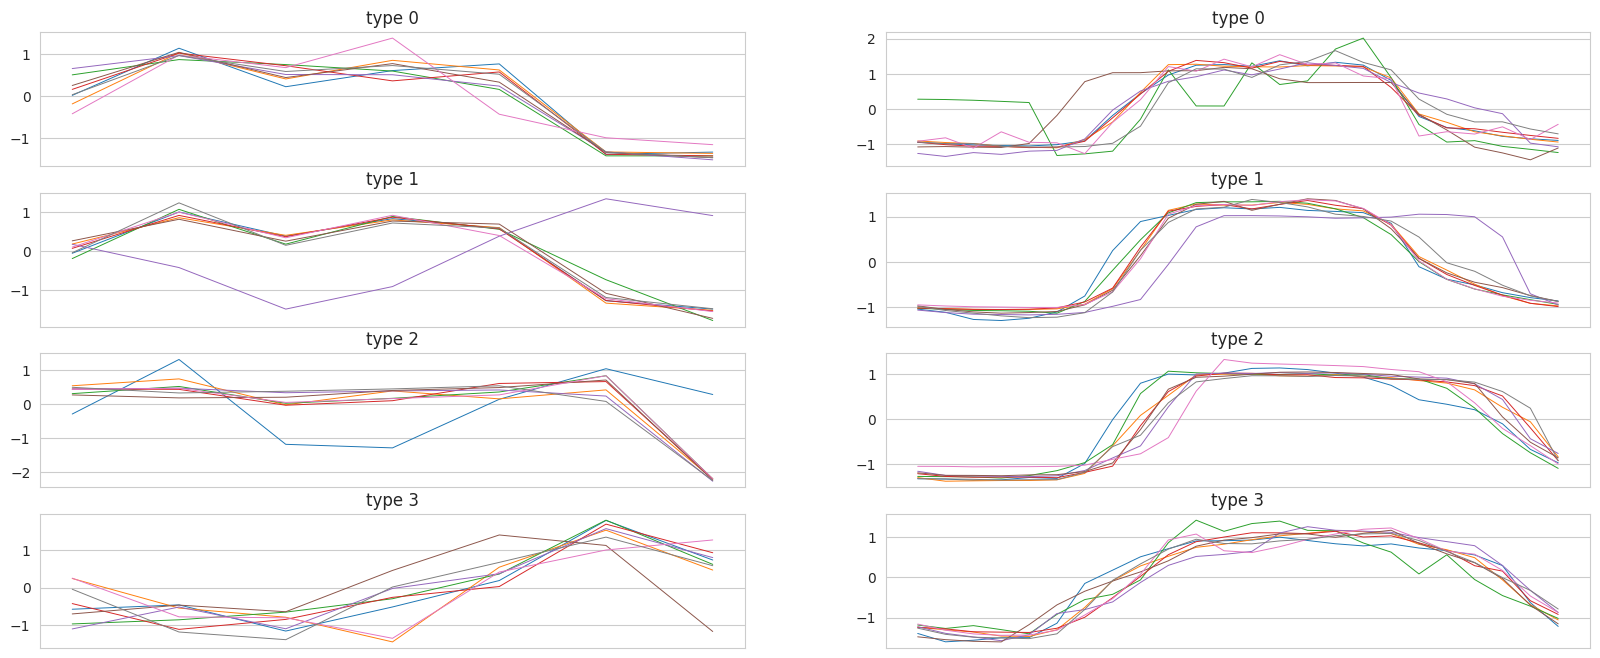

In [578]:
# visualizing result of building type
num_type = len(np.unique(df_type['건물유형']))

fig = plt.figure(figsize = (20,8))
for t in range(num_type):
    temp = df_type[df_type['건물유형'] == t]
    plt.subplot(num_type,2,2*t+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, ) # 요일별
        plt.title(f'type {t}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(num_type,2,2*t+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-1], linewidth=0.7) # 시간대별
        plt.title(f'type {t}')
        plt.xlabel('')
        plt.xticks([])

In [579]:
eda_df = eda_df.merge(df_type[['num','건물유형']], on = 'num', how = 'left')
eda_df

target    num_date_time  num           date_time    기온  강수량   풍속  \
0      3269.10   69_20220601 00   69 2022-06-01 00:00:00  18.6  0.0  0.9   
1      3201.00   69_20220601 01   69 2022-06-01 01:00:00  18.0  0.0  1.1   
2      3191.10   69_20220601 02   69 2022-06-01 02:00:00  17.7  0.0  1.5   
3      3191.70   69_20220601 03   69 2022-06-01 03:00:00  16.7  0.0  1.4   
4      3184.80   69_20220601 04   69 2022-06-01 04:00:00  18.4  0.0  2.8   
...        ...              ...  ...                 ...   ...  ...  ...   
65275   881.04  100_20220824 19  100 2022-08-24 19:00:00  23.1  0.0  0.9   
65276   798.96  100_20220824 20  100 2022-08-24 20:00:00  22.4  0.0  1.3   
65277   825.12  100_20220824 21  100 2022-08-24 21:00:00  21.3  0.0  1.0   
65278   640.08  100_20220824 22  100 2022-08-24 22:00:00  21.0  0.0  0.3   
65279   540.24  100_20220824 23  100 2022-08-24 23:00:00  20.7  0.0  0.1   

         습도   일조   일사  hour  weekday        date  day  month  weekend  \
0      42.0  0.0  0.0     0        2  2022-06-01    1      6        0   
1      45.0  0.0  0.0     1        2  2022-06-01    1      6        0   
2      45.0  0.0  0.0     2        2  2022-06-01    1      6        0   
3      48.0  0.0  0.0     3        2  2022-06-01    1      6        0   
4      43.0  0.0  0.0     4        2  2022-06-01    1      6        0   
...     ...  ...  ...   ...      ...         ...  ...    ...      ...   
65275  86.0  0.5  0.0    19        2  2022-08-24   24      8        0   
65276  86.0  0.0  0.0    20        2  2022-08-24   24      8        0   
65277  92.0  0.0  0.0    21        2  2022-08-24   24      8        0   
65278  94.0  0.0  0.0    22        2  2022-08-24   24      8        0   
65279  95.0  0.0  0.0    23        2  2022-08-24   24      8        0   

       km_cluster  건물유형  
0               1     0  
1               1     0  
2               1     0  
3               1     0  
4               1     0  
...           ...   ...  
65275           3     3  
65276           3     3  
65277           3     3  
65278           3     3  
65279           3     3  

[65280 rows x 18 columns]

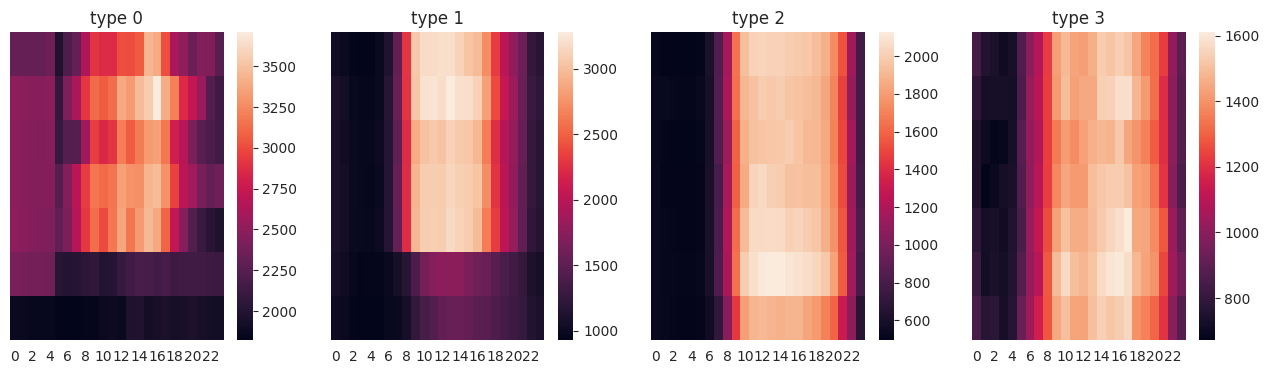

In [580]:
fig = plt.figure(figsize = (20, 4))
for t in np.unique(df_type['건물유형']):
    temp = eda_df[eda_df['건물유형'] == t]
    temp = temp.groupby(['weekday', 'hour'])['target'].median().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(1, 5, t+1)
    sns.heatmap(temp)
    plt.title(f'type {t}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

```
'연구소': 0, '지식산업센터': 1, '할인마트': 2, '호텔및리조트': 3
```

In [581]:
# dictionary mapping type and building
match = df_type[['num','건물유형']]
type2num = {0:[],1:[],2:[],3:[]}
for i in range(32):
    t = match.iloc[i,1]
    type2num[t].append(68+i+1)
type2num

{0: [69, 70, 71, 72, 73, 74, 75, 76],
 1: [77, 78, 79, 80, 81, 82, 83, 84],
 2: [85, 86, 87, 88, 89, 90, 91, 92],
 3: [93, 94, 95, 96, 97, 98, 99, 100]}

In [582]:
# weekend 컬럼 사용 : 0, 1
# wekkend 컬럼 제거 : 2, 3

### 태양광 시설 보유

In [583]:
eda_df = eda_df.merge(building[['num','태양광보유']], on = 'num', how = 'left')
eda_df

target    num_date_time  num           date_time    기온  강수량   풍속  \
0      3269.10   69_20220601 00   69 2022-06-01 00:00:00  18.6  0.0  0.9   
1      3201.00   69_20220601 01   69 2022-06-01 01:00:00  18.0  0.0  1.1   
2      3191.10   69_20220601 02   69 2022-06-01 02:00:00  17.7  0.0  1.5   
3      3191.70   69_20220601 03   69 2022-06-01 03:00:00  16.7  0.0  1.4   
4      3184.80   69_20220601 04   69 2022-06-01 04:00:00  18.4  0.0  2.8   
...        ...              ...  ...                 ...   ...  ...  ...   
65275   881.04  100_20220824 19  100 2022-08-24 19:00:00  23.1  0.0  0.9   
65276   798.96  100_20220824 20  100 2022-08-24 20:00:00  22.4  0.0  1.3   
65277   825.12  100_20220824 21  100 2022-08-24 21:00:00  21.3  0.0  1.0   
65278   640.08  100_20220824 22  100 2022-08-24 22:00:00  21.0  0.0  0.3   
65279   540.24  100_20220824 23  100 2022-08-24 23:00:00  20.7  0.0  0.1   

         습도   일조   일사  hour  weekday        date  day  month  weekend  \
0      42.0  0.0  0.0     0        2  2022-06-01    1      6        0   
1      45.0  0.0  0.0     1        2  2022-06-01    1      6        0   
2      45.0  0.0  0.0     2        2  2022-06-01    1      6        0   
3      48.0  0.0  0.0     3        2  2022-06-01    1      6        0   
4      43.0  0.0  0.0     4        2  2022-06-01    1      6        0   
...     ...  ...  ...   ...      ...         ...  ...    ...      ...   
65275  86.0  0.5  0.0    19        2  2022-08-24   24      8        0   
65276  86.0  0.0  0.0    20        2  2022-08-24   24      8        0   
65277  92.0  0.0  0.0    21        2  2022-08-24   24      8        0   
65278  94.0  0.0  0.0    22        2  2022-08-24   24      8        0   
65279  95.0  0.0  0.0    23        2  2022-08-24   24      8        0   

       km_cluster  건물유형  태양광보유  
0               1     0      1  
1               1     0      1  
2               1     0      1  
3               1     0      1  
4               1     0      1  
...           ...   ...    ...  
65275           3     3      0  
65276           3     3      0  
65277           3     3      0  
65278           3     3      0  
65279           3     3      0  

[65280 rows x 19 columns]

<Figure size 1500x2500 with 0 Axes>

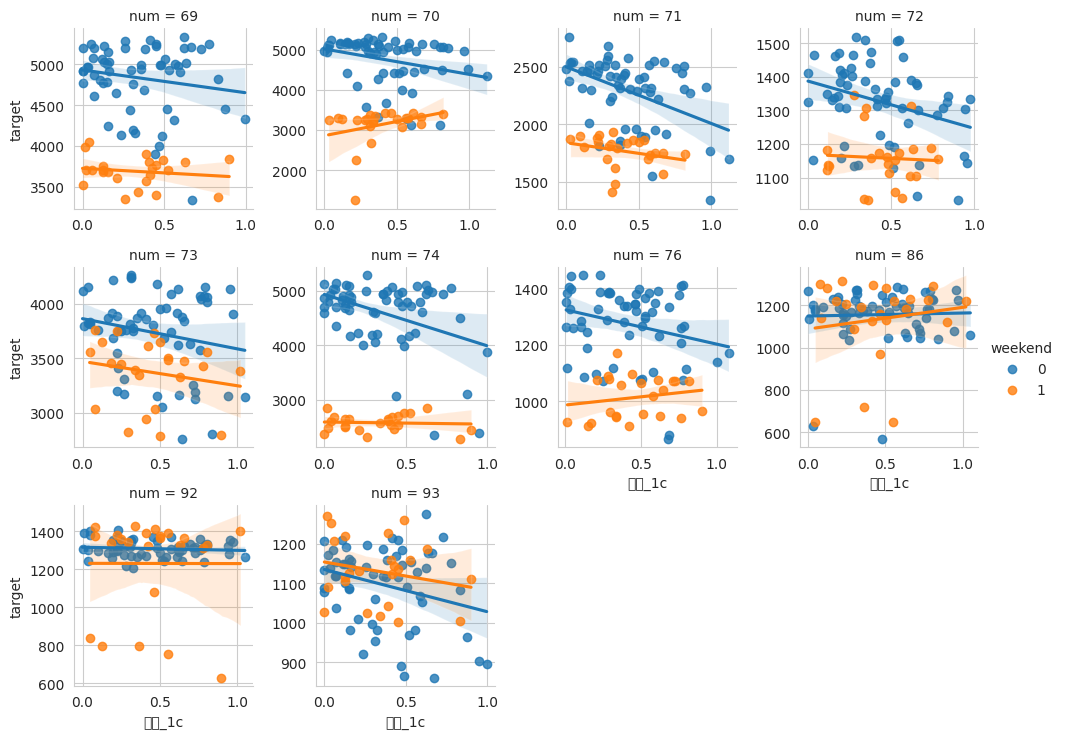

In [584]:
solar_df = eda_df.loc[eda_df['태양광보유'] == 1.0]

df_solar = solar_df.groupby(['num','weekend','date'])['일조','target'].mean().reset_index()
df_solar['일조_1b'] = df_solar['일조'].shift(1)
df_solar['일조_2b'] = df_solar['일조'].shift(2)
df_solar['일조_3b'] = df_solar['일조'].shift(3)
df_solar['일조_1c'] = df_solar['일조'] + df_solar['일조_1b']
df_solar['일조_2c'] = df_solar['일조'] + df_solar['일조_1b'] + df_solar['일조_2b']
df_solar['일조_3c'] = df_solar['일조'] + df_solar['일조_1b'] + df_solar['일조_2b'] + df_solar['일조_3b']

fig = plt.figure(figsize = (15, 25))
sns.lmplot(data = df_solar, x = '일조_1c', y = 'target', hue = 'weekend', col = 'num', height = 2.5, aspect = 1,
          col_wrap = 4, sharey = False, sharex = False)

In [585]:
# 71, 73, 93번 건물에서 전일 일조량과 다음날 전력사용량 간의 뚜렷한 반비례 관계 확인
# 전일 일조량 총합 feature를 추가할 수 있음

In [586]:
# solar_df.groupby(['num','date'])['일조'].sum().reset_index()

In [587]:
# sun_df = solar_df.groupby(['date'])['일조'].sum().reset_index()
# solar_df = solar_df.groupby(['date'])['일사'].sum().reset_index()
# tmp_df = sun_df.merge(solar_df, on = 'date', how = 'left')
# tmp_df

In [588]:
# mean_sun = np.mean(tmp_df['일조'][1:4])
# mean_solar = np.mean(tmp_df['일사'][1:4])

In [589]:
# tmp_df[['일조','일사']] = tmp_df[['일조','일사']].shift(1)
# tmp_df['일조'] = tmp_df['일조'].fillna(mean_sun)
# tmp_df['일사'] = tmp_df['일사'].fillna(mean_solar)
# tmp_df

## corr 확인(cluster)

In [590]:
# cluster 0
df_0 = eda_df[eda_df.km_cluster == 0]
df = df_0.groupby(['num','date'])['기온','강수량','풍속','습도','일조','일사','target'].mean().reset_index()
corrs_0 = []
for num in clust2num[0]:
    corr = []
    corr.append(num)
    for feat in ['기온','강수량','풍속','습도','일조','일사']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_0.append(corr)

In [591]:
# cluster 1
df_1 = eda_df[eda_df.km_cluster == 1]
df = df_1.groupby(['num','date'])['기온','강수량','풍속','습도','일조','일사','target'].mean().reset_index()
corrs_1 = []
for num in clust2num[1]:
    corr = []
    corr.append(num)
    for feat in ['기온','강수량','풍속','습도','일조','일사']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_1.append(corr)

In [592]:
# cluster 2
df_2 = eda_df[eda_df.km_cluster == 2]
df = df_2.groupby(['num','date'])['기온','강수량','풍속','습도','일조','일사','target'].mean().reset_index()
corrs_2 = []
for num in clust2num[2]:
    corr = []
    corr.append(num)
    for feat in ['기온','강수량','풍속','습도','일조','일사']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_2.append(corr)

In [593]:
# cluster 3
df_3 = eda_df[eda_df.km_cluster == 3]
df = df_3.groupby(['num','date'])['기온','강수량','풍속','습도','일조','일사','target'].mean().reset_index()
corrs_3 = []
for num in clust2num[3]:
    corr = []
    corr.append(num)
    for feat in ['기온','강수량','풍속','습도','일조','일사']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_3.append(corr)

In [594]:
corrs_total = [corrs_0, corrs_1, corrs_2, corrs_3]

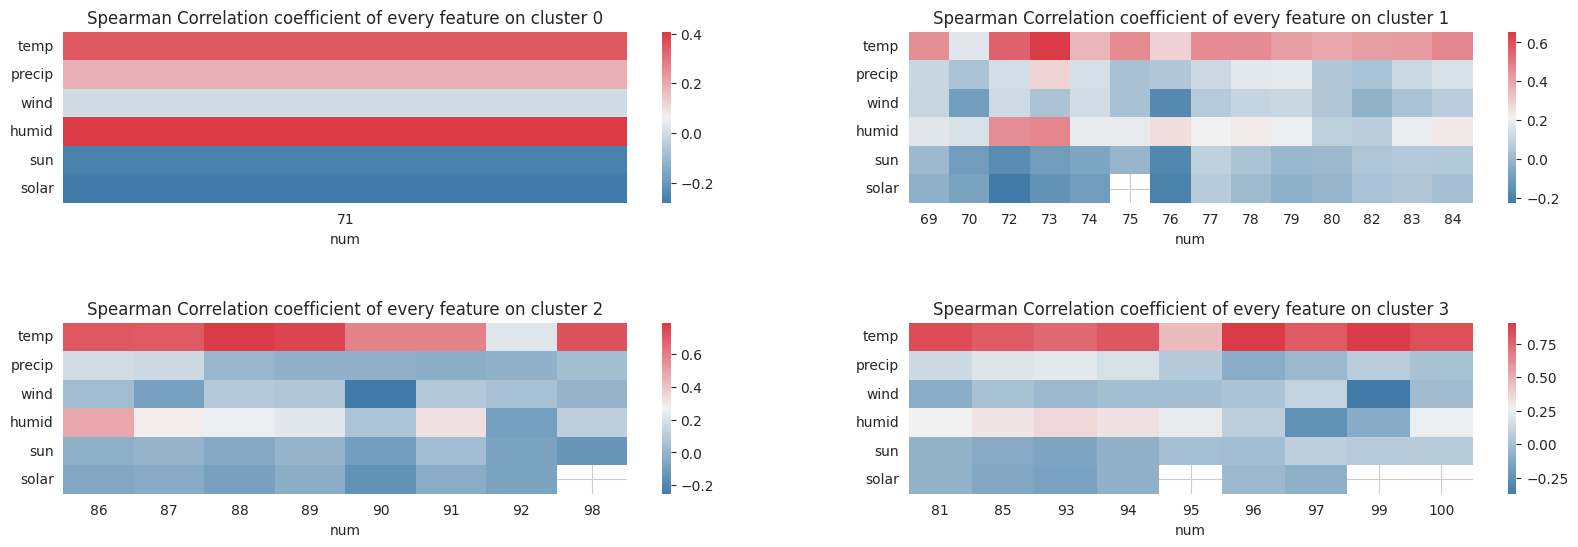

In [595]:
fig = plt.figure(figsize = (20, 6))
for i, corrs in enumerate(corrs_total):
    corr_df = pd.DataFrame(np.array(corrs), columns = ['num','temp','precip','wind','humid','sun','solar'])
    corr_df['num'] = corr_df['num'].astype(int)
    corr_df = corr_df.set_index('num')

    plt.subplot(2,2,i+1)
    sns.heatmap(corr_df.transpose(), cmap=sns.diverging_palette(240,10,as_cmap=True))
    plt.subplots_adjust(hspace = 0.7)
    plt.title(f'Spearman Correlation coefficient of every feature on cluster {i}')

## corr 확인(type)

In [596]:
# type 0
df_0 = eda_df[eda_df['건물유형'] == 0]
df = df_0.groupby(['num','date'])['기온','강수량','풍속','습도','일조','일사','target'].mean().reset_index()
corrs_0 = []
for num in type2num[0]:
    corr = []
    corr.append(num)
    for feat in ['기온','강수량','풍속','습도','일조','일사']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_0.append(corr)

# type 1
df_1 = eda_df[eda_df['건물유형'] == 1]
df = df_1.groupby(['num','date'])['기온','강수량','풍속','습도','일조','일사','target'].mean().reset_index()
corrs_1 = []
for num in type2num[1]:
    corr = []
    corr.append(num)
    for feat in ['기온','강수량','풍속','습도','일조','일사']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_1.append(corr)

# type 2
df_2 = eda_df[eda_df['건물유형'] == 2]
df = df_2.groupby(['num','date'])['기온','강수량','풍속','습도','일조','일사','target'].mean().reset_index()
corrs_2 = []
for num in type2num[2]:
    corr = []
    corr.append(num)
    for feat in ['기온','강수량','풍속','습도','일조','일사']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_2.append(corr)

# type 3
df_3 = eda_df[eda_df['건물유형'] == 3]
df = df_3.groupby(['num','date'])['기온','강수량','풍속','습도','일조','일사','target'].mean().reset_index()
corrs_3 = []
for num in type2num[3]:
    corr = []
    corr.append(num)
    for feat in ['기온','강수량','풍속','습도','일조','일사']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_3.append(corr)

In [597]:
corrs_total = [corrs_0, corrs_1, corrs_2, corrs_3]

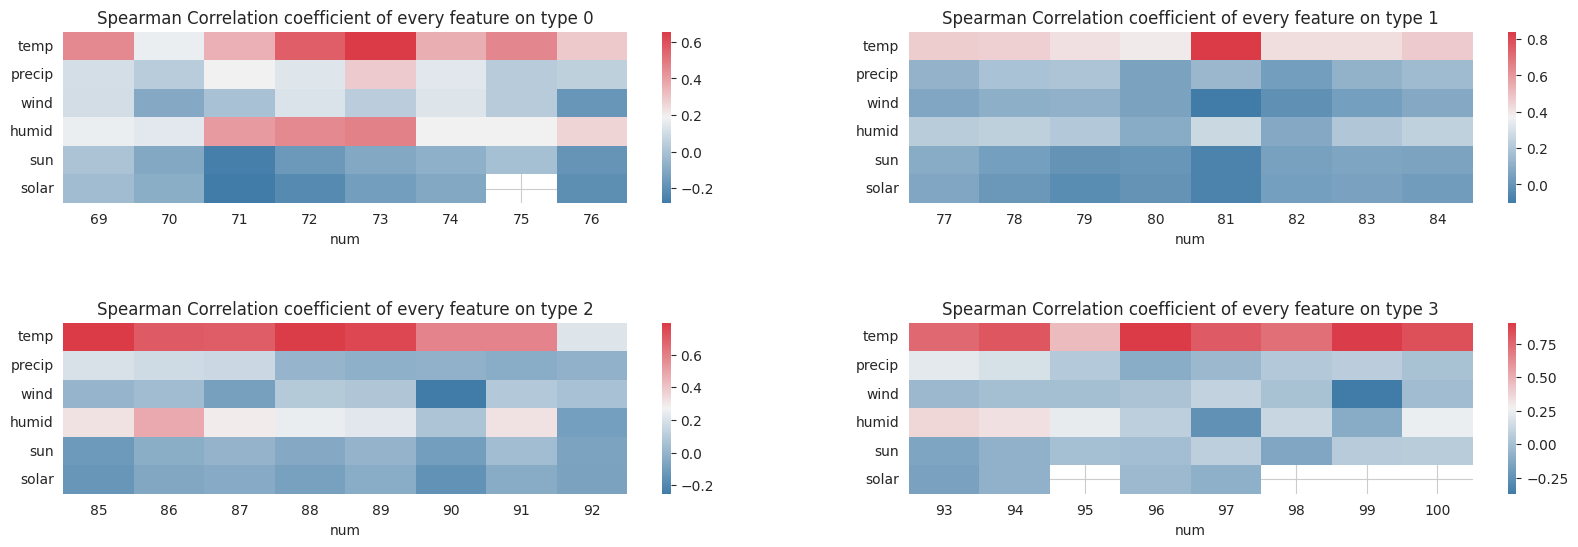

In [598]:
fig = plt.figure(figsize = (20, 6))
for i, corrs in enumerate(corrs_total):
    corr_df = pd.DataFrame(np.array(corrs), columns = ['num','temp','precip','wind','humid','sun','solar'])
    corr_df['num'] = corr_df['num'].astype(int)
    corr_df = corr_df.set_index('num')

    plt.subplot(2,2,i+1)
    sns.heatmap(corr_df.transpose(), cmap=sns.diverging_palette(240,10,as_cmap=True))
    plt.subplots_adjust(hspace = 0.7)
    plt.title(f'Spearman Correlation coefficient of every feature on type {i}')

In [599]:
CDH_num = [69,75,88,89,91,96,97,98,100]
AT_num = [81,87,90,99]
THI_num = [71,72,73,86]

# 피쳐 엔지니어링

- 최저기온 추가

In [616]:
train_ft = train_ft.merge(train_ft.groupby(['num','date'])['기온'].min().reset_index().rename(columns = {'기온':'min_temperature'}), on = ['num','date'], how = 'left')
test_ft = test_ft.merge(test_ft.groupby(['num','date'])['기온'].min().reset_index().rename(columns = {'기온':'min_temperature'}), on = ['num','date'], how = 'left')
train_ft.head()

target   num_date_time  num           date_time    기온  강수량   풍속    습도   일조  \
0  3269.1  69_20220601 00   69 2022-06-01 00:00:00  18.6  0.0  0.9  42.0  0.0   
1  3201.0  69_20220601 01   69 2022-06-01 01:00:00  18.0  0.0  1.1  45.0  0.0   
2  3191.1  69_20220601 02   69 2022-06-01 02:00:00  17.7  0.0  1.5  45.0  0.0   
3  3191.7  69_20220601 03   69 2022-06-01 03:00:00  16.7  0.0  1.4  48.0  0.0   
4  3184.8  69_20220601 04   69 2022-06-01 04:00:00  18.4  0.0  2.8  43.0  0.0   

    일사  ...  건물유형        연면적       냉방면적  태양광용량  ESS저장용량  PCS용량  태양광보유  공휴일  \
0  0.0  ...     0  139928.73  111183.19   14.4      0.0    0.0      1    0   
1  0.0  ...     0  139928.73  111183.19   14.4      0.0    0.0      1    0   
2  0.0  ...     0  139928.73  111183.19   14.4      0.0    0.0      1    0   
3  0.0  ...     0  139928.73  111183.19   14.4      0.0    0.0      1    0   
4  0.0  ...     0  139928.73  111183.19   14.4      0.0    0.0      1    0   

   km_cluster  min_temperature  
0           1             16.3  
1           1             16.3  
2           1             16.3  
3           1             16.3  
4           1             16.3  

[5 rows x 26 columns]

- 건물번호별 df 생성

In [1039]:
def define_df(df, num):
    df = df[df['num'] == num].reset_index(drop=True)
    return df

In [1040]:
for num in range(69,101,1):
    globals()[f'train_ft_{num}'] = define_df(train_ft, num)
    globals()[f'test_ft_{num}'] = define_df(test_ft, num)

- 군집별 사용시간 피쳐 추가

In [1041]:
clust2num

{0: [71],
 1: [69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84],
 2: [86, 87, 88, 89, 90, 91, 92, 98],
 3: [81, 85, 93, 94, 95, 96, 97, 99, 100]}

In [1042]:
# cluster 0 : pass

# cluster 1
# train_ft['사용시간'] = np.where((train_ft['hour'] >= 7) & (train_ft['hour'] <= 20) & (train_ft['weekday'].isin([0,1,2,3,4]), 1, 0))

# # cluster 2
# train_ft['사용시간'] = np.where((train_ft['hour'] >= 7) & (train_ft['hour'] <= 22), 1, 0)

# # cluster 3
# train_ft['사용시간'] = np.where((train_ft['hour'] >= 5) & (train_ft['hour'] <= 23), 1, 0)

In [1043]:
[f"train_ft_{n}" for n in clust2num[3]]

['train_ft_81',
 'train_ft_85',
 'train_ft_93',
 'train_ft_94',
 'train_ft_95',
 'train_ft_96',
 'train_ft_97',
 'train_ft_99',
 'train_ft_100']

In [1044]:
dataframes = [train_ft_69, train_ft_70, train_ft_72, train_ft_73, train_ft_74, train_ft_75, train_ft_76, train_ft_77, train_ft_78, train_ft_79, train_ft_80, train_ft_82, train_ft_83, train_ft_84]

for dataframe in dataframes:
    mask = (dataframe['hour'] >= 7) & (dataframe['hour'] <= 20) & (dataframe['weekday'].isin([0,1,2,3,4]))
    dataframe['사용시간'] = np.where(mask, 1, 0)

In [1045]:
dataframes = [train_ft_86, train_ft_87, train_ft_88, train_ft_89, train_ft_90, train_ft_91, train_ft_92, train_ft_98]

for dataframe in dataframes:
    mask = (dataframe['hour'] >= 7) & (dataframe['hour'] <= 22)
    dataframe['사용시간'] = np.where(mask, 1, 0)

In [1046]:
dataframes = [train_ft_81, train_ft_85, train_ft_93, train_ft_94, train_ft_95, train_ft_96, train_ft_97, train_ft_99, train_ft_100]

for dataframe in dataframes:
    mask = (dataframe['hour'] >= 5) & (dataframe['hour'] <= 23)
    dataframe['사용시간'] = np.where(mask, 1, 0)

- 냉방도일 추가

In [1047]:
# 냉방도일 CDH(cooling degree hour)
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return ys

In [1048]:
dataframes = [train_ft_69,train_ft_75,train_ft_88,train_ft_89,train_ft_91,train_ft_96,train_ft_97,train_ft_98,train_ft_100]

for dataframe in dataframes:
    dataframe['CDH'] = CDH(dataframe['기온'].values)

- 체감온도 추가

In [1049]:
dataframes = [train_ft_81,train_ft_87,train_ft_90,train_ft_99]

for dataframe in dataframes:
    dataframe['AT'] = 37.9 + 0.33 * dataframe['기온'] - 37.9 * (dataframe['풍속'] ** 0.16)

- 불쾌지수 추가

In [1050]:
dataframes = [train_ft_71,train_ft_72,train_ft_73,train_ft_86]

for dataframe in dataframes:
    dataframe['THI'] = 9/5*dataframe['기온'] - 0.55*(1-dataframe['풍속']/100)*(9/5*dataframe['기온']-26)+32

- test 데이터 적용

In [1051]:
# cluster 1
dataframes = [test_ft_69, test_ft_70, test_ft_72, test_ft_73, test_ft_74, test_ft_75, test_ft_76, test_ft_77, test_ft_78, test_ft_79, test_ft_80, test_ft_82, test_ft_83, test_ft_84]
for dataframe in dataframes:
    mask = (dataframe['hour'] >= 7) & (dataframe['hour'] <= 20) & (dataframe['weekday'].isin([0,1,2,3,4]))
    dataframe['사용시간'] = np.where(mask, 1, 0)

# cluster 2
dataframes = [test_ft_86, test_ft_87, test_ft_88, test_ft_89, test_ft_90, test_ft_91, test_ft_92, test_ft_98]
for dataframe in dataframes:
    mask = (dataframe['hour'] >= 7) & (dataframe['hour'] <= 22)
    dataframe['사용시간'] = np.where(mask, 1, 0)

# cluster 3
dataframes = [test_ft_81, test_ft_85, test_ft_93, test_ft_94, test_ft_95, test_ft_96, test_ft_97, test_ft_99, test_ft_100]
for dataframe in dataframes:
    mask = (dataframe['hour'] >= 5) & (dataframe['hour'] <= 23)
    dataframe['사용시간'] = np.where(mask, 1, 0)

# CDH
dataframes = [test_ft_69,test_ft_75,test_ft_88,test_ft_89,test_ft_91,test_ft_96,test_ft_97,test_ft_98,test_ft_100]
for dataframe in dataframes:
    dataframe['CDH'] = CDH(dataframe['기온'].values)

# AT
dataframes = [test_ft_81,test_ft_87,test_ft_90,test_ft_99]
for dataframe in dataframes:
    dataframe['AT'] = 37.9 + 0.33 * dataframe['기온'] - 37.9 * (dataframe['풍속'] ** 0.16)

# THI
dataframes = [test_ft_71,test_ft_72,test_ft_73,test_ft_86]
for dataframe in dataframes:
    dataframe['THI'] = 9/5*dataframe['기온'] - 0.55*(1-dataframe['풍속']/100)*(9/5*dataframe['기온']-26)+32

# 건물별 모델링

## 69

In [1052]:
train_ft_69.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간', 'CDH'],
      dtype='object')

- 불필요 컬럼 제거

In [1053]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

train_ft_69 = train_ft_69.drop(columns=drop_cols)
train_ft_69.head()

target    기온  강수량   풍속    습도  hour  weekday  month  weekend  공휴일  \
0  3269.1  18.6  0.0  0.9  42.0     0        2      6        0    0   
1  3201.0  18.0  0.0  1.1  45.0     1        2      6        0    0   
2  3191.1  17.7  0.0  1.5  45.0     2        2      6        0    0   
3  3191.7  16.7  0.0  1.4  48.0     3        2      6        0    0   
4  3184.8  18.4  0.0  2.8  43.0     4        2      6        0    0   

   min_temperature  사용시간   CDH  
0             16.3     0  -7.4  
1             16.3     0 -15.4  
2             16.3     0 -23.7  
3             16.3     0 -33.0  
4             16.3     0 -40.6

In [1054]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

test_ft_69 = test_ft_69.drop(columns=drop_cols)
test_ft_69.head()

기온  강수량   풍속  습도  hour  weekday  month  weekend  공휴일  min_temperature  \
0  23.5  0.0  2.2  72     0        3      8        0    1             21.2   
1  23.0  0.0  0.9  72     1        3      8        0    1             21.2   
2  22.7  0.0  1.5  75     2        3      8        0    1             21.2   
3  22.1  0.0  1.3  78     3        3      8        0    1             21.2   
4  21.8  0.0  1.0  77     4        3      8        0    1             21.2   

   사용시간   CDH  
0     0  -2.5  
1     0  -5.5  
2     0  -8.8  
3     0 -12.7  
4     0 -16.9

- 모델링

In [1055]:
train_x = train_ft_69.iloc[:, 1:]
train_y = train_ft_69['target']

test_x = test_ft_69

In [1056]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 12), (240, 12), (1800,), (240,))

In [1057]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 12
[LightGBM] [Info] Start training from score 4474.258000
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[32]	training's l2: 19386.4	valid_1's l2: 289513


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

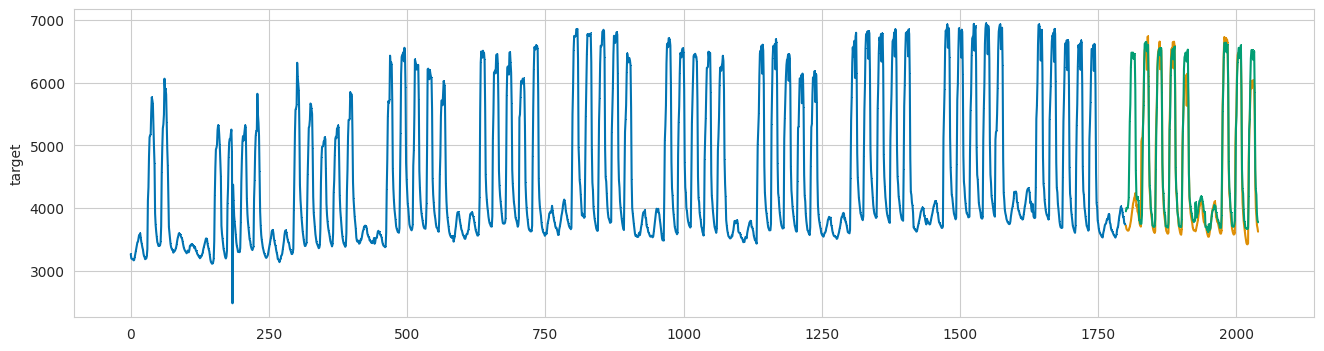

In [1058]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1059]:
_smape(y_valid, x_pred)

2.6580234186989693

In [1060]:
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
y_pred.shape

[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 12
[LightGBM] [Info] Start training from score 4491.791028


(168,)

## 70

In [1061]:
train_ft_70.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간'],
      dtype='object')

- 불필요 컬럼 제거

In [1062]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

train_ft_70 = train_ft_70.drop(columns=drop_cols)
train_ft_70.head()

target    기온  강수량   풍속    습도  hour  weekday  month  weekend  공휴일  \
0  3237.88  18.5  0.0  1.9  38.0     0        2      6        0    0   
1  3212.24  17.8  0.0  1.4  42.0     1        2      6        0    0   
2  3178.80  16.7  0.0  0.7  47.0     2        2      6        0    0   
3  3067.05  16.4  0.0  1.6  51.0     3        2      6        0    0   
4  3031.58  16.3  0.0  1.1  52.0     4        2      6        0    0   

   min_temperature  사용시간  
0             15.5     0  
1             15.5     0  
2             15.5     0  
3             15.5     0  
4             15.5     0

In [1063]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

test_ft_70 = test_ft_70.drop(columns=drop_cols)
test_ft_70.head()

기온  강수량   풍속  습도  hour  weekday  month  weekend  공휴일  min_temperature  \
0  20.7  0.0  1.2  84     0        3      8        0    1             19.0   
1  20.4  0.0  1.3  86     1        3      8        0    1             19.0   
2  20.1  0.0  0.8  88     2        3      8        0    1             19.0   
3  19.9  0.0  0.9  90     3        3      8        0    1             19.0   
4  20.6  0.0  1.6  86     4        3      8        0    1             19.0   

   사용시간  
0     0  
1     0  
2     0  
3     0  
4     0

- 모델링

In [1064]:
train_x = train_ft_70.iloc[:, 1:]
train_y = train_ft_70['target']

test_x = test_ft_70

In [1065]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1066]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 438
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 4260.255441
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[40]	training's l2: 33127.8	valid_1's l2: 84204


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

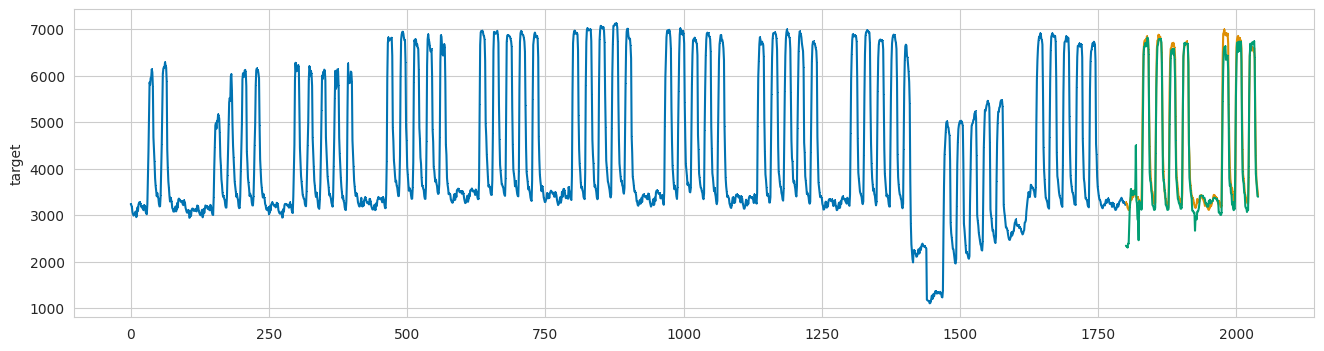

In [1067]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1068]:
_smape(y_valid, x_pred)

2.5029611167596766

In [1069]:
model.fit(train_x, train_y)
pred = np.concatenate((y_pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 443
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 4289.986327


(336,)

## 71(역시 이놈이 문제)

In [1070]:
train_ft_71.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', 'THI'],
      dtype='object')

- 불필요 컬럼 제거

In [1071]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

train_ft_71 = train_ft_71.drop(columns=drop_cols)
train_ft_71.head()

target    기온  강수량   풍속    습도  hour  weekday  month  weekend  공휴일  \
0  1384.56  18.5  0.0  1.9  38.0     0        2      6        0    0   
1  1378.80  17.8  0.0  1.4  42.0     1        2      6        0    0   
2  1381.92  16.7  0.0  0.7  47.0     2        2      6        0    0   
3  1356.72  16.4  0.0  1.6  51.0     3        2      6        0    0   
4  1363.20  16.3  0.0  1.1  52.0     4        2      6        0    0   

   min_temperature        THI  
0             15.5  61.361285  
1             15.5  60.764508  
2             15.5  59.842631  
3             15.5  59.614976  
4             15.5  59.523207

In [1072]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

test_ft_71 = test_ft_71.drop(columns=drop_cols)
test_ft_71.head()

기온  강수량   풍속  습도  hour  weekday  month  weekend  공휴일  min_temperature  \
0  20.7  0.0  1.2  84     0        3      8        0    1             19.0   
1  20.4  0.0  1.3  86     1        3      8        0    1             19.0   
2  20.1  0.0  0.8  88     2        3      8        0    1             19.0   
3  19.9  0.0  0.9  90     3        3      8        0    1             19.0   
4  20.6  0.0  1.6  86     4        3      8        0    1             19.0   

         THI  
0  63.141316  
1  62.900648  
2  62.625792  
3  62.467609  
4  63.083504

- 모델링

In [1073]:
train_x = train_ft_71.iloc[:, 1:]
train_y = train_ft_71['target']

test_x = test_ft_71

In [1074]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1075]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 2122.719884
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[14]	training's l2: 33186.8	valid_1's l2: 99978.4


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

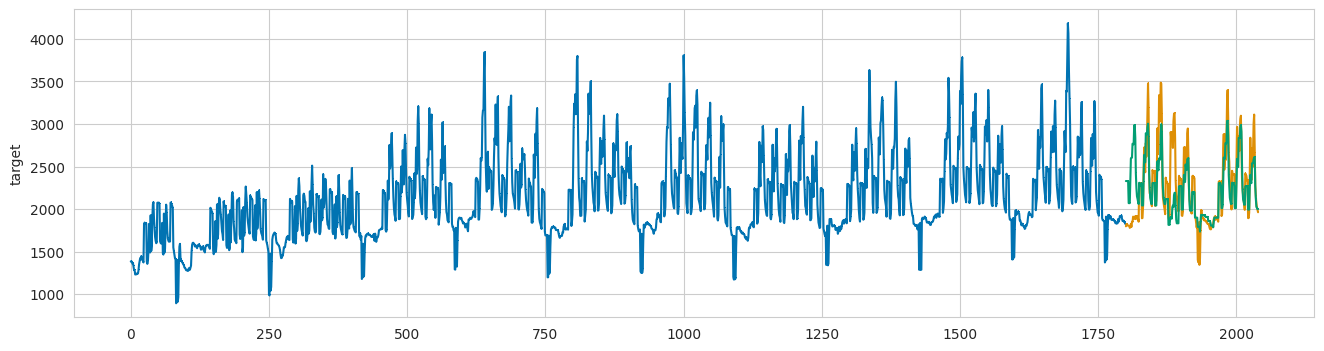

In [1076]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1077]:
_smape(y_valid, x_pred)

4.336945292487301

In [1078]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 2140.043780


(504,)

## 72

In [1079]:
train_ft_72.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간', 'THI'],
      dtype='object')

- 불필요 컬럼 제거

In [1080]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

train_ft_72 = train_ft_72.drop(columns=drop_cols)
train_ft_72.head()

target    기온  강수량   풍속    습도  hour  weekday  month  weekend  공휴일  \
0  1037.16  20.3  0.0  0.1  52.0     0        2      6        0    0   
1  1021.50  19.5  0.0  0.5  55.0     1        2      6        0    0   
2  1011.96  19.4  0.0  1.0  53.0     2        2      6        0    0   
3  1020.60  18.8  0.0  0.0  56.0     3        2      6        0    0   
4  1020.78  18.3  0.0  0.0  70.0     4        2      6        0    0   

   min_temperature  사용시간        THI  
0             18.1     0  62.748797  
1             18.1     0  62.120025  
2             18.1     0  62.063060  
3             18.1     0  61.528000  
4             18.1     0  61.123000

In [1081]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

test_ft_72 = test_ft_72.drop(columns=drop_cols)
test_ft_72.head()

기온  강수량   풍속  습도  hour  weekday  month  weekend  공휴일  min_temperature  \
0  23.6  0.0  0.7  94     0        3      8        0    1             22.0   
1  23.3  0.0  1.8  96     1        3      8        0    1             22.0   
2  22.9  0.0  1.2  97     2        3      8        0    1             22.0   
3  23.0  0.0  1.1  98     3        3      8        0    1             22.0   
4  22.7  0.0  1.1  99     4        3      8        0    1             22.0   

   사용시간        THI  
0     0  65.479448  
1     0  65.330806  
2     0  64.949452  
3     0  65.023170  
4     0  64.776903

- 모델링

In [1082]:
train_x = train_ft_72.iloc[:, 1:]
train_y = train_ft_72['target']

test_x = test_ft_72

In [1083]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 12), (240, 12), (1800,), (240,))

In [1084]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 662
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 12
[LightGBM] [Info] Start training from score 1265.439401
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[14]	training's l2: 3227.43	valid_1's l2: 20240.6


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

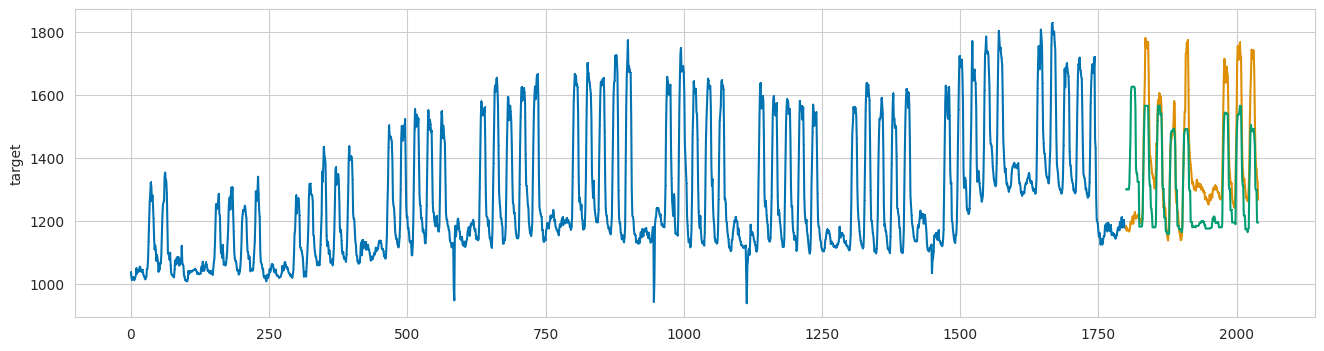

In [1085]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1086]:
_smape(y_valid, x_pred)

4.146684618876397

In [1087]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 12
[LightGBM] [Info] Start training from score 1278.976766


(672,)

## 73

In [1088]:
train_ft_73.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간', 'THI'],
      dtype='object')

- 불필요 컬럼 제거

In [1089]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

train_ft_73 = train_ft_73.drop(columns=drop_cols)
train_ft_73.head()

target    기온  강수량   풍속    습도  hour  weekday  month  weekend  공휴일  \
0  2599.20  17.9  0.0  1.0  48.0     0        2      6        0    0   
1  2589.60  17.7  0.0  1.2  50.0     1        2      6        0    0   
2  2586.24  17.5  0.0  1.7  49.0     2        2      6        0    0   
3  2592.00  15.9  0.0  0.4  54.0     3        2      6        0    0   
4  2668.32  16.6  0.0  2.6  53.0     4        2      6        0    0   

   min_temperature  사용시간        THI  
0             15.9     0  60.833210  
1             15.9     0  60.675676  
2             15.9     0  60.526425  
3             15.9     0  59.184764  
4             15.9     0  59.801484

In [1090]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

test_ft_73 = test_ft_73.drop(columns=drop_cols)
test_ft_73.head()

기온  강수량   풍속  습도  hour  weekday  month  weekend  공휴일  min_temperature  \
0  22.8  0.0  1.1  75     0        3      8        0    1             20.5   
1  22.6  0.0  1.0  75     1        3      8        0    1             20.5   
2  22.2  0.0  1.0  77     2        3      8        0    1             20.5   
3  21.4  0.0  1.0  83     3        3      8        0    1             20.5   
4  21.2  0.0  0.3  85     4        3      8        0    1             20.5   

   사용시간        THI  
0     0  64.858992  
1     0  64.686740  
2     0  64.358780  
3     0  63.702860  
4     0  63.492064

- 모델링

In [1091]:
train_x = train_ft_73.iloc[:, 1:]
train_y = train_ft_73['target']

test_x = test_ft_73

In [1092]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 12), (240, 12), (1800,), (240,))

In [1093]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 703
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 12
[LightGBM] [Info] Start training from score 3605.433332
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[17]	training's l2: 22139.9	valid_1's l2: 56338


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

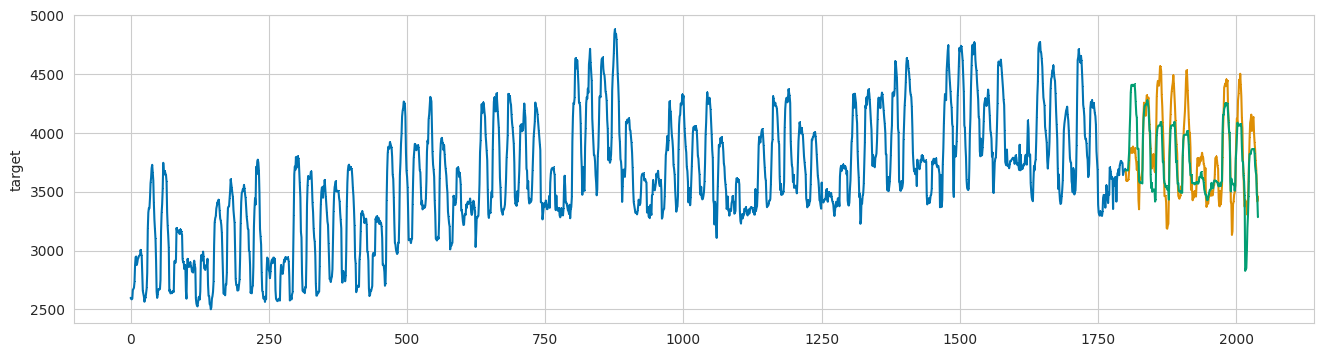

In [1094]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1095]:
_smape(y_valid, x_pred)

2.410021992996539

In [1096]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 12
[LightGBM] [Info] Start training from score 3631.879998


(840,)

## 74

In [1097]:
train_ft_74.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간'],
      dtype='object')

- 불필요 컬럼 제거

In [1098]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

train_ft_74 = train_ft_74.drop(columns=drop_cols)
train_ft_74.head()

target    기온  강수량   풍속    습도  hour  weekday  month  weekend  공휴일  \
0  2925.36  18.6  0.0  0.9  42.0     0        2      6        0    0   
1  2931.12  18.0  0.0  1.1  45.0     1        2      6        0    0   
2  2939.76  17.7  0.0  1.5  45.0     2        2      6        0    0   
3  2887.92  16.7  0.0  1.4  48.0     3        2      6        0    0   
4  2725.20  18.4  0.0  2.8  43.0     4        2      6        0    0   

   min_temperature  사용시간  
0             16.3     0  
1             16.3     0  
2             16.3     0  
3             16.3     0  
4             16.3     0

In [1099]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

test_ft_74 = test_ft_74.drop(columns=drop_cols)
test_ft_74.head()

기온  강수량   풍속  습도  hour  weekday  month  weekend  공휴일  min_temperature  \
0  23.5  0.0  2.2  72     0        3      8        0    1             21.2   
1  23.0  0.0  0.9  72     1        3      8        0    1             21.2   
2  22.7  0.0  1.5  75     2        3      8        0    1             21.2   
3  22.1  0.0  1.3  78     3        3      8        0    1             21.2   
4  21.8  0.0  1.0  77     4        3      8        0    1             21.2   

   사용시간  
0     0  
1     0  
2     0  
3     0  
4     0

- 모델링

In [1100]:
train_x = train_ft_74.iloc[:, 1:]
train_y = train_ft_74['target']

test_x = test_ft_74

In [1101]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1102]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 438
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 3987.537606
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[30]	training's l2: 46066	valid_1's l2: 303715


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

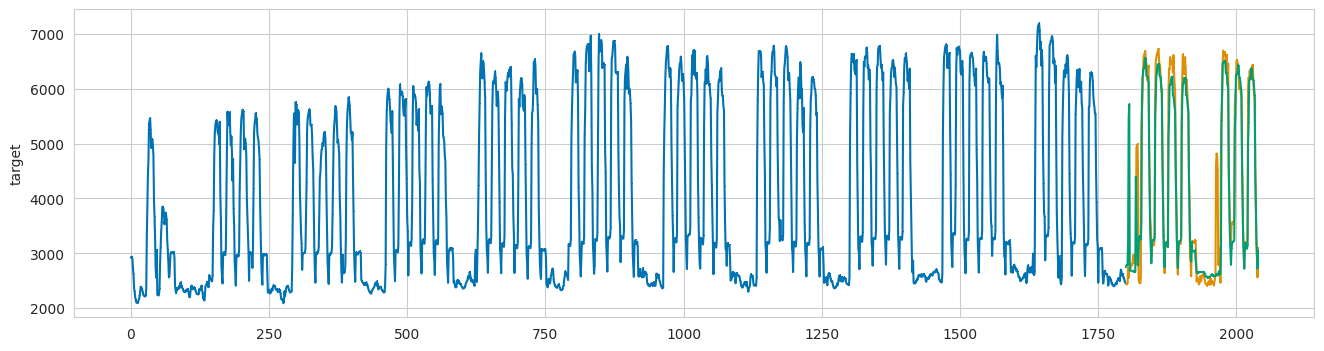

In [1103]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1104]:
_smape(y_valid, x_pred)

3.822918851947943

In [1105]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 447
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 4027.799300


(1008,)

## 75

In [1106]:
train_ft_75.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간', 'CDH'],
      dtype='object')

- 불필요 컬럼 제거

In [1107]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

train_ft_75 = train_ft_75.drop(columns=drop_cols)
train_ft_75.head()

target    기온  강수량   풍속    습도  hour  weekday  month  weekend  공휴일  \
0  1062.60  15.7  0.0  0.1  68.0     0        2      6        0    0   
1  1085.04  15.1  0.0  0.3  71.0     1        2      6        0    0   
2  1018.20  14.6  0.0  0.3  69.0     2        2      6        0    0   
3  1093.68  14.4  0.0  0.3  68.0     3        2      6        0    0   
4  1033.20  14.2  0.0  0.0  68.0     4        2      6        0    0   

   min_temperature  사용시간   CDH  
0             14.2     0 -10.3  
1             14.2     0 -21.2  
2             14.2     0 -32.6  
3             14.2     0 -44.2  
4             14.2     0 -56.0

In [1108]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

test_ft_75 = test_ft_75.drop(columns=drop_cols)
test_ft_75.head()

기온  강수량   풍속  습도  hour  weekday  month  weekend  공휴일  min_temperature  \
0  21.3  0.0  0.0  97     0        3      8        0    1             20.3   
1  20.9  0.0  0.3  99     1        3      8        0    1             20.3   
2  21.0  0.0  0.0  99     2        3      8        0    1             20.3   
3  20.6  0.0  0.2  99     3        3      8        0    1             20.3   
4  20.6  0.0  0.0  99     4        3      8        0    1             20.3   

   사용시간   CDH  
0     0  -4.7  
1     0  -9.8  
2     0 -14.8  
3     0 -20.2  
4     0 -25.6

- 모델링

In [1109]:
train_x = train_ft_75.iloc[:, 1:]
train_y = train_ft_75['target']

test_x = test_ft_75

In [1110]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 12), (240, 12), (1800,), (240,))

In [1111]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 12
[LightGBM] [Info] Start training from score 1402.223332
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[24]	training's l2: 12582.6	valid_1's l2: 29521.5


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

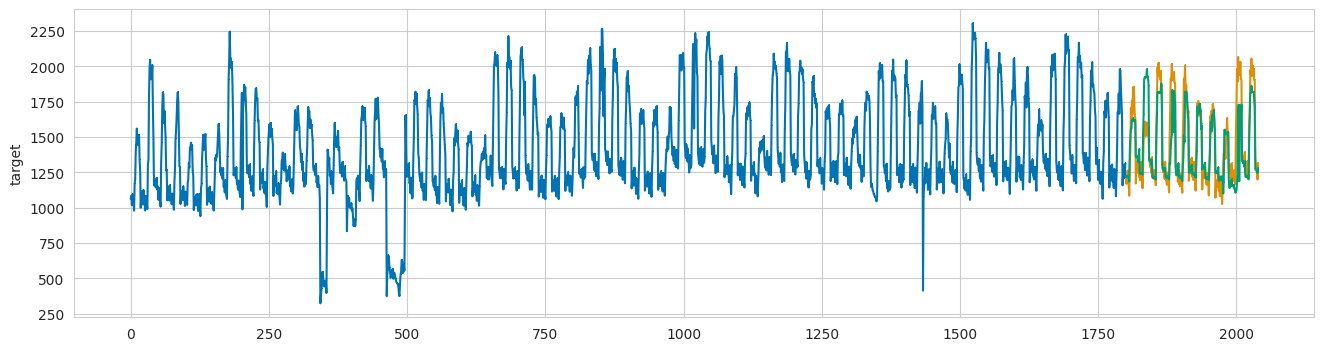

In [1112]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1113]:
_smape(y_valid, x_pred)

3.5915441350999986

In [1114]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 12
[LightGBM] [Info] Start training from score 1408.176470


(1176,)

## 76

In [1115]:
train_ft_76.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간'],
      dtype='object')

- 불필요 컬럼 제거

In [1116]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

train_ft_76 = train_ft_76.drop(columns=drop_cols)
train_ft_76.head()

target    기온  강수량   풍속    습도  hour  weekday  month  weekend  공휴일  \
0  953.28  20.0  0.0  0.8  42.0     0        2      6        0    0   
1  920.34  20.0  0.0  0.4  44.0     1        2      6        0    0   
2  911.34  20.2  0.0  0.7  41.0     2        2      6        0    0   
3  924.48  19.2  0.0  1.1  48.0     3        2      6        0    0   
4  878.58  19.2  0.0  0.6  47.0     4        2      6        0    0   

   min_temperature  사용시간  
0             18.9     0  
1             18.9     0  
2             18.9     0  
3             18.9     0  
4             18.9     0

In [1117]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

test_ft_76 = test_ft_76.drop(columns=drop_cols)
test_ft_76.head()

기온  강수량   풍속  습도  hour  weekday  month  weekend  공휴일  min_temperature  \
0  20.3  0.0  0.0  93     0        3      8        0    1             19.5   
1  20.3  0.0  0.0  95     1        3      8        0    1             19.5   
2  20.5  0.0  0.0  95     2        3      8        0    1             19.5   
3  20.2  0.0  0.6  96     3        3      8        0    1             19.5   
4  19.7  0.0  0.8  97     4        3      8        0    1             19.5   

   사용시간  
0     0  
1     0  
2     0  
3     0  
4     0

- 모델링

In [1118]:
train_x = train_ft_76.iloc[:, 1:]
train_y = train_ft_76['target']

test_x = test_ft_76

In [1119]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1120]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 1191.884201
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[15]	training's l2: 5509.62	valid_1's l2: 18248.4


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

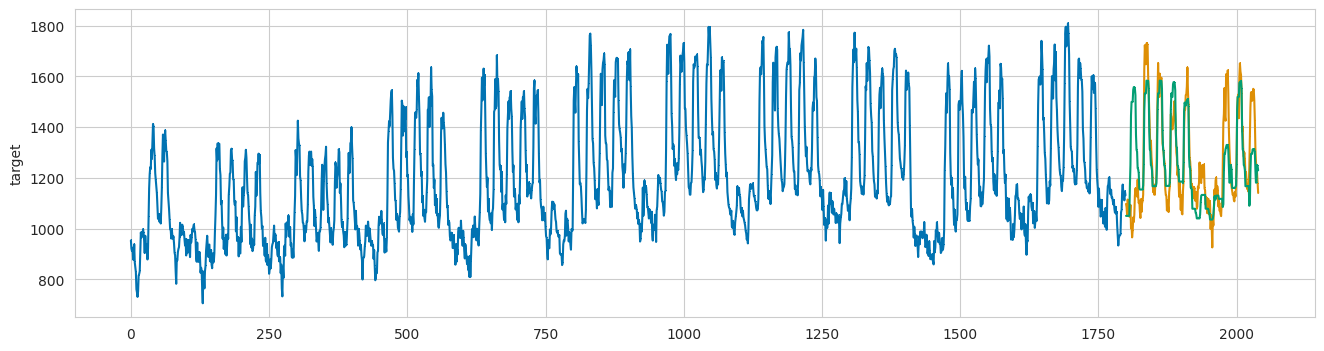

In [1121]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1122]:
_smape(y_valid, x_pred)

3.457875433743373

In [1123]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 1200.375795


(1344,)

## 77

In [1124]:
train_ft_77.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간'],
      dtype='object')

- 불필요 컬럼 제거

In [1125]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

train_ft_77 = train_ft_77.drop(columns=drop_cols)
train_ft_77.head()

target    기온  강수량   풍속    습도  hour  weekday  month  weekend  공휴일  \
0  954.00  17.9  0.0  1.0  48.0     0        2      6        0    0   
1  934.56  17.7  0.0  1.2  50.0     1        2      6        0    0   
2  873.72  17.5  0.0  1.7  49.0     2        2      6        0    0   
3  865.80  15.9  0.0  0.4  54.0     3        2      6        0    0   
4  887.40  16.6  0.0  2.6  53.0     4        2      6        0    0   

   min_temperature  사용시간  
0             15.9     0  
1             15.9     0  
2             15.9     0  
3             15.9     0  
4             15.9     0

In [1126]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

test_ft_77 = test_ft_77.drop(columns=drop_cols)
test_ft_77.head()

기온  강수량   풍속  습도  hour  weekday  month  weekend  공휴일  min_temperature  \
0  22.8  0.0  1.1  75     0        3      8        0    1             20.5   
1  22.6  0.0  1.0  75     1        3      8        0    1             20.5   
2  22.2  0.0  1.0  77     2        3      8        0    1             20.5   
3  21.4  0.0  1.0  83     3        3      8        0    1             20.5   
4  21.2  0.0  0.3  85     4        3      8        0    1             20.5   

   사용시간  
0     0  
1     0  
2     0  
3     0  
4     0

- 모델링

In [1127]:
train_x = train_ft_77.iloc[:, 1:]
train_y = train_ft_77['target']

test_x = test_ft_77

In [1128]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1129]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 1478.102002
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[69]	training's l2: 1012.07	valid_1's l2: 5087.4


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

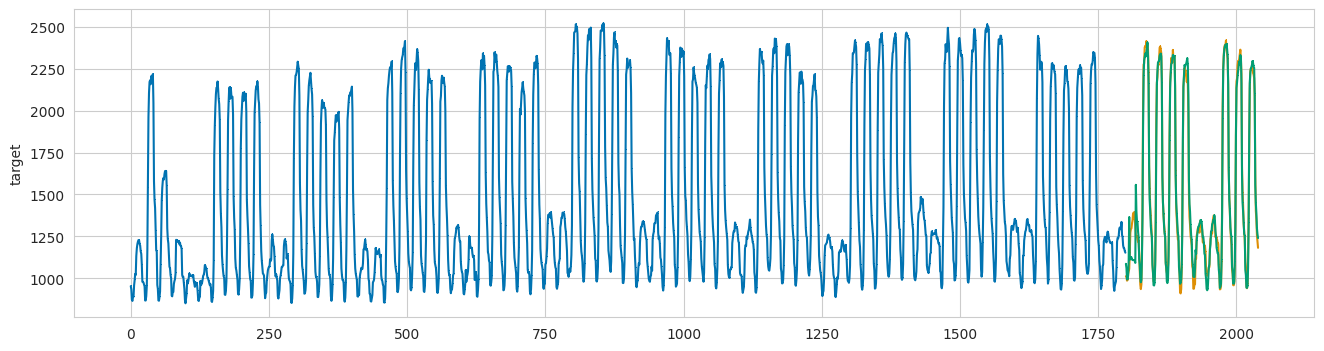

In [1130]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1131]:
_smape(y_valid, x_pred)

1.7371363578640813

In [1132]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 456
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 1485.077648


(1512,)

## 78

In [1133]:
train_ft_78.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간'],
      dtype='object')

- 불필요 컬럼 제거

In [1134]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

train_ft_78 = train_ft_78.drop(columns=drop_cols)
train_ft_78.head()

target    기온  강수량   풍속    습도  hour  weekday  month  weekend  공휴일  \
0  808.32  17.9  0.0  1.0  48.0     0        2      6        0    0   
1  787.20  17.7  0.0  1.2  50.0     1        2      6        0    0   
2  783.36  17.5  0.0  1.7  49.0     2        2      6        0    0   
3  780.00  15.9  0.0  0.4  54.0     3        2      6        0    0   
4  777.12  16.6  0.0  2.6  53.0     4        2      6        0    0   

   min_temperature  사용시간  
0             15.9     0  
1             15.9     0  
2             15.9     0  
3             15.9     0  
4             15.9     0

In [1135]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

test_ft_78 = test_ft_78.drop(columns=drop_cols)
test_ft_78.head()

기온  강수량   풍속  습도  hour  weekday  month  weekend  공휴일  min_temperature  \
0  22.8  0.0  1.1  75     0        3      8        0    1             20.5   
1  22.6  0.0  1.0  75     1        3      8        0    1             20.5   
2  22.2  0.0  1.0  77     2        3      8        0    1             20.5   
3  21.4  0.0  1.0  83     3        3      8        0    1             20.5   
4  21.2  0.0  0.3  85     4        3      8        0    1             20.5   

   사용시간  
0     0  
1     0  
2     0  
3     0  
4     0

- 모델링

In [1136]:
train_x = train_ft_78.iloc[:, 1:]
train_y = train_ft_78['target']

test_x = test_ft_78

In [1137]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1138]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 1633.772132
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[65]	training's l2: 1304.79	valid_1's l2: 23376.9


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

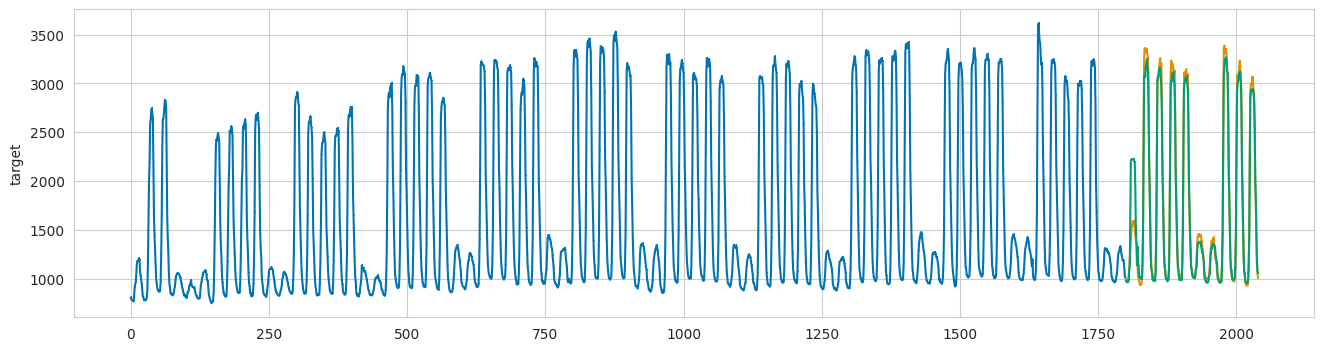

In [1139]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1140]:
_smape(y_valid, x_pred)

2.433714264275778

In [1141]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 456
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 1648.894469


(1680,)

## 79

In [1142]:
train_ft_79.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간'],
      dtype='object')

- 불필요 컬럼 제거

In [1143]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

train_ft_79 = train_ft_79.drop(columns=drop_cols)
train_ft_79.head()

target    기온  강수량   풍속    습도  hour  weekday  month  weekend  공휴일  \
0  1881.12  17.9  0.0  1.0  48.0     0        2      6        0    0   
1  1831.20  17.7  0.0  1.2  50.0     1        2      6        0    0   
2  1808.16  17.5  0.0  1.7  49.0     2        2      6        0    0   
3  1802.40  15.9  0.0  0.4  54.0     3        2      6        0    0   
4  1798.56  16.6  0.0  2.6  53.0     4        2      6        0    0   

   min_temperature  사용시간  
0             15.9     0  
1             15.9     0  
2             15.9     0  
3             15.9     0  
4             15.9     0

In [1144]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

test_ft_79 = test_ft_79.drop(columns=drop_cols)
test_ft_79.head()

기온  강수량   풍속  습도  hour  weekday  month  weekend  공휴일  min_temperature  \
0  22.8  0.0  1.1  75     0        3      8        0    1             20.5   
1  22.6  0.0  1.0  75     1        3      8        0    1             20.5   
2  22.2  0.0  1.0  77     2        3      8        0    1             20.5   
3  21.4  0.0  1.0  83     3        3      8        0    1             20.5   
4  21.2  0.0  0.3  85     4        3      8        0    1             20.5   

   사용시간  
0     0  
1     0  
2     0  
3     0  
4     0

- 모델링

In [1145]:
train_x = train_ft_79.iloc[:, 1:]
train_y = train_ft_79['target']

test_x = test_ft_79

In [1146]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1147]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 443
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 2880.765197
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 2032.82	valid_1's l2: 16254.7


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

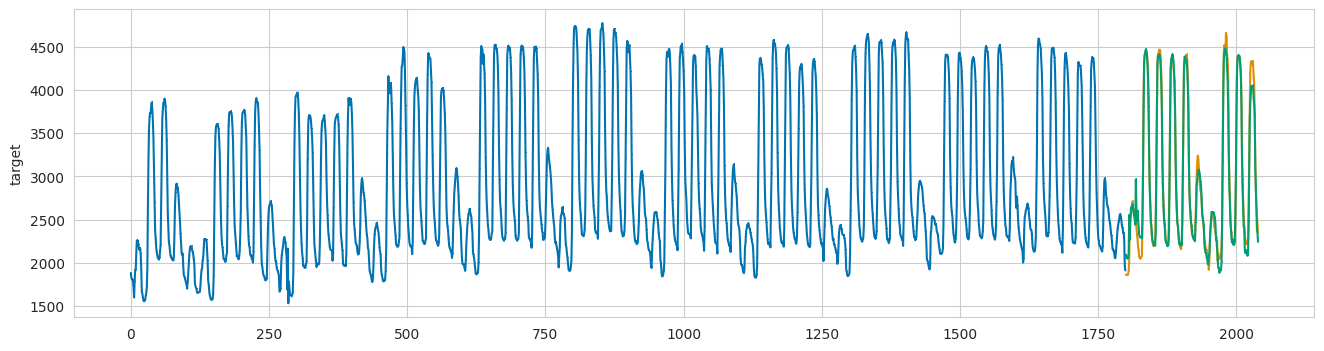

In [1148]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1149]:
_smape(y_valid, x_pred)

1.6646933282842273

In [1150]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 451
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 2892.282939


(1848,)

## 80

In [1151]:
train_ft_80.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간'],
      dtype='object')

- 불필요 컬럼 제거

In [1152]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

train_ft_80 = train_ft_80.drop(columns=drop_cols)
train_ft_80.head()

target    기온  강수량   풍속    습도  hour  weekday  month  weekend  공휴일  \
0  1097.28  18.6  0.0  0.9  42.0     0        2      6        0    0   
1  1082.16  18.0  0.0  1.1  45.0     1        2      6        0    0   
2  1051.92  17.7  0.0  1.5  45.0     2        2      6        0    0   
3  1043.28  16.7  0.0  1.4  48.0     3        2      6        0    0   
4  1055.52  18.4  0.0  2.8  43.0     4        2      6        0    0   

   min_temperature  사용시간  
0             16.3     0  
1             16.3     0  
2             16.3     0  
3             16.3     0  
4             16.3     0

In [1153]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

test_ft_80 = test_ft_80.drop(columns=drop_cols)
test_ft_80.head()

기온  강수량   풍속  습도  hour  weekday  month  weekend  공휴일  min_temperature  \
0  23.5  0.0  2.2  72     0        3      8        0    1             21.2   
1  23.0  0.0  0.9  72     1        3      8        0    1             21.2   
2  22.7  0.0  1.5  75     2        3      8        0    1             21.2   
3  22.1  0.0  1.3  78     3        3      8        0    1             21.2   
4  21.8  0.0  1.0  77     4        3      8        0    1             21.2   

   사용시간  
0     0  
1     0  
2     0  
3     0  
4     0

- 모델링

In [1154]:
train_x = train_ft_80.iloc[:, 1:]
train_y = train_ft_80['target']

test_x = test_ft_80

In [1155]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1156]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 438
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 2524.521398
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[45]	training's l2: 8334.59	valid_1's l2: 94007


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

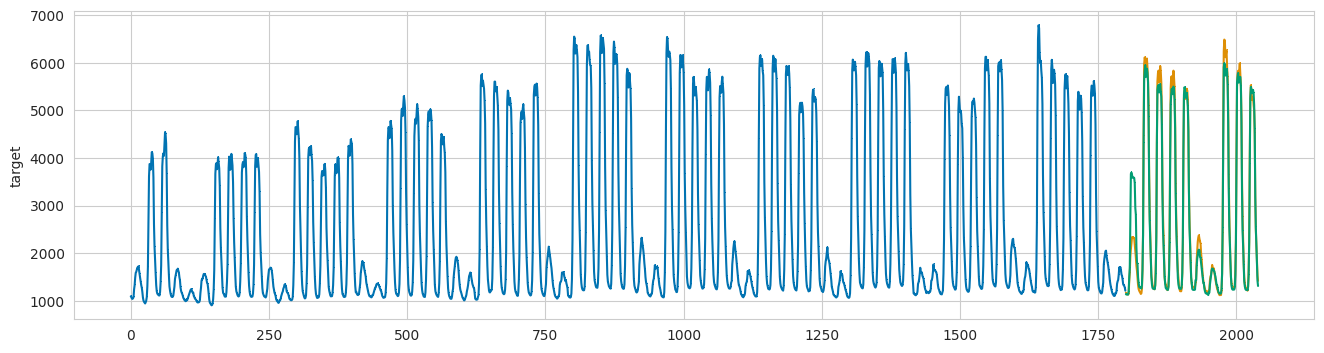

In [1157]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1158]:
_smape(y_valid, x_pred)

3.0374098336669086

In [1159]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 447
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 2556.397939


(2016,)

## 81

In [1160]:
train_ft_81.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간', 'AT'],
      dtype='object')

- 불필요 컬럼 제거

In [1161]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

train_ft_81 = train_ft_81.drop(columns=drop_cols)
train_ft_81.head()

target    기온  강수량   풍속    습도  hour  weekday  month  weekend  공휴일  \
0  504.36  18.6  0.0  0.9  42.0     0        2      6        0    0   
1  473.04  18.0  0.0  1.1  45.0     1        2      6        0    0   
2  448.20  17.7  0.0  1.5  45.0     2        2      6        0    0   
3  417.96  16.7  0.0  1.4  48.0     3        2      6        0    0   
4  415.44  18.4  0.0  2.8  43.0     4        2      6        0    0   

   min_temperature  사용시간        AT  
0             16.3     0  6.771551  
1             16.3     0  5.357610  
2             16.3     0  3.300752  
3             16.3     0  3.414711  
4             16.3     0 -0.715339

In [1162]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

test_ft_81 = test_ft_81.drop(columns=drop_cols)
test_ft_81.head()

기온  강수량   풍속  습도  hour  weekday  month  weekend  공휴일  min_temperature  \
0  23.5  0.0  2.2  72     0        3      8        0    1             21.2   
1  23.0  0.0  0.9  72     1        3      8        0    1             21.2   
2  22.7  0.0  1.5  75     2        3      8        0    1             21.2   
3  22.1  0.0  1.3  78     3        3      8        0    1             21.2   
4  21.8  0.0  1.0  77     4        3      8        0    1             21.2   

   사용시간        AT  
0     0  2.659120  
1     0  8.223551  
2     0  4.950752  
3     0  5.668158  
4     0  7.194000

- 모델링

In [1163]:
train_x = train_ft_81.iloc[:, 1:]
train_y = train_ft_81['target']

test_x = test_ft_81

In [1164]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 12), (240, 12), (1800,), (240,))

In [1165]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 12
[LightGBM] [Info] Start training from score 1436.235999
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[97]	training's l2: 1953.91	valid_1's l2: 4814.13


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

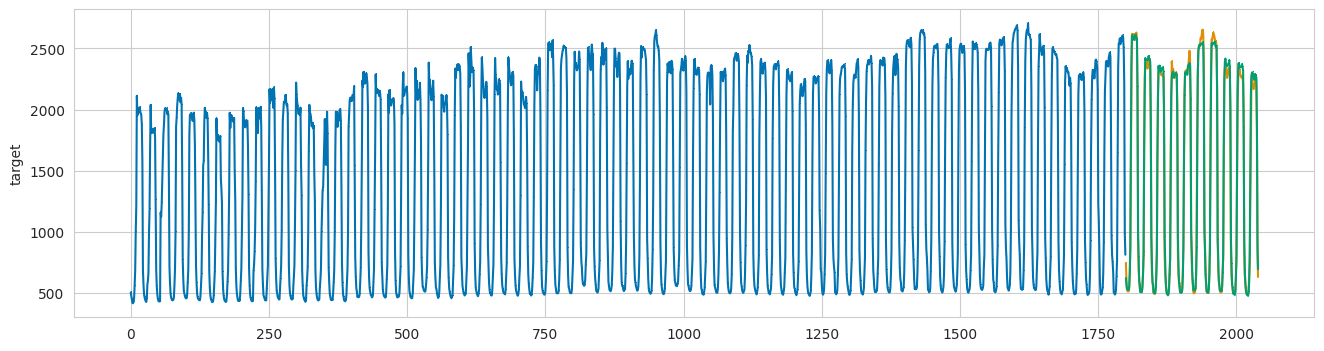

In [1166]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1167]:
_smape(y_valid, x_pred)

1.7062029609337825

In [1168]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 12
[LightGBM] [Info] Start training from score 1446.166058


(2184,)

## 82

In [1169]:
train_ft_82.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간'],
      dtype='object')

- 불필요 컬럼 제거

In [1170]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

train_ft_82 = train_ft_82.drop(columns=drop_cols)
train_ft_82.head()

target    기온  강수량   풍속    습도  hour  weekday  month  weekend  공휴일  \
0  1074.24  18.7  0.0  4.1  44.0     0        2      6        0    0   
1  1009.44  18.1  0.0  4.2  47.0     1        2      6        0    0   
2   954.00  17.8  0.0  3.0  47.0     2        2      6        0    0   
3   939.60  17.8  0.0  3.3  46.0     3        2      6        0    0   
4   956.88  18.0  0.0  1.2  53.0     4        2      6        0    0   

   min_temperature  사용시간  
0             16.7     0  
1             16.7     0  
2             16.7     0  
3             16.7     0  
4             16.7     0

In [1171]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

test_ft_82 = test_ft_82.drop(columns=drop_cols)
test_ft_82.head()

기온  강수량   풍속  습도  hour  weekday  month  weekend  공휴일  min_temperature  \
0  23.5  0.0  1.9  71     0        3      8        0    1             21.4   
1  23.1  0.0  1.9  71     1        3      8        0    1             21.4   
2  22.7  0.0  2.5  73     2        3      8        0    1             21.4   
3  22.4  0.0  2.5  73     3        3      8        0    1             21.4   
4  22.3  0.0  2.4  74     4        3      8        0    1             21.4   

   사용시간  
0     0  
1     0  
2     0  
3     0  
4     0

- 모델링

In [1172]:
train_x = train_ft_82.iloc[:, 1:]
train_y = train_ft_82['target']

test_x = test_ft_82

In [1173]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1174]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 421
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 2264.797998
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[33]	training's l2: 16472.1	valid_1's l2: 219283


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

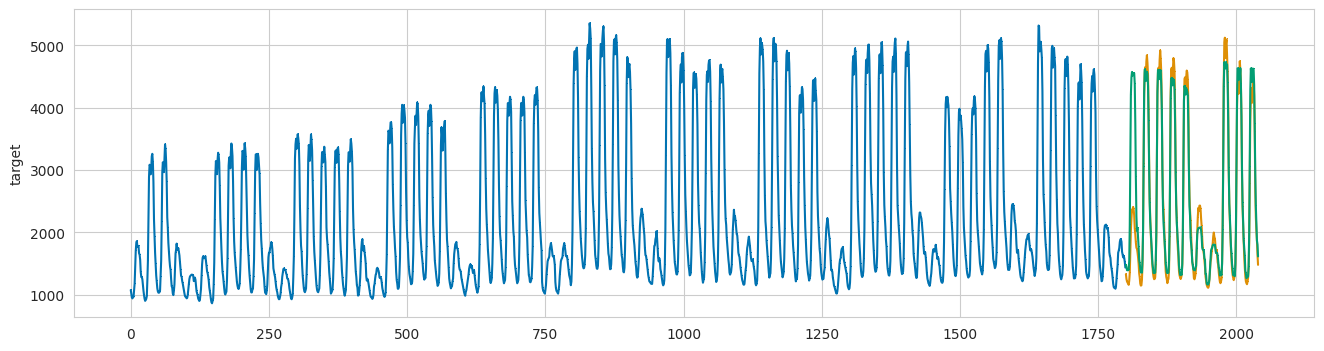

In [1175]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1176]:
_smape(y_valid, x_pred)

4.309363288193737

In [1177]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 2288.431411


(2352,)

## 83

In [1178]:
train_ft_83.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간'],
      dtype='object')

- 불필요 컬럼 제거

In [1179]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

train_ft_83 = train_ft_83.drop(columns=drop_cols)
train_ft_83.head()

target    기온  강수량   풍속    습도  hour  weekday  month  weekend  공휴일  \
0   723.0  17.9  0.0  1.0  48.0     0        2      6        0    0   
1   712.2  17.7  0.0  1.2  50.0     1        2      6        0    0   
2   690.6  17.5  0.0  1.7  49.0     2        2      6        0    0   
3   679.2  15.9  0.0  0.4  54.0     3        2      6        0    0   
4   678.0  16.6  0.0  2.6  53.0     4        2      6        0    0   

   min_temperature  사용시간  
0             15.9     0  
1             15.9     0  
2             15.9     0  
3             15.9     0  
4             15.9     0

In [1180]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

test_ft_83 = test_ft_83.drop(columns=drop_cols)
test_ft_83.head()

기온  강수량   풍속  습도  hour  weekday  month  weekend  공휴일  min_temperature  \
0  22.8  0.0  1.1  75     0        3      8        0    1             20.5   
1  22.6  0.0  1.0  75     1        3      8        0    1             20.5   
2  22.2  0.0  1.0  77     2        3      8        0    1             20.5   
3  21.4  0.0  1.0  83     3        3      8        0    1             20.5   
4  21.2  0.0  0.3  85     4        3      8        0    1             20.5   

   사용시간  
0     0  
1     0  
2     0  
3     0  
4     0

- 모델링

In [1181]:
train_x = train_ft_83.iloc[:, 1:]
train_y = train_ft_83['target']

test_x = test_ft_83

In [1182]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1183]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 1432.623834
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 904.022	valid_1's l2: 42399.7


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

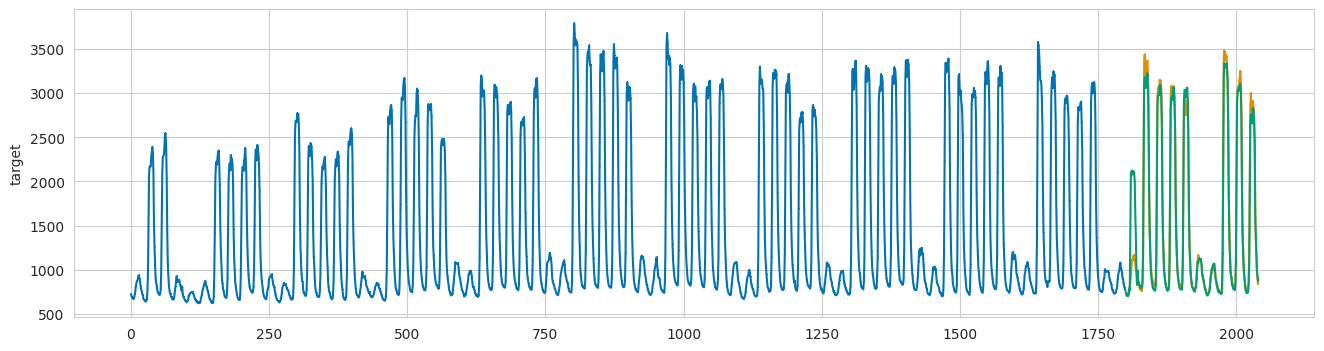

In [1184]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1185]:
_smape(y_valid, x_pred)

2.96111563281784

In [1186]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 456
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 1445.103677


(2520,)

## 84

In [1187]:
train_ft_84.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간'],
      dtype='object')

- 불필요 컬럼 제거

In [1188]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

train_ft_84 = train_ft_84.drop(columns=drop_cols)
train_ft_84.head()

target    기온  강수량   풍속    습도  hour  weekday  month  weekend  공휴일  \
0  920.16  17.9  0.0  1.0  48.0     0        2      6        0    0   
1  855.36  17.7  0.0  1.2  50.0     1        2      6        0    0   
2  798.72  17.5  0.0  1.7  49.0     2        2      6        0    0   
3  757.44  15.9  0.0  0.4  54.0     3        2      6        0    0   
4  742.08  16.6  0.0  2.6  53.0     4        2      6        0    0   

   min_temperature  사용시간  
0             15.9     0  
1             15.9     0  
2             15.9     0  
3             15.9     0  
4             15.9     0

In [1189]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster'] # , 'weekend'

test_ft_84 = test_ft_84.drop(columns=drop_cols)
test_ft_84.head()

기온  강수량   풍속  습도  hour  weekday  month  weekend  공휴일  min_temperature  \
0  22.8  0.0  1.1  75     0        3      8        0    1             20.5   
1  22.6  0.0  1.0  75     1        3      8        0    1             20.5   
2  22.2  0.0  1.0  77     2        3      8        0    1             20.5   
3  21.4  0.0  1.0  83     3        3      8        0    1             20.5   
4  21.2  0.0  0.3  85     4        3      8        0    1             20.5   

   사용시간  
0     0  
1     0  
2     0  
3     0  
4     0

- 모델링

In [1190]:
train_x = train_ft_84.iloc[:, 1:]
train_y = train_ft_84['target']

test_x = test_ft_84

In [1191]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1192]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 1710.761867
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[20]	training's l2: 16294.3	valid_1's l2: 109841


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

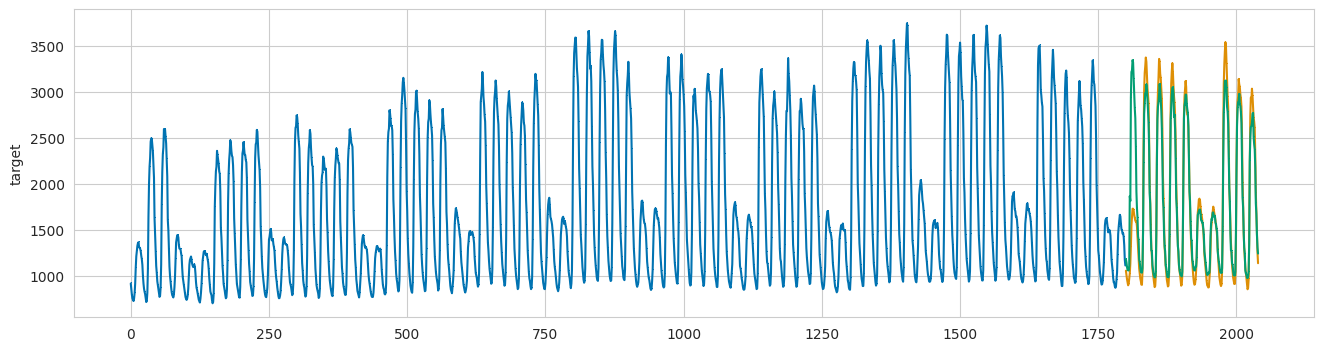

In [1193]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1194]:
_smape(y_valid, x_pred)

4.588465074289887

In [1195]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 457
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 1721.985412


(2688,)

## 85(weekend 제거~)

In [1196]:
train_ft_85.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간'],
      dtype='object')

- 불필요 컬럼 제거

In [1197]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

train_ft_85 = train_ft_85.drop(columns=drop_cols)
train_ft_85.head()

target    기온  강수량   풍속    습도  hour  weekday  month  공휴일  min_temperature  \
0  1464.00  18.6  0.0  0.9  42.0     0        2      6    0             16.3   
1  1444.80  18.0  0.0  1.1  45.0     1        2      6    0             16.3   
2  1442.40  17.7  0.0  1.5  45.0     2        2      6    0             16.3   
3  1438.08  16.7  0.0  1.4  48.0     3        2      6    0             16.3   
4  1469.76  18.4  0.0  2.8  43.0     4        2      6    0             16.3   

   사용시간  
0     0  
1     0  
2     0  
3     0  
4     0

In [1198]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

test_ft_85 = test_ft_85.drop(columns=drop_cols)
test_ft_85.head()

기온  강수량   풍속  습도  hour  weekday  month  공휴일  min_temperature  사용시간
0  23.5  0.0  2.2  72     0        3      8    1             21.2     0
1  23.0  0.0  0.9  72     1        3      8    1             21.2     0
2  22.7  0.0  1.5  75     2        3      8    1             21.2     0
3  22.1  0.0  1.3  78     3        3      8    1             21.2     0
4  21.8  0.0  1.0  77     4        3      8    1             21.2     0

- 모델링

In [1199]:
train_x = train_ft_85.iloc[:, 1:]
train_y = train_ft_85['target']

test_x = test_ft_85

In [1200]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 10), (240, 10), (1800,), (240,))

In [1201]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 10
[LightGBM] [Info] Start training from score 2239.157932
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[44]	training's l2: 2653.09	valid_1's l2: 8761.89


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

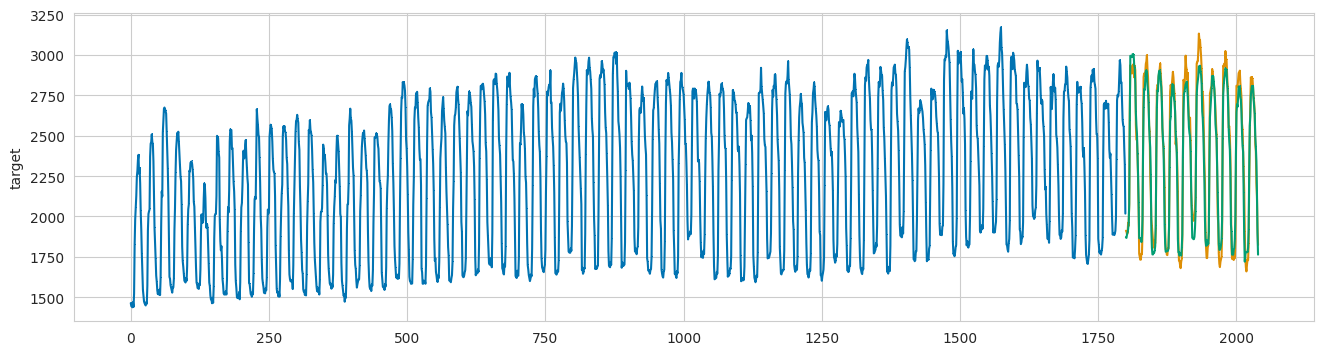

In [1202]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1203]:
_smape(y_valid, x_pred)

1.6397475814026345

In [1204]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 445
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 10
[LightGBM] [Info] Start training from score 2258.645116


(2856,)

## 86

In [1205]:
train_ft_86.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간', 'THI'],
      dtype='object')

- 불필요 컬럼 제거

In [1206]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

train_ft_86 = train_ft_86.drop(columns=drop_cols)
train_ft_86.head()

target    기온  강수량   풍속    습도  hour  weekday  month  공휴일  min_temperature  \
0  480.06  17.9  0.0  1.0  48.0     0        2      6    0             15.9   
1  488.16  17.7  0.0  1.2  50.0     1        2      6    0             15.9   
2  477.54  17.5  0.0  1.7  49.0     2        2      6    0             15.9   
3  473.58  15.9  0.0  0.4  54.0     3        2      6    0             15.9   
4  490.32  16.6  0.0  2.6  53.0     4        2      6    0             15.9   

   사용시간        THI  
0     0  60.833210  
1     0  60.675676  
2     0  60.526425  
3     0  59.184764  
4     0  59.801484

In [1207]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

test_ft_86 = test_ft_86.drop(columns=drop_cols)
test_ft_86.head()

기온  강수량   풍속  습도  hour  weekday  month  공휴일  min_temperature  사용시간  \
0  22.8  0.0  1.1  75     0        3      8    1             20.5     0   
1  22.6  0.0  1.0  75     1        3      8    1             20.5     0   
2  22.2  0.0  1.0  77     2        3      8    1             20.5     0   
3  21.4  0.0  1.0  83     3        3      8    1             20.5     0   
4  21.2  0.0  0.3  85     4        3      8    1             20.5     0   

         THI  
0  64.858992  
1  64.686740  
2  64.358780  
3  63.702860  
4  63.492064

- 모델링

In [1208]:
train_x = train_ft_86.iloc[:, 1:]
train_y = train_ft_86['target']

test_x = test_ft_86

In [1209]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1210]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 1140.114899
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[23]	training's l2: 11184.6	valid_1's l2: 38088.7


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

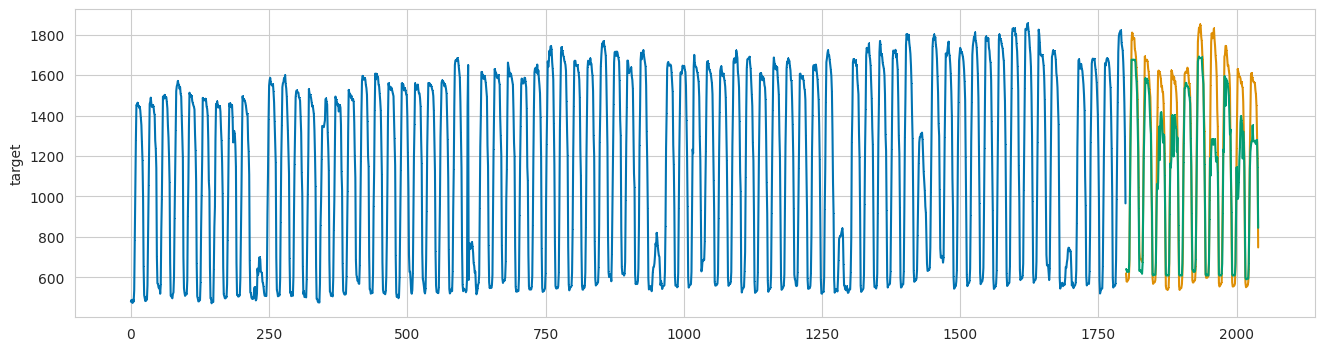

In [1211]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1212]:
_smape(y_valid, x_pred)

5.576230153150508

In [1213]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 1149.326646


(3024,)

## 87

In [1214]:
train_ft_87.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간', 'AT'],
      dtype='object')

- 불필요 컬럼 제거

In [1215]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

train_ft_87 = train_ft_87.drop(columns=drop_cols)
train_ft_87.head()

target    기온  강수량   풍속    습도  hour  weekday  month  공휴일  min_temperature  \
0  412.02  13.6  0.0  0.7  52.0     0        2      6    0             11.9   
1  413.82  13.4  0.0  0.0  57.0     1        2      6    0             11.9   
2  405.36  13.3  0.0  0.2  57.0     2        2      6    0             11.9   
3  392.58  11.9  0.0  0.6  66.0     3        2      6    0             11.9   
4  416.70  14.4  0.0  0.7  51.0     4        2      6    0             11.9   

   사용시간         AT  
0     0   6.590319  
1     0  42.322000  
2     0  12.993291  
3     0   6.901437  
4     0   6.854319

In [1216]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

test_ft_87 = test_ft_87.drop(columns=drop_cols)
test_ft_87.head()

기온  강수량   풍속  습도  hour  weekday  month  공휴일  min_temperature  사용시간  \
0  21.2  0.0  0.2  85     0        3      8    1             19.7     0   
1  21.0  0.0  0.0  87     1        3      8    1             19.7     0   
2  20.2  0.0  0.1  90     2        3      8    1             19.7     0   
3  20.0  0.0  0.0  91     3        3      8    1             19.7     0   
4  19.7  0.0  0.2  92     4        3      8    1             19.7     0   

          AT  
0  15.600291  
1  44.830000  
2  18.345606  
3  44.500000  
4  15.105291

- 모델링

In [1217]:
train_x = train_ft_87.iloc[:, 1:]
train_y = train_ft_87['target']

test_x = test_ft_87

In [1218]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1219]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 1265.483651
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[26]	training's l2: 15873.8	valid_1's l2: 22450.5


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

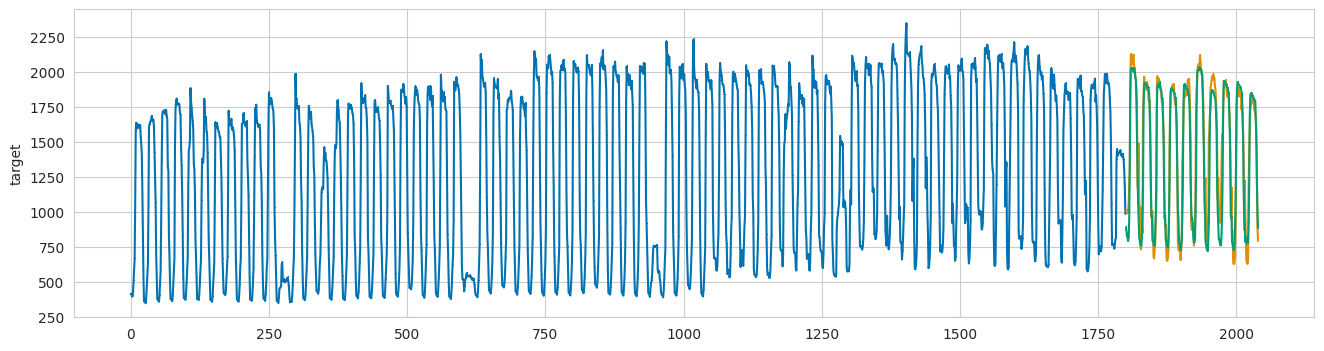

In [1220]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1221]:
_smape(y_valid, x_pred)

4.552425360259269

In [1222]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 1289.623369


(3192,)

## 88

In [1223]:
train_ft_88.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간', 'CDH'],
      dtype='object')

- 불필요 컬럼 제거

In [1224]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

train_ft_88 = train_ft_88.drop(columns=drop_cols)
train_ft_88.head()

target    기온  강수량   풍속    습도  hour  weekday  month  공휴일  min_temperature  \
0  448.02  18.7  0.0  4.1  44.0     0        2      6    0             16.7   
1  418.50  18.1  0.0  4.2  47.0     1        2      6    0             16.7   
2  421.74  17.8  0.0  3.0  47.0     2        2      6    0             16.7   
3  415.98  17.8  0.0  3.3  46.0     3        2      6    0             16.7   
4  408.42  18.0  0.0  1.2  53.0     4        2      6    0             16.7   

   사용시간   CDH  
0     0  -7.3  
1     0 -15.2  
2     0 -23.4  
3     0 -31.6  
4     0 -39.6

In [1225]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

test_ft_88 = test_ft_88.drop(columns=drop_cols)
test_ft_88.head()

기온  강수량   풍속  습도  hour  weekday  month  공휴일  min_temperature  사용시간   CDH
0  23.5  0.0  1.9  71     0        3      8    1             21.4     0  -2.5
1  23.1  0.0  1.9  71     1        3      8    1             21.4     0  -5.4
2  22.7  0.0  2.5  73     2        3      8    1             21.4     0  -8.7
3  22.4  0.0  2.5  73     3        3      8    1             21.4     0 -12.3
4  22.3  0.0  2.4  74     4        3      8    1             21.4     0 -16.0

- 모델링

In [1226]:
train_x = train_ft_88.iloc[:, 1:]
train_y = train_ft_88['target']

test_x = test_ft_88

In [1227]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1228]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 1187.060451
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[32]	training's l2: 5989.89	valid_1's l2: 75970.6


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

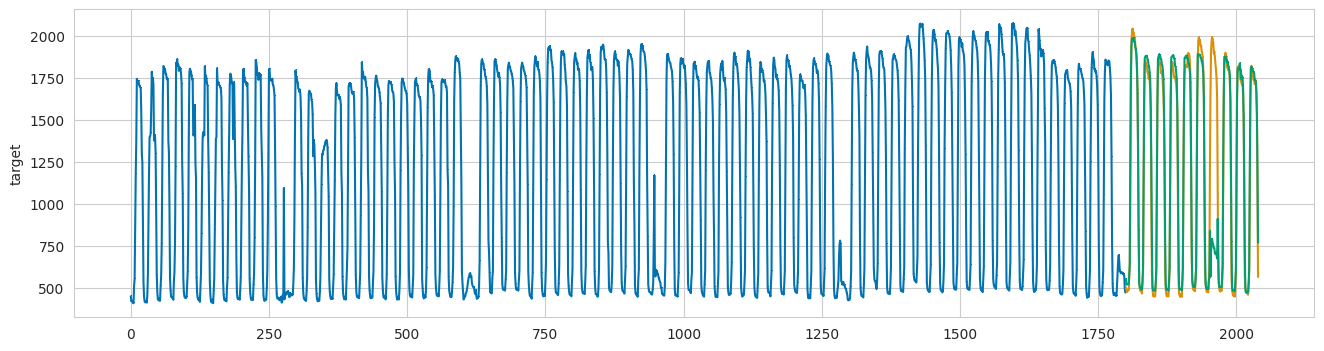

In [1229]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1230]:
_smape(y_valid, x_pred)

4.748415487235736

In [1231]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 1195.243016


(3360,)

## 89

In [1232]:
train_ft_89.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간', 'CDH'],
      dtype='object')

- 불필요 컬럼 제거

In [1233]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

train_ft_89 = train_ft_89.drop(columns=drop_cols)
train_ft_89.head()

target    기온  강수량   풍속    습도  hour  weekday  month  공휴일  min_temperature  \
0  494.40  18.7  0.0  4.1  44.0     0        2      6    0             16.7   
1  442.56  18.1  0.0  4.2  47.0     1        2      6    0             16.7   
2  431.76  17.8  0.0  3.0  47.0     2        2      6    0             16.7   
3  425.28  17.8  0.0  3.3  46.0     3        2      6    0             16.7   
4  416.64  18.0  0.0  1.2  53.0     4        2      6    0             16.7   

   사용시간   CDH  
0     0  -7.3  
1     0 -15.2  
2     0 -23.4  
3     0 -31.6  
4     0 -39.6

In [1234]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

test_ft_89 = test_ft_89.drop(columns=drop_cols)
test_ft_89.head()

기온  강수량   풍속  습도  hour  weekday  month  공휴일  min_temperature  사용시간   CDH
0  23.5  0.0  1.9  71     0        3      8    1             21.4     0  -2.5
1  23.1  0.0  1.9  71     1        3      8    1             21.4     0  -5.4
2  22.7  0.0  2.5  73     2        3      8    1             21.4     0  -8.7
3  22.4  0.0  2.5  73     3        3      8    1             21.4     0 -12.3
4  22.3  0.0  2.4  74     4        3      8    1             21.4     0 -16.0

- 모델링

In [1235]:
train_x = train_ft_89.iloc[:, 1:]
train_y = train_ft_89['target']

test_x = test_ft_89

In [1236]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1237]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 1421.448532
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[31]	training's l2: 10651.6	valid_1's l2: 110366


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

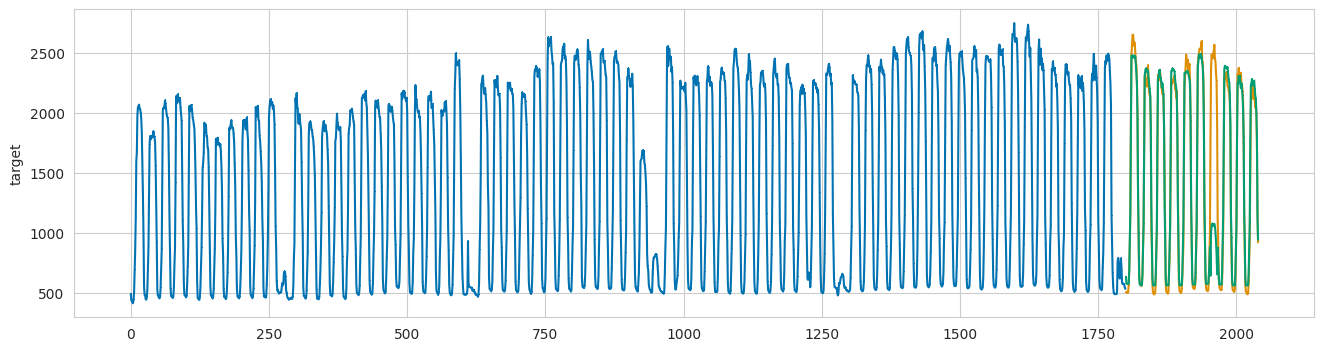

In [1238]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1239]:
_smape(y_valid, x_pred)

4.968514974301527

In [1240]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 1435.096470


(3528,)

## 90

In [1241]:
train_ft_90.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간', 'AT'],
      dtype='object')

- 불필요 컬럼 제거

In [1242]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

train_ft_90 = train_ft_90.drop(columns=drop_cols)
train_ft_90.head()

target    기온  강수량   풍속    습도  hour  weekday  month  공휴일  min_temperature  \
0  465.36  22.1  0.0  0.9  43.0     0        2      6    0             18.9   
1  431.28  20.4  0.0  1.6  50.0     1        2      6    0             18.9   
2  434.40  20.2  0.0  0.2  50.0     2        2      6    0             18.9   
3  414.48  19.7  0.0  0.7  49.0     3        2      6    0             18.9   
4  434.64  18.9  0.0  0.5  51.0     4        2      6    0             18.9   

   사용시간         AT  
0     0   7.926551  
1     0   3.771996  
2     0  15.270291  
3     0   8.603319  
4     0  10.215550

In [1243]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

test_ft_90 = test_ft_90.drop(columns=drop_cols)
test_ft_90.head()

기온  강수량   풍속   습도  hour  weekday  month  공휴일  min_temperature  사용시간  \
0  21.2  0.0  0.9   93     0        3      8    1             18.8     0   
1  20.2  0.0  0.2   98     1        3      8    1             18.8     0   
2  19.8  0.0  0.8  100     2        3      8    1             18.8     0   
3  19.4  0.0  0.1  100     3        3      8    1             18.8     0   
4  19.3  0.0  0.0  100     4        3      8    1             18.8     0   

          AT  
0   7.629551  
1  15.270291  
2   7.863272  
3  18.081606  
4  44.269000

- 모델링

In [1244]:
train_x = train_ft_90.iloc[:, 1:]
train_y = train_ft_90['target']

test_x = test_ft_90

In [1245]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1246]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 1368.818935
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[53]	training's l2: 5954.92	valid_1's l2: 103968


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

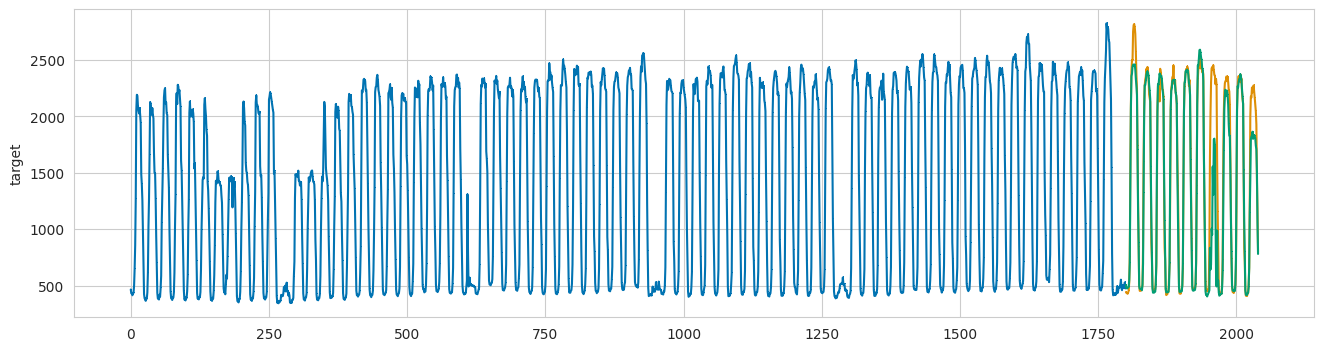

In [1247]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1248]:
_smape(y_valid, x_pred)

5.141341524638192

In [1249]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 1386.890825


(3696,)

## 91

In [1250]:
train_ft_91.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간', 'CDH'],
      dtype='object')

- 불필요 컬럼 제거

In [1251]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

train_ft_91 = train_ft_91.drop(columns=drop_cols)
train_ft_91.head()

target    기온  강수량   풍속    습도  hour  weekday  month  공휴일  min_temperature  \
0  411.36  20.3  0.0  0.1  52.0     0        2      6    0             18.1   
1  401.76  19.5  0.0  0.5  55.0     1        2      6    0             18.1   
2  400.56  19.4  0.0  1.0  53.0     2        2      6    0             18.1   
3  406.32  18.8  0.0  0.0  56.0     3        2      6    0             18.1   
4  417.36  18.3  0.0  0.0  70.0     4        2      6    0             18.1   

   사용시간   CDH  
0     0  -5.7  
1     0 -12.2  
2     0 -18.8  
3     0 -26.0  
4     0 -33.7

In [1252]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

test_ft_91 = test_ft_91.drop(columns=drop_cols)
test_ft_91.head()

기온  강수량   풍속  습도  hour  weekday  month  공휴일  min_temperature  사용시간   CDH
0  23.6  0.0  0.7  94     0        3      8    1             22.0     0  -2.4
1  23.3  0.0  1.8  96     1        3      8    1             22.0     0  -5.1
2  22.9  0.0  1.2  97     2        3      8    1             22.0     0  -8.2
3  23.0  0.0  1.1  98     3        3      8    1             22.0     0 -11.2
4  22.7  0.0  1.1  99     4        3      8    1             22.0     0 -14.5

- 모델링

In [1253]:
train_x = train_ft_91.iloc[:, 1:]
train_y = train_ft_91['target']

test_x = test_ft_91

In [1254]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1255]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 1316.538799
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[88]	training's l2: 2862.37	valid_1's l2: 22687.6


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

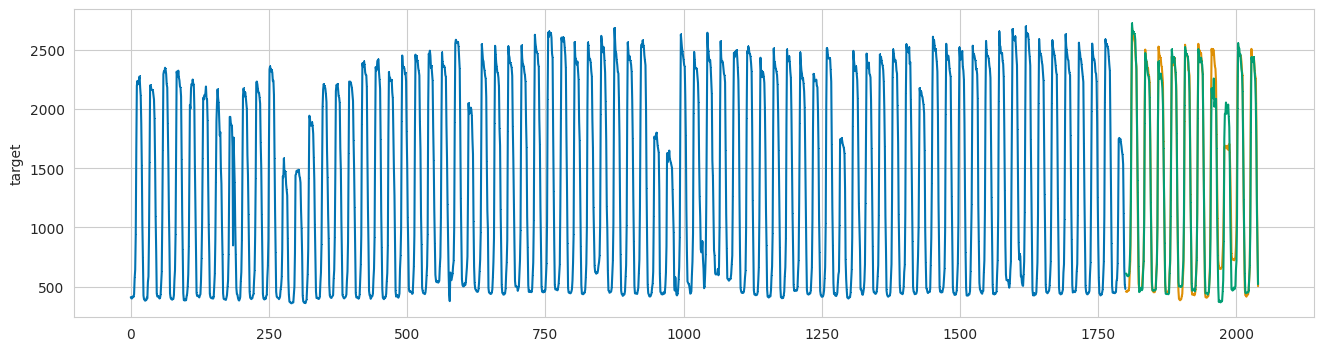

In [1256]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1257]:
_smape(y_valid, x_pred)

5.368574941618682

In [1258]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 1326.801763


(3864,)

## 92

In [1259]:
train_ft_92.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간'],
      dtype='object')

- 불필요 컬럼 제거

In [1260]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

train_ft_92 = train_ft_92.drop(columns=drop_cols)
train_ft_92.head()

target    기온  강수량   풍속    습도  hour  weekday  month  공휴일  min_temperature  \
0  503.10  17.9  0.0  1.0  48.0     0        2      6    0             15.9   
1  480.06  17.7  0.0  1.2  50.0     1        2      6    0             15.9   
2  468.18  17.5  0.0  1.7  49.0     2        2      6    0             15.9   
3  463.50  15.9  0.0  0.4  54.0     3        2      6    0             15.9   
4  473.94  16.6  0.0  2.6  53.0     4        2      6    0             15.9   

   사용시간  
0     0  
1     0  
2     0  
3     0  
4     0

In [1261]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

test_ft_92 = test_ft_92.drop(columns=drop_cols)
test_ft_92.head()

기온  강수량   풍속  습도  hour  weekday  month  공휴일  min_temperature  사용시간
0  22.8  0.0  1.1  75     0        3      8    1             20.5     0
1  22.6  0.0  1.0  75     1        3      8    1             20.5     0
2  22.2  0.0  1.0  77     2        3      8    1             20.5     0
3  21.4  0.0  1.0  83     3        3      8    1             20.5     0
4  21.2  0.0  0.3  85     4        3      8    1             20.5     0

- 모델링

In [1262]:
train_x = train_ft_92.iloc[:, 1:]
train_y = train_ft_92['target']

test_x = test_ft_92

In [1263]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 10), (240, 10), (1800,), (240,))

In [1264]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 446
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 10
[LightGBM] [Info] Start training from score 1285.935001
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[28]	training's l2: 8534.49	valid_1's l2: 43692.1


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

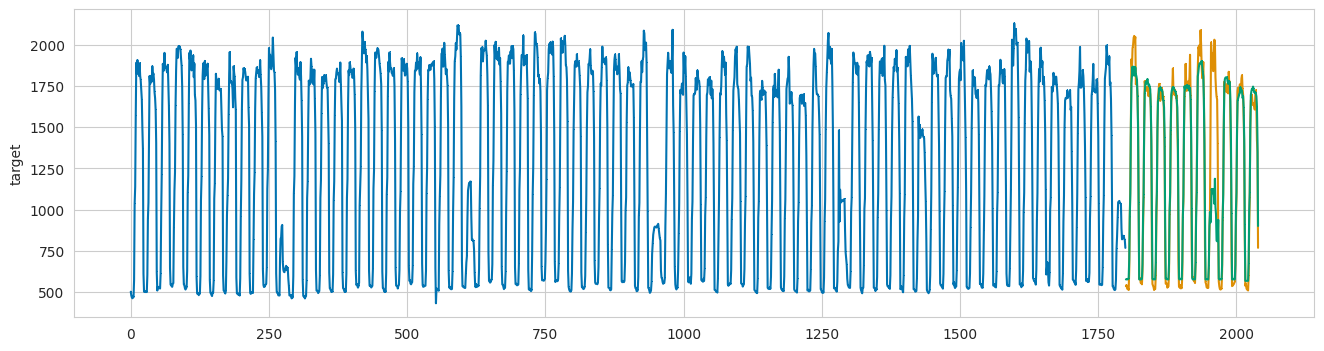

In [1265]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1266]:
_smape(y_valid, x_pred)

4.089158290232075

In [1267]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 454
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 10
[LightGBM] [Info] Start training from score 1285.452795


(4032,)

## 93

In [1268]:
train_ft_93.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간'],
      dtype='object')

- 불필요 컬럼 제거

In [1269]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

train_ft_93 = train_ft_93.drop(columns=drop_cols)
train_ft_93.head()

target    기온  강수량   풍속    습도  hour  weekday  month  공휴일  min_temperature  \
0  640.62  18.6  0.0  0.9  42.0     0        2      6    0             16.3   
1  576.18  18.0  0.0  1.1  45.0     1        2      6    0             16.3   
2  561.96  17.7  0.0  1.5  45.0     2        2      6    0             16.3   
3  574.20  16.7  0.0  1.4  48.0     3        2      6    0             16.3   
4  564.30  18.4  0.0  2.8  43.0     4        2      6    0             16.3   

   사용시간  
0     0  
1     0  
2     0  
3     0  
4     0

In [1270]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

test_ft_93 = test_ft_93.drop(columns=drop_cols)
test_ft_93.head()

기온  강수량   풍속  습도  hour  weekday  month  공휴일  min_temperature  사용시간
0  23.5  0.0  2.2  72     0        3      8    1             21.2     0
1  23.0  0.0  0.9  72     1        3      8    1             21.2     0
2  22.7  0.0  1.5  75     2        3      8    1             21.2     0
3  22.1  0.0  1.3  78     3        3      8    1             21.2     0
4  21.8  0.0  1.0  77     4        3      8    1             21.2     0

- 모델링

In [1271]:
train_x = train_ft_93.iloc[:, 1:]
train_y = train_ft_93['target']

test_x = test_ft_93

In [1272]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 10), (240, 10), (1800,), (240,))

In [1273]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 10
[LightGBM] [Info] Start training from score 1097.262700
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[62]	training's l2: 1036.35	valid_1's l2: 5540.9


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

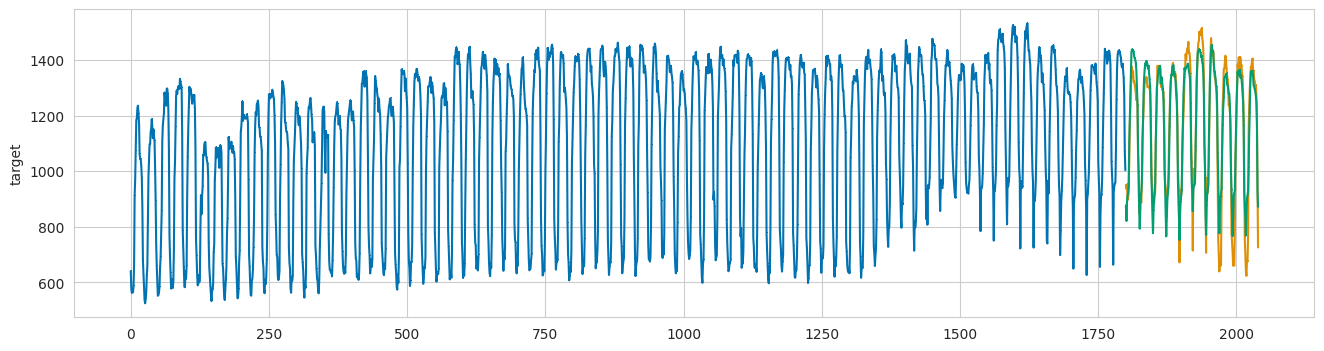

In [1274]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1275]:
_smape(y_valid, x_pred)

2.685630214255791

In [1276]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 445
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 10
[LightGBM] [Info] Start training from score 1105.749706


(4200,)

## 94

In [1277]:
train_ft_94.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간'],
      dtype='object')

- 불필요 컬럼 제거

In [1278]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

train_ft_94 = train_ft_94.drop(columns=drop_cols)
train_ft_94.head()

target    기온  강수량   풍속    습도  hour  weekday  month  공휴일  min_temperature  \
0  1134.24  18.6  0.0  0.9  42.0     0        2      6    0             16.3   
1  1101.36  18.0  0.0  1.1  45.0     1        2      6    0             16.3   
2  1090.32  17.7  0.0  1.5  45.0     2        2      6    0             16.3   
3  1066.32  16.7  0.0  1.4  48.0     3        2      6    0             16.3   
4  1079.04  18.4  0.0  2.8  43.0     4        2      6    0             16.3   

   사용시간  
0     0  
1     0  
2     0  
3     0  
4     0

In [1279]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

test_ft_94 = test_ft_94.drop(columns=drop_cols)
test_ft_94.head()

기온  강수량   풍속  습도  hour  weekday  month  공휴일  min_temperature  사용시간
0  23.5  0.0  2.2  72     0        3      8    1             21.2     0
1  23.0  0.0  0.9  72     1        3      8    1             21.2     0
2  22.7  0.0  1.5  75     2        3      8    1             21.2     0
3  22.1  0.0  1.3  78     3        3      8    1             21.2     0
4  21.8  0.0  1.0  77     4        3      8    1             21.2     0

- 모델링

In [1280]:
train_x = train_ft_94.iloc[:, 1:]
train_y = train_ft_94['target']

test_x = test_ft_94

In [1281]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 10), (240, 10), (1800,), (240,))

In [1282]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 10
[LightGBM] [Info] Start training from score 2432.646665
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[75]	training's l2: 6915.76	valid_1's l2: 35895.1


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

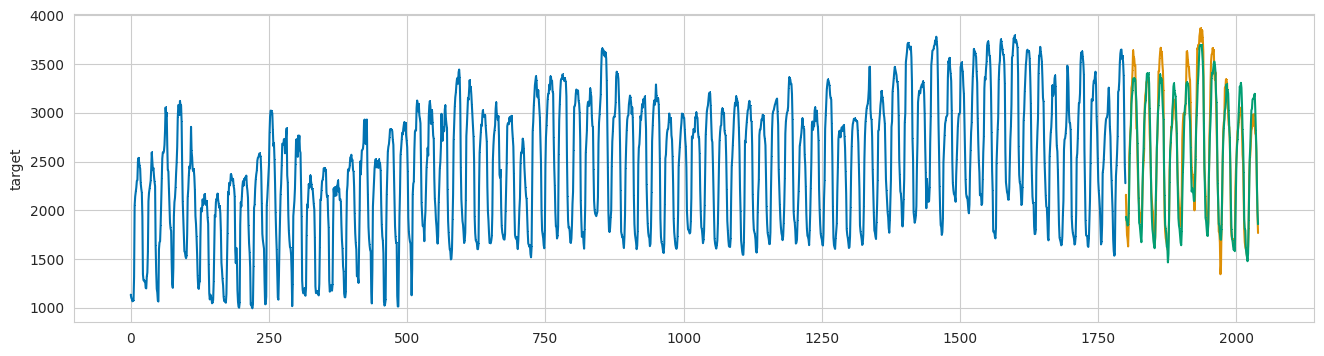

In [1283]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1284]:
_smape(y_valid, x_pred)

2.8822558194507018

In [1285]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 445
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 10
[LightGBM] [Info] Start training from score 2457.945881


(4368,)

## 95(?)

In [1286]:
train_ft_95.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간'],
      dtype='object')

- 불필요 컬럼 제거

In [1287]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

train_ft_95 = train_ft_95.drop(columns=drop_cols)
train_ft_95.head()

target    기온  강수량   풍속    습도  hour  weekday  month  공휴일  min_temperature  \
0  681.48  16.5  0.0  1.4  61.0     0        2      6    0             13.5   
1  999.72  15.3  0.0  0.7  67.0     1        2      6    0             13.5   
2  806.40  14.5  0.0  1.1  70.0     2        2      6    0             13.5   
3  741.60  14.1  0.0  0.4  73.0     3        2      6    0             13.5   
4  897.84  13.9  0.0  0.9  76.0     4        2      6    0             13.5   

   사용시간  
0     0  
1     0  
2     0  
3     0  
4     0

In [1288]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

test_ft_95 = test_ft_95.drop(columns=drop_cols)
test_ft_95.head()

기온  강수량   풍속  습도  hour  weekday  month  공휴일  min_temperature  사용시간
0  19.6  0.0  0.1  95     0        3      8    1             18.5     0
1  19.0  0.0  0.6  96     1        3      8    1             18.5     0
2  19.0  0.0  0.1  96     2        3      8    1             18.5     0
3  18.6  0.0  0.1  97     3        3      8    1             18.5     0
4  18.8  0.0  0.2  97     4        3      8    1             18.5     0

- 모델링

In [1289]:
train_x = train_ft_95.iloc[:, 1:]
train_y = train_ft_95['target']

test_x = test_ft_95

In [1290]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 10), (240, 10), (1800,), (240,))

In [1291]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 10
[LightGBM] [Info] Start training from score 1106.594699
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[35]	training's l2: 20082.6	valid_1's l2: 48734.1


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

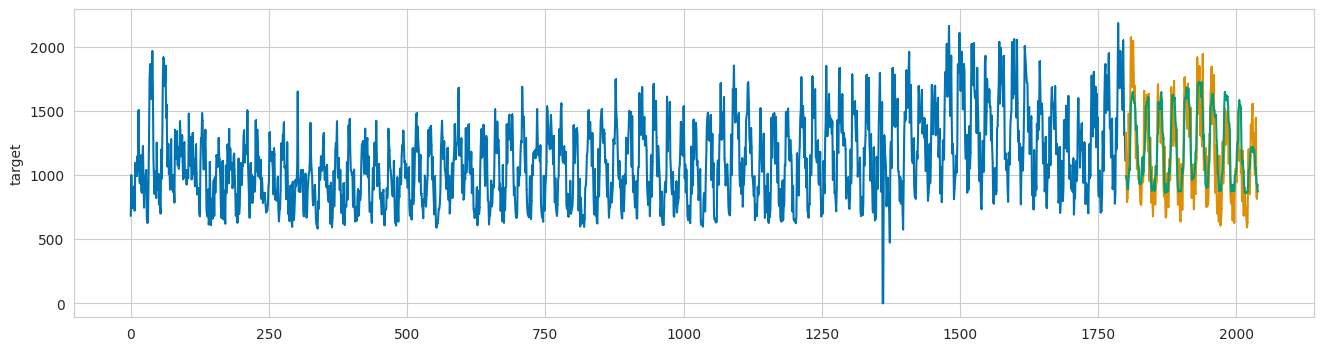

In [1292]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1293]:
_smape(y_valid, x_pred)

7.894744195093262

In [1294]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 442
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 10
[LightGBM] [Info] Start training from score 1112.192735


(4536,)

## 96

In [1295]:
train_ft_96.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간', 'CDH'],
      dtype='object')

- 불필요 컬럼 제거

In [1296]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

train_ft_96 = train_ft_96.drop(columns=drop_cols)
train_ft_96.head()

target    기온  강수량   풍속    습도  hour  weekday  month  공휴일  min_temperature  \
0  1576.68  18.6  0.0  2.6  62.0     0        2      6    0             18.6   
1  1558.68  18.8  0.0  0.4  62.0     1        2      6    0             18.6   
2  1413.36  18.9  0.0  0.0  52.0     2        2      6    0             18.6   
3  1483.92  20.2  0.0  2.4  38.0     3        2      6    0             18.6   
4  1438.56  20.4  0.0  2.8  40.0     4        2      6    0             18.6   

   사용시간   CDH  
0     0  -7.4  
1     0 -14.6  
2     0 -21.7  
3     0 -27.5  
4     0 -33.1

In [1297]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

test_ft_96 = test_ft_96.drop(columns=drop_cols)
test_ft_96.head()

기온  강수량   풍속  습도  hour  weekday  month  공휴일  min_temperature  사용시간   CDH
0  20.7  0.0  1.5  87     0        3      8    1             20.4     0  -5.3
1  20.9  0.0  1.7  84     1        3      8    1             20.4     0 -10.4
2  21.2  0.0  3.0  83     2        3      8    1             20.4     0 -15.2
3  21.0  0.0  0.8  84     3        3      8    1             20.4     0 -20.2
4  20.8  0.0  1.9  86     4        3      8    1             20.4     0 -25.4

- 모델링

In [1298]:
train_x = train_ft_96.iloc[:, 1:]
train_y = train_ft_96['target']

test_x = test_ft_96

In [1299]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1300]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 690
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 2788.367501
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[50]	training's l2: 5985.56	valid_1's l2: 23675.7


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

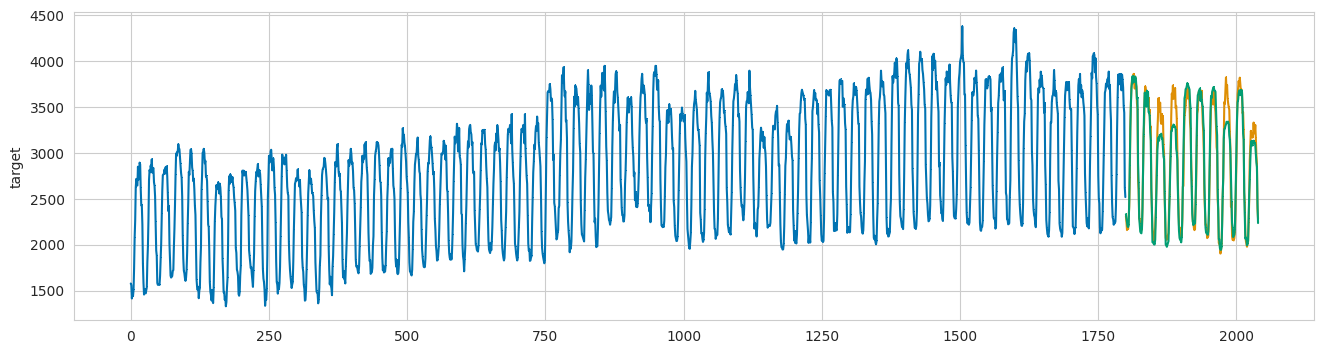

In [1301]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1302]:
_smape(y_valid, x_pred)

1.8729347965894487

In [1303]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 2808.038089


(4704,)

## 97

In [1304]:
train_ft_97.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간', 'CDH'],
      dtype='object')

- 불필요 컬럼 제거

In [1305]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

train_ft_97 = train_ft_97.drop(columns=drop_cols)
train_ft_97.head()

target    기온  강수량   풍속    습도  hour  weekday  month  공휴일  min_temperature  \
0  774.36  19.4  0.0  0.8  66.0     0        2      6    0             18.3   
1  553.86  19.6  0.0  1.0  61.0     1        2      6    0             18.3   
2  558.90  19.1  0.0  1.2  72.0     2        2      6    0             18.3   
3  559.44  18.8  0.0  1.0  75.0     3        2      6    0             18.3   
4  559.62  18.6  0.0  1.2  72.0     4        2      6    0             18.3   

   사용시간   CDH  
0     0  -6.6  
1     0 -13.0  
2     0 -19.9  
3     0 -27.1  
4     0 -34.5

In [1306]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

test_ft_97 = test_ft_97.drop(columns=drop_cols)
test_ft_97.head()

기온  강수량   풍속  습도  hour  weekday  month  공휴일  min_temperature  사용시간   CDH
0  23.6  0.0  3.0  74     0        3      8    1             23.0     0  -2.4
1  23.9  0.0  2.8  74     1        3      8    1             23.0     0  -4.5
2  24.2  0.0  3.4  75     2        3      8    1             23.0     0  -6.3
3  23.7  0.0  3.3  76     3        3      8    1             23.0     0  -8.6
4  23.5  0.0  3.1  78     4        3      8    1             23.0     0 -11.1

- 모델링

In [1307]:
train_x = train_ft_97.iloc[:, 1:]
train_y = train_ft_97['target']

test_x = test_ft_97

In [1308]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1309]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 1214.989600
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[82]	training's l2: 1596.07	valid_1's l2: 13433.4


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

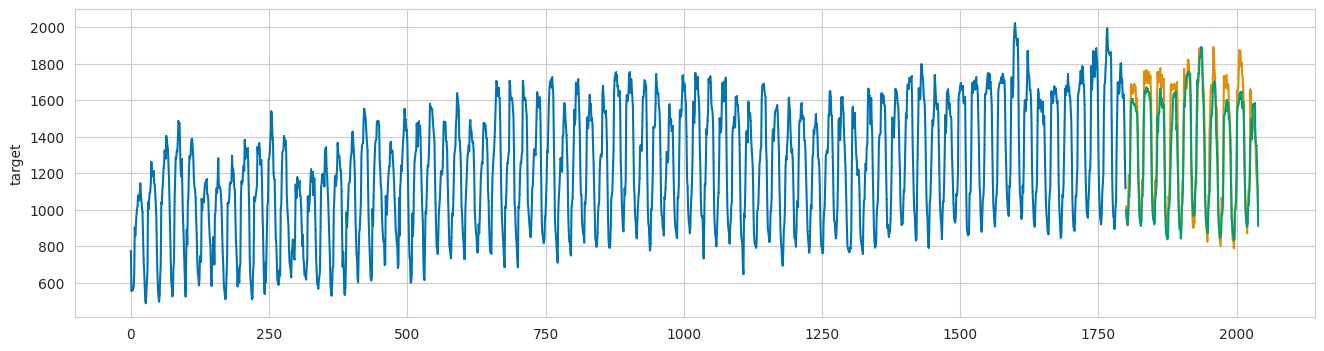

In [1310]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1311]:
_smape(y_valid, x_pred)

3.2592176360326874

In [1312]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 1235.922176


(4872,)

## 98

In [1313]:
train_ft_98.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간', 'CDH'],
      dtype='object')

- 불필요 컬럼 제거

In [1314]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

train_ft_98 = train_ft_98.drop(columns=drop_cols)
train_ft_98.head()

target    기온  강수량   풍속    습도  hour  weekday  month  공휴일  min_temperature  \
0  533.52  19.7  0.0  0.6  40.0     0        2      6    0             17.9   
1  516.78  19.2  0.0  1.2  44.0     1        2      6    0             17.9   
2  509.40  18.5  0.0  1.3  47.0     2        2      6    0             17.9   
3  479.70  19.0  0.0  0.8  45.0     3        2      6    0             17.9   
4  541.98  18.3  0.0  1.1  47.0     4        2      6    0             17.9   

   사용시간   CDH  
0     0  -6.3  
1     0 -13.1  
2     0 -20.6  
3     0 -27.6  
4     0 -35.3

In [1315]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

test_ft_98 = test_ft_98.drop(columns=drop_cols)
test_ft_98.head()

기온  강수량   풍속  습도  hour  weekday  month  공휴일  min_temperature  사용시간   CDH
0  20.9  0.0  1.0  89     0        3      8    1             19.1     0  -5.1
1  20.7  0.0  0.4  91     1        3      8    1             19.1     0 -10.4
2  20.5  0.0  0.8  93     2        3      8    1             19.1     0 -15.9
3  19.9  0.0  0.9  96     3        3      8    1             19.1     0 -22.0
4  19.4  0.0  1.0  97     4        3      8    1             19.1     0 -28.6

- 모델링

In [1316]:
train_x = train_ft_98.iloc[:, 1:]
train_y = train_ft_98['target']

test_x = test_ft_98

In [1317]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1318]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 1130.736100
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[55]	training's l2: 4280.47	valid_1's l2: 29618.5


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

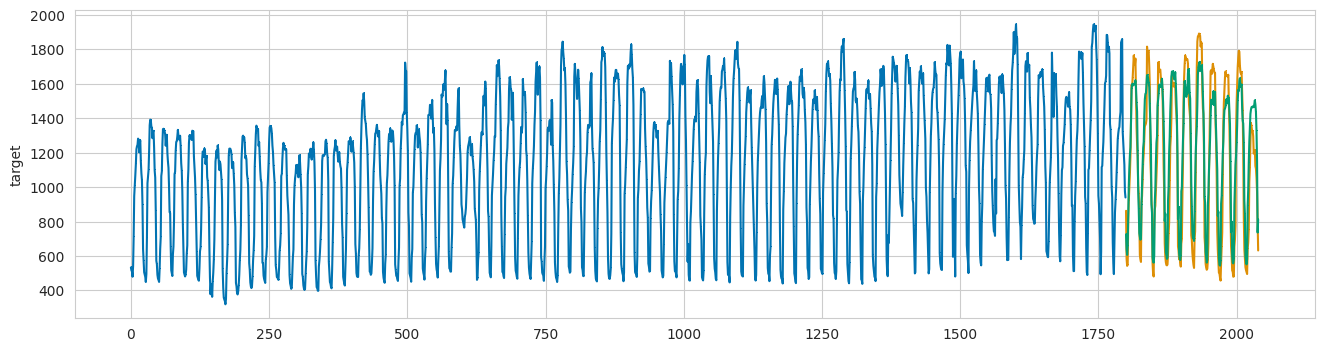

In [1319]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1320]:
_smape(y_valid, x_pred)

6.845730647417712

In [1321]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 1136.114912


(5040,)

## 99

In [1322]:
train_ft_99.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간', 'AT'],
      dtype='object')

- 불필요 컬럼 제거

In [1323]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

train_ft_99 = train_ft_99.drop(columns=drop_cols)
train_ft_99.head()

target    기온  강수량   풍속    습도  hour  weekday  month  공휴일  min_temperature  \
0  642.96  23.1  0.0  1.4  17.0     0        2      6    0             16.9   
1  603.36  23.1  0.0  3.0  17.0     1        2      6    0             16.9   
2  581.22  23.1  0.0  1.6  17.0     2        2      6    0             16.9   
3  599.94  23.0  0.0  2.6  18.0     3        2      6    0             16.9   
4  595.62  21.2  0.0  1.2  23.0     4        2      6    0             16.9   

   사용시간        AT  
0     0  5.526711  
1     0  0.339631  
2     0  4.662996  
3     0  1.329402  
4     0  5.874118

In [1324]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

test_ft_99 = test_ft_99.drop(columns=drop_cols)
test_ft_99.head()

기온  강수량   풍속  습도  hour  weekday  month  공휴일  min_temperature  사용시간  \
0  18.8  0.0  1.2  90     0        3      8    1             18.2     0   
1  18.2  0.0  1.0  91     1        3      8    1             18.2     0   
2  18.3  0.0  0.0  91     2        3      8    1             18.2     0   
3  18.3  0.0  0.8  91     3        3      8    1             18.2     0   
4  18.2  0.0  0.2  92     4        3      8    1             18.2     0   

          AT  
0   5.082118  
1   6.006000  
2  43.939000  
3   7.368272  
4  14.610291

- 모델링

In [1325]:
train_x = train_ft_99.iloc[:, 1:]
train_y = train_ft_99['target']

test_x = test_ft_99

In [1326]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1327]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 690
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 1156.120100
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[67]	training's l2: 808.512	valid_1's l2: 2564.4


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

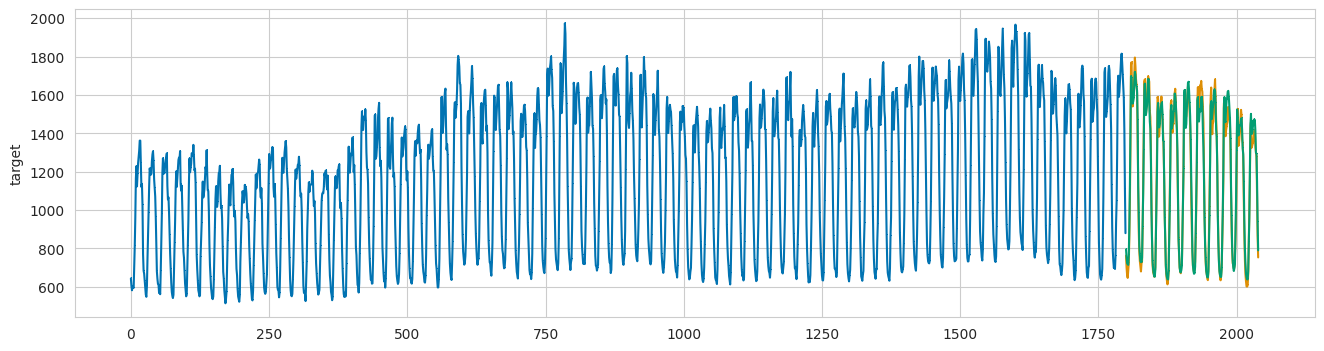

In [1328]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1329]:
_smape(y_valid, x_pred)

1.6464263999427537

In [1330]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 1159.884794


(5208,)

## 100

In [1331]:
train_ft_100.columns

Index(['target', 'num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도',
       '일조', '일사', 'hour', 'weekday', 'date', 'day', 'month', 'weekend',
       '건물유형', '연면적', '냉방면적', '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', '공휴일',
       'km_cluster', 'min_temperature', '사용시간', 'CDH'],
      dtype='object')

- 불필요 컬럼 제거

In [1332]:
drop_cols = ['num_date_time', 'num', 'date_time', '일조', '일사', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

train_ft_100 = train_ft_100.drop(columns=drop_cols)
train_ft_100.head()

target    기온  강수량   풍속    습도  hour  weekday  month  공휴일  min_temperature  \
0  372.00  15.0  0.0  0.3  70.0     0        2      6    0             12.4   
1  333.36  14.2  0.0  0.1  75.0     1        2      6    0             12.4   
2  320.64  13.5  0.0  0.1  77.0     2        2      6    0             12.4   
3  311.04  13.4  0.0  0.2  81.0     3        2      6    0             12.4   
4  312.48  13.8  0.0  0.2  79.0     4        2      6    0             12.4   

   사용시간   CDH  
0     0 -11.0  
1     0 -22.8  
2     0 -35.3  
3     0 -47.9  
4     0 -60.1

In [1333]:
drop_cols = ['num_date_time', 'num', 'date_time', 'date', 'day', '건물유형', '연면적', '냉방면적',
            '태양광용량', 'ESS저장용량', 'PCS용량', '태양광보유', 'km_cluster', 'weekend']

test_ft_100 = test_ft_100.drop(columns=drop_cols)
test_ft_100.head()

기온  강수량   풍속   습도  hour  weekday  month  공휴일  min_temperature  사용시간   CDH
0  20.2  0.0  0.0   97     0        3      8    1             18.8     0  -5.8
1  19.7  0.0  0.1   99     1        3      8    1             18.8     0 -12.1
2  19.4  0.0  0.1   99     2        3      8    1             18.8     0 -18.7
3  19.2  0.0  0.0  100     3        3      8    1             18.8     0 -25.5
4  19.0  0.0  0.0  100     4        3      8    1             18.8     0 -32.5

- 모델링

In [1334]:
train_x = train_ft_100.iloc[:, 1:]
train_y = train_ft_100['target']

test_x = test_ft_100

In [1335]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 11), (240, 11), (1800,), (240,))

In [1336]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 11
[LightGBM] [Info] Start training from score 818.833467
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[42]	training's l2: 1620.28	valid_1's l2: 3419.67


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='target'>)

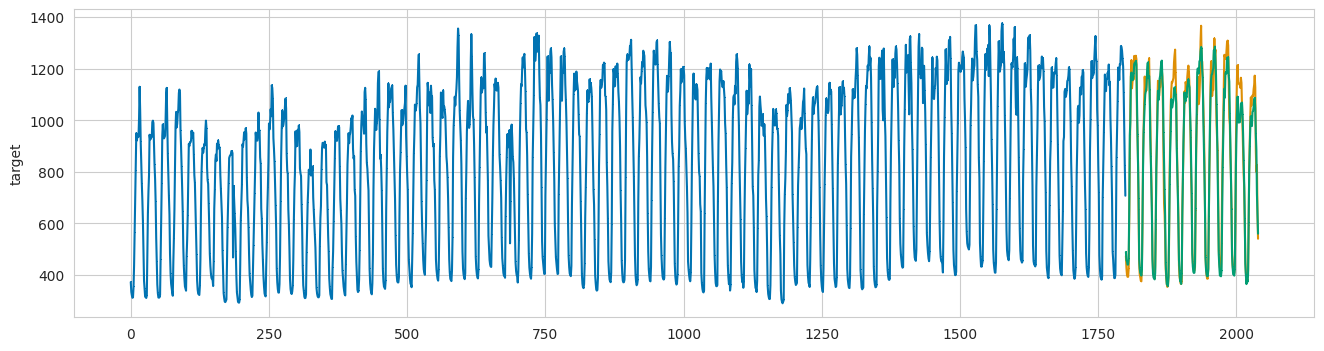

In [1337]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [1338]:
_smape(y_valid, x_pred)

2.490290805219583

In [1339]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 11
[LightGBM] [Info] Start training from score 824.705177


(5376,)

In [1340]:
test_ft.shape

(5376, 23)

In [1344]:
sub.iloc[11424:]

num_date_time  answer
11424   69_20220825 00       0
11425   69_20220825 01       0
11426   69_20220825 02       0
11427   69_20220825 03       0
11428   69_20220825 04       0
...                ...     ...
16795  100_20220831 19       0
16796  100_20220831 20       0
16797  100_20220831 21       0
16798  100_20220831 22       0
16799  100_20220831 23       0

[5376 rows x 2 columns]

In [1345]:
sub.iloc[11424:,1] = pred

In [1346]:
sub.iloc[11424:]

num_date_time       answer
11424   69_20220825 00  3631.433156
11425   69_20220825 01  3649.683115
11426   69_20220825 02  3618.716647
11427   69_20220825 03  3604.345603
11428   69_20220825 04  3633.327043
...                ...          ...
16795  100_20220831 19   808.312162
16796  100_20220831 20   725.516982
16797  100_20220831 21   658.140574
16798  100_20220831 22   578.439591
16799  100_20220831 23   505.004927

[5376 rows x 2 columns]

In [1347]:
sub.to_csv('submission_69_100.csv', index=False)